## K-Means

In [ ]:
import numpy as np
import math
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt # Importa matplotlib para visualização
import pandas as pd
class KMeans:
    """
    Implementação do algoritmo K-means para agrupamento (clusterização) de dados.
    """
    def __init__(self, numero_clusters=3, max_iteracoes=200, tolerancia=1e-5, plotar_passos=False):
        """
        Inicializa o algoritmo K-means com os parâmetros definidos.

        Args:
            numero_clusters (int): O número de clusters (k) desejado para agrupar os dados.
            max_iteracoes (int): O número máximo de iterações permitidas para o algoritmo.
            tolerancia (float): Um valor pequeno que define o critério de parada.
                                Se a distância que os centroides se movem entre iterações for menor que este valor,
                                o algoritmo é considerado convergido.
            plotar_passos (bool): Se verdadeiro, tenta plotar o estado dos agrupamentos a cada iteração.
        """
        self.numero_clusters = numero_clusters
        self.max_iteracoes = max_iteracoes
        self.tolerancia = tolerancia
        self.plotar_passos = plotar_passos
        self.centroides = None # Armazenará os centroides dos clusters
        self.agrupamentos = None # Armazenará os índices dos pontos de dados pertencentes a cada cluster
        self.dados = None # Armazenará os dados de entrada para o treinamento

    def distancia_euclidiana(self, vetor1, vetor2):
        """
        Calcula a distância Euclidiana entre dois vetores (pontos no espaço).
        """
        return np.linalg.norm(vetor1 - vetor2)

    def _atribuir_ponto_ao_cluster(self, ponto_dado, centroides_atuais):
        """
        Atribui um ponto de dado ao centroide mais próximo, calculando a distância
        deste ponto a todos os centroides atuais.
        """
        distancias = [self.distancia_euclidiana(ponto_dado, c) for c in centroides_atuais]
        indice_mais_proximo = np.argmin(distancias)
        return indice_mais_proximo

    def _criar_agrupamentos(self, dados_entrada, centroides_atuais):
        """
        Organiza os pontos de dados em clusters, atribuindo cada ponto ao seu centroide mais próximo.
        Returna uma lista de listas, onde cada sublista contém os índices dos pontos que foram atribuídos a um cluster específico.
        """
        agrupamentos = [[] for _ in range(self.numero_clusters)]
        for indice_ponto, ponto_dado in enumerate(dados_entrada):
            indice_centroide = self._atribuir_ponto_ao_cluster(ponto_dado, centroides_atuais)
            agrupamentos[indice_centroide].append(indice_ponto)
        return agrupamentos

    def _atualizar_centroides(self, dados_entrada, agrupamentos_atuais):
        """
        Recalcula as posições dos centroides, utilizando a média dos pontos de dados
        atribuídos a cada cluster.
        """
        novos_centroides = np.zeros((self.numero_clusters, dados_entrada.shape[1]))
        for idx, indices_pontos in enumerate(agrupamentos_atuais):
            if len(indices_pontos) > 0: # Garante que o cluster não esteja vazio para evitar erro de divisão por zero
                pontos_do_cluster = dados_entrada[indices_pontos]
                novos_centroides[idx] = np.mean(pontos_do_cluster, axis=0)
            else:
                # Se um cluster ficar vazio, o centroide correspondente não é movido
                novos_centroides[idx] = self.centroides[idx]
        return novos_centroides

    def treinar(self, dados_treinamento):
        """
        Executa o algoritmo K-means para agrupar os dados de treinamento.

        """
        self.dados = dados_treinamento # Armazena os dados para uso interno na instância

        # 1. Inicialização: Seleciona k centroides iniciais aleatoriamente a partir dos próprios dados
        indices_iniciais = np.random.choice(self.dados.shape[0], self.numero_clusters, replace=False)
        self.centroides = self.dados[indices_iniciais]

        # Loop principal de iterações para refinamento dos clusters
        for iteracao in range(self.max_iteracoes):
            # Armazena os centroides da iteração anterior para verificar a convergência
            centroides_anteriores = self.centroides.copy()

            # 2. Fase de Atribuição: Atribui cada ponto de dado ao cluster cujo centroide é o mais próximo
            self.agrupamentos = self._criar_agrupamentos(self.dados, self.centroides)

            # 3. Fase de Atualização: Recalcula a posição dos centroides com base nos pontos atribuídos
            self.centroides = self._atualizar_centroides(self.dados, self.agrupamentos)

            # 4. Critério de Parada: Verifica a convergência pela distância de movimento dos centroides
            movimento_maximo_centroide = 0.0
            for i in range(self.numero_clusters):
                distancia_movida = self.distancia_euclidiana(self.centroides[i], centroides_anteriores[i])
                if distancia_movida > movimento_maximo_centroide:
                    movimento_maximo_centroide = distancia_movida

            # Se o maior movimento de um centroide for menor que a tolerância, o algoritmo convergiu
            if movimento_maximo_centroide < self.tolerancia:
                print(f"K-means convergiu na iteração {iteracao + 1}. Movimento máximo do centroide: {movimento_maximo_centroide:.6f}")
                break

            # Opcional: plotar o estado dos agrupamentos a cada passo (se a flag plotar_passos for True e for 2D)
            if self.plotar_passos and self.dados.shape[1] == 2:
                self._plotar_agrupamentos(f"Iteração {iteracao + 1}")

        # Se o loop terminar por atingir max_iteracoes sem convergir
        if iteracao == self.max_iteracoes - 1 and movimento_maximo_centroide >= self.tolerancia:
            print(f"K-means atingiu o número máximo de iterações ({self.max_iteracoes}) sem convergir totalmente.")

        return self.centroides, self.agrupamentos



def carregar_e_normalizar_iris():
    """
    Carrega o dataset Iris da biblioteca scikit-learn e normaliza seus atributos
    para o intervalo entre 0 e 1 (Normalização Min-Max).

    Returns:
        np.array: O dataset Iris normalizado, pronto para ser utilizado pelo K-means.
    """
    iris = load_iris()
    dados = iris.data # Carrega os atributos do dataset Iris

    # Realiza a Normalização Min-Max para cada atributo
    min_vals = dados.min(axis=0) # Valores mínimos de cada coluna
    max_vals = dados.max(axis=0) # Valores máximos de cada coluna

    # Evita divisão por zero: adiciona um pequeno valor (epsilon) no denominador
    # caso max_vals seja igual a min_vals para alguma coluna (atributo constante)
    dados_normalizados = (dados - min_vals) / (max_vals - min_vals + 1e-10)

    return dados_normalizados


--- Testando o K-means com Múltiplas Inicializações ---

--- Resultados da Melhor Execução do K-means (Após Múltiplas Tentativas) ---
Melhor SSE (Inércia) encontrada: 6.9822
Centroides Finais da Melhor Execução (normalizados):
 [[0.44125683 0.30737705 0.57571548 0.54918033]
 [0.19611111 0.595      0.07830508 0.06083333]
 [0.70726496 0.4508547  0.79704476 0.82478632]]

--- Plotando Convergência SSE da Melhor Execução do K-means ---


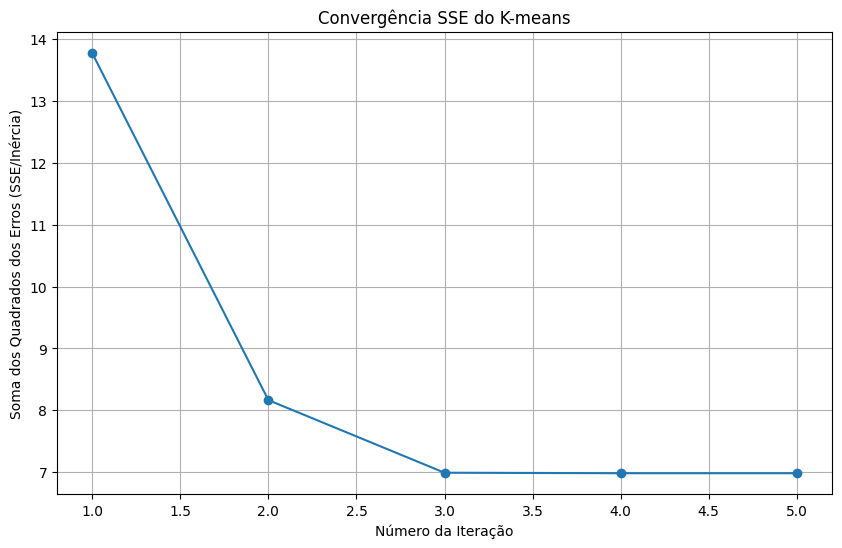


--- Avaliação da Taxa de Acerto (Comparando Melhor K-means com Classes Originais) ---
Pureza do Agrupamento K-means (Melhor Execução): 0.8867
Adjusted Rand Index (ARI) do Agrupamento K-means (Melhor Execução): 0.7163

--- Visualização dos Agrupamentos do K-means (Melhor Execução, Coordenadas Paralelas, Cores Ajustadas) ---


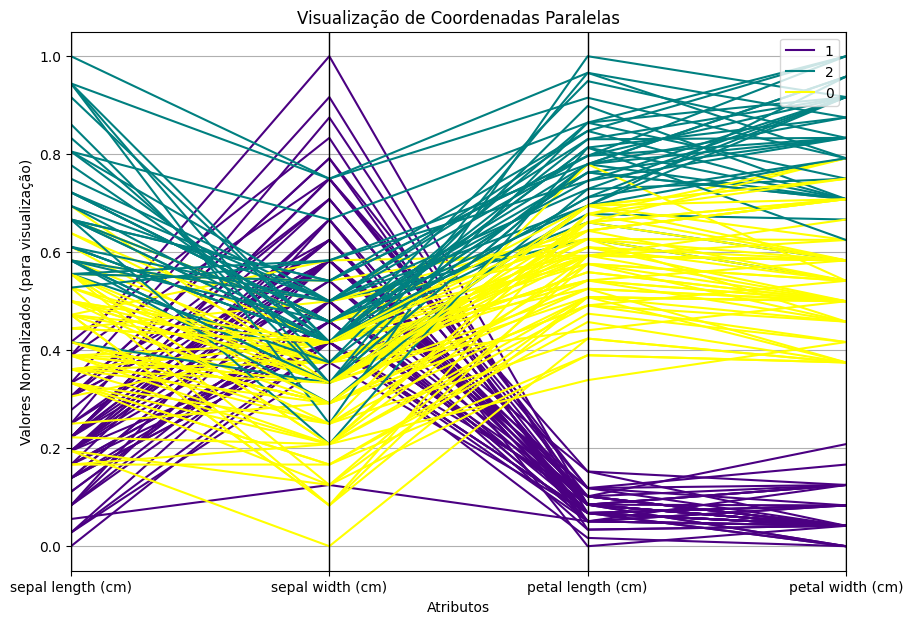


--- Visualização das Classes Originais do Iris (Coordenadas Paralelas) ---


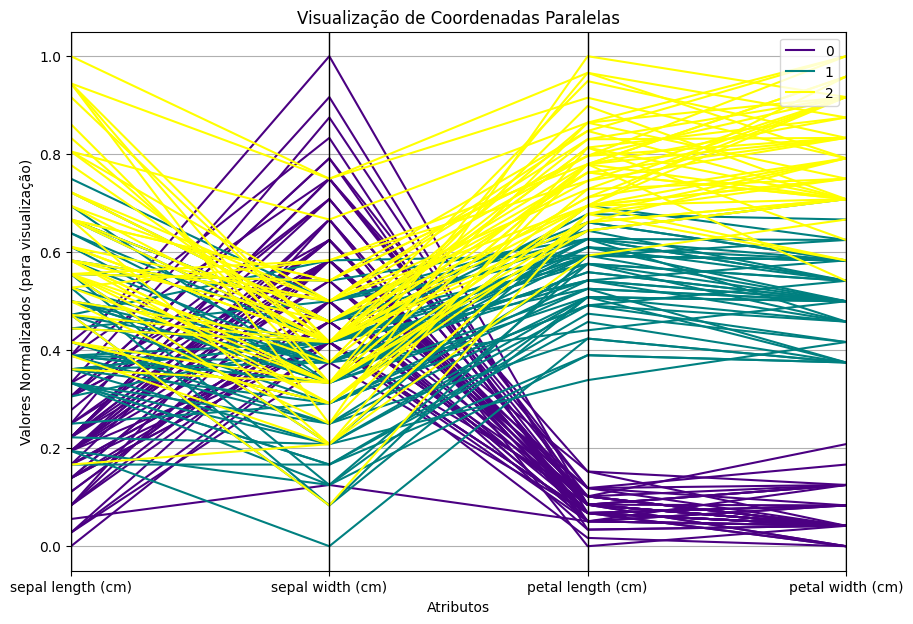

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.metrics import adjusted_rand_score
import matplotlib.lines as mlines # Necessário para a função de visualização de coordenadas paralelas, mesmo que a cor seja ignorada


# --- Definição da Classe KMeans ---
class KMeans:
    """
    Implementação do algoritmo K-means para agrupamento (clusterização) de dados.
    """
    def __init__(self, numero_clusters=3, max_iteracoes=100, tolerancia=1e-4, plotar_passos=False):
        self.numero_clusters = numero_clusters
        self.max_iteracoes = max_iteracoes
        self.tolerancia = tolerancia
        self.plotar_passos = plotar_passos
        self.centroides = None
        self.agrupamentos = None
        self.dados = None
        self.historico_sse = []

    def distancia_euclidiana(self, vetor1, vetor2):
        return np.linalg.norm(vetor1 - vetor2)

    def _atribuir_ponto_ao_cluster(self, ponto_dado, centroides_atuais):
        distancias = [self.distancia_euclidiana(ponto_dado, c) for c in centroides_atuais]
        indice_mais_proximo = np.argmin(distancias)
        return indice_mais_proximo

    def _criar_agrupamentos(self, dados_entrada, centroides_atuais):
        agrupamentos = [[] for _ in range(self.numero_clusters)]
        for indice_ponto, ponto_dado in enumerate(dados_entrada):
            indice_centroide = self._atribuir_ponto_ao_cluster(ponto_dado, centroides_atuais)
            agrupamentos[indice_centroide].append(indice_ponto)
        return agrupamentos

    def _atualizar_centroides(self, dados_entrada, agrupamentos_atuais):
        novos_centroides = np.zeros((self.numero_clusters, dados_entrada.shape[1]))
        for idx, indices_pontos in enumerate(agrupamentos_atuais):
            if len(indices_pontos) > 0:
                pontos_do_cluster = dados_entrada[indices_pontos]
                novos_centroides[idx] = np.mean(pontos_do_cluster, axis=0)
            else:
                novos_centroides[idx] = self.centroides[idx] # Mantém o centroide se o cluster ficar vazio
        return novos_centroides

    def treinar(self, dados_treinamento):
        self.dados = dados_treinamento
        self.historico_sse = []

        indices_iniciais = np.random.choice(self.dados.shape[0], self.numero_clusters, replace=False)
        self.centroides = self.dados[indices_iniciais]

        for iteracao in range(self.max_iteracoes):
            centroides_anteriores = self.centroides.copy()
            self.agrupamentos = self._criar_agrupamentos(self.dados, self.centroides)
            self.centroides = self._atualizar_centroides(self.dados, self.agrupamentos)

            current_sse = 0
            for cluster_id, indices_pontos in enumerate(self.agrupamentos):
                if indices_pontos:
                    pontos_do_cluster = self.dados[indices_pontos]
                    centroid = self.centroides[cluster_id]
                    current_sse += np.sum((pontos_do_cluster - centroid)**2)
            self.historico_sse.append(current_sse)

            movimento_maximo_centroide = 0.0
            for i in range(self.numero_clusters):
                distancia_movida = self.distancia_euclidiana(self.centroides[i], centroides_anteriores[i])
                if distancia_movida > movimento_maximo_centroide:
                    movimento_maximo_centroide = distancia_movida

            if movimento_maximo_centroide < self.tolerancia:
                break

            if self.plotar_passos and self.dados.shape[1] == 2:
                self._plotar_agrupamentos(f"Iteração {iteracao + 1}")

        if iteracao == self.max_iteracoes - 1 and movimento_maximo_centroide >= self.tolerancia:
            pass

        return self.centroides, self.agrupamentos, self.historico_sse[-1] if self.historico_sse else float('inf')

    def _plotar_agrupamentos(self, titulo="Agrupamentos K-means"):
        if self.dados.shape[1] != 2:
            print("Visualização de passos é possível apenas para dados 2D.")
            return

        plt.figure(figsize=(8, 6))
        cores = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'orange', 'brown']

        for idx, indices_pontos in enumerate(self.agrupamentos):
            if indices_pontos:
                pontos = self.dados[indices_pontos]
                plt.scatter(pontos[:, 0], pontos[:, 1], color=cores[idx % len(cores)], label=f'Cluster {idx + 1}', alpha=0.6)

        plt.scatter(self.centroides[:, 0], self.centroides[:, 1], marker='X', s=200, color='black', edgecolor='white', linewidth=1.5, label='Centroides')

        plt.title(titulo)
        plt.xlabel('Atributo 1')
        plt.ylabel('Atributo 2')
        plt.legend()
        plt.grid(True)
        plt.show()

# --- Funções Auxiliares ---
def carregar_e_normalizar_iris():
    iris = load_iris()
    dados = iris.data

    min_vals = dados.min(axis=0)
    max_vals = dados.max(axis=0)

    dados_normalizados = (dados - min_vals) / (max_vals - min_vals + 1e-10)

    return dados_normalizados

# Função de Visualização de Coordenadas Paralelas (Versão anterior, com cores fixas mas sem o tratamento extra da legenda)
def visualizar_coordenadas_paralelas(dados, classes, nomes_atributos=None):
    if nomes_atributos is None:
        nomes_atributos = [f'Atributo_{i}' for i in range(dados.shape[1])]

    df = pd.DataFrame(dados, columns=nomes_atributos)
    df['Classe'] = classes # A coluna 'Classe' pode conter os IDs brutos ou mapeados

    plt.figure(figsize=(10, 7))

    # --- Cores Personalizadas para as Classes (0, 1, 2) ---
    # Assegura que o colormap tenha cores fixas para os valores 0, 1, 2.
    # Esta parte é mantida pois o K-means mapeia para essas 3 classes.
    cores_fixas = ['#4B0082', '#008080', '#FFFF00'] # Roxo/Índigo, Verde-água/Teal, Amarelo
    custom_colormap = ListedColormap(cores_fixas)

    # Usa o colormap personalizado na função parallel_coordinates
    # A legenda será gerada automaticamente pelo Pandas, que pode ter a ordem "invertida"
    pd.plotting.parallel_coordinates(df, 'Classe', colormap=custom_colormap)

    plt.title('Visualização de Coordenadas Paralelas')
    plt.xlabel('Atributos')
    plt.ylabel('Valores Normalizados (para visualização)')
    plt.grid(True)
    plt.show()

# --- Funções de Plotagem e Métricas ---
def plotar_convergencia_sse(sse_history, titulo="Convergência SSE do K-means"):
    if not sse_history:
        print("Histórico de SSE não disponível.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(sse_history) + 1), sse_history, marker='o', linestyle='-')
    plt.title(titulo)
    plt.xlabel('Número da Iteração')
    plt.ylabel('Soma dos Quadrados dos Erros (SSE/Inércia)')
    plt.grid(True)
    plt.show()

def calcular_pureza(rotulos_verdadeiros, rotulos_preditos):
    if len(rotulos_verdadeiros) != len(rotulos_preditos):
        raise ValueError("Os arrays de rótulos devem ter o mesmo comprimento.")

    total_pontos = len(rotulos_verdadeiros)
    if total_pontos == 0:
        return 0.0

    cluster_class_counts = {}
    for true_label, predicted_label in zip(rotulos_verdadeiros, rotulos_preditos):
        if predicted_label not in cluster_class_counts:
            cluster_class_counts[predicted_label] = {}
        if true_label not in cluster_class_counts[predicted_label]:
            cluster_class_counts[predicted_label][true_label] = 0
        cluster_class_counts[predicted_label][true_label] += 1

    soma_maior_contagem = 0
    for cluster_label in cluster_class_counts:
        if cluster_class_counts[cluster_label]:
            soma_maior_contagem += max(cluster_class_counts[cluster_label].values())

    pureza = soma_maior_contagem / total_pontos
    return pureza

def calcular_ari(rotulos_verdadeiros, rotulos_preditos):
    return adjusted_rand_score(rotulos_verdadeiros, rotulos_preditos)


# --- Bloco Principal para Teste (com múltiplas rodadas) ---
if __name__ == "__main__":
    # Carrega o dataset Iris e o normaliza
    iris_dataset = load_iris()
    dados_iris_original = iris_dataset.data
    classes_iris_original = iris_dataset.target # As classes originais do Iris (0, 1, 2)
    nomes_atributos_iris = iris_dataset.feature_names

    dados_iris_normalizados = carregar_e_normalizar_iris()

    print("--- Testando o K-means com Múltiplas Inicializações ---")

    num_runs = 20 # Número de vezes para rodar o K-means
    best_sse = float('inf')
    best_centroides = None
    best_agrupamentos = None
    best_rotulos_kmeans = None
    best_historico_sse = None # Para armazenar o histórico SSE da melhor execução

    for i in range(num_runs):
        kmeans_instancia = KMeans(numero_clusters=3, max_iteracoes=300, tolerancia=1e-4, plotar_passos=False)

        # Treina e captura o SSE final desta execução
        current_centroides, current_agrupamentos, current_final_sse = kmeans_instancia.treinar(dados_iris_normalizados)

        # Se esta execução obteve um SSE melhor, armazena seus resultados
        if current_final_sse < best_sse:
            best_sse = current_final_sse
            best_centroides = current_centroides
            best_agrupamentos = current_agrupamentos
            best_historico_sse = kmeans_instancia.historico_sse # Salva o histórico completo da melhor run

            # Reconstrói os rótulos do K-means para esta melhor execução
            temp_rotulos_kmeans = np.zeros(dados_iris_normalizados.shape[0], dtype=int)
            for cluster_id, indices_pontos in enumerate(best_agrupamentos):
                for idx in indices_pontos:
                    temp_rotulos_kmeans[idx] = cluster_id
            best_rotulos_kmeans = temp_rotulos_kmeans

    print("\n--- Resultados da Melhor Execução do K-means (Após Múltiplas Tentativas) ---")
    print(f"Melhor SSE (Inércia) encontrada: {best_sse:.4f}")
    print("Centroides Finais da Melhor Execução (normalizados):\n", best_centroides)

    # --- Plotar a Convergência do SSE da MELHOR execução ---
    print("\n--- Plotando Convergência SSE da Melhor Execução do K-means ---")
    plotar_convergencia_sse(best_historico_sse) # Passa o histórico da melhor run

    # --- Avaliar a Taxa de Acerto (Pureza e ARI) da MELHOR execução ---
    print("\n--- Avaliação da Taxa de Acerto (Comparando Melhor K-means com Classes Originais) ---")
    # Utilizamos os rótulos do K-means da melhor execução para as métricas
    pureza = calcular_pureza(classes_iris_original, best_rotulos_kmeans)
    ari = calcular_ari(classes_iris_original, best_rotulos_kmeans)

    print(f"Pureza do Agrupamento K-means (Melhor Execução): {pureza:.4f}")
    print(f"Adjusted Rand Index (ARI) do Agrupamento K-means (Melhor Execução): {ari:.4f}")


    print("\n--- Visualização dos Agrupamentos do K-means (Melhor Execução, Coordenadas Paralelas, Cores Ajustadas) ---")
    visualizar_coordenadas_paralelas(dados_iris_normalizados, best_rotulos_kmeans, nomes_atributos_iris)


    print("\n--- Visualização das Classes Originais do Iris (Coordenadas Paralelas) ---")
    visualizar_coordenadas_paralelas(dados_iris_normalizados, classes_iris_original, nomes_atributos_iris)

## SOM

Implementação e testes com o IrisData Set para Clusterização

In [ ]:
import numpy as np
import math
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt # Importa matplotlib para visualização
import matplotlib.colors as mcolors

# Classe Neuronio: Representa um único neurônio no mapa SOM
class Neuronio:
    def __init__(self, numero_atributos, linha, coluna, pesos_aleatorios=True):
        """
        Inicializa um neurônio no mapa SOM.

        Args:
            numero_atributos (int): Número de atributos do vetor de pesos (mesma dimensão da entrada).
            linha (int): Posição da linha do neurônio no grid.
            coluna (int): Posição da coluna do neurônio no grid.
            pesos_aleatorios (bool): Se True, inicializa os pesos com valores aleatórios entre 0 e 1.
                                     Caso contrário, inicializa com zeros.
        """
        self.w = [] # Vetor de pesos do neurônio
        self.linha = linha
        self.coluna = coluna
        for _ in range(numero_atributos):
            peso = 0
            if pesos_aleatorios:
                peso = np.random.uniform(0, 1.0) # Usa numpy para uniform
            self.w.append(peso)
        self.w = np.array(self.w) # Converte a lista de pesos para array numpy para facilitar operações

# Classe SOM: Implementa o algoritmo Self-Organizing Map
class SOM:
    def __init__(self, linhas, colunas, iteracoes, taxa_aprendizado_inicial, sigma_inicial, decaimento='linear'):
        """
        Inicializa o mapa SOM.

        Args:
            linhas (int): Número de linhas do grid SOM.
            colunas (int): Número de colunas do grid SOM.
            iteracoes (int): Número total de iterações (épocas) de treinamento (T).
            taxa_aprendizado_inicial (float): Taxa de aprendizado inicial (eta_0).
            sigma_inicial (float): Raio de vizinhança inicial (sigma_0).
            decaimento (str): Estratégia de decaimento para eta e sigma ('constante', 'linear', 'nao-linear').
        """
        self.linhas = linhas
        self.colunas = colunas
        self.iteracoes = iteracoes
        self.taxa_aprendizado_inicial = taxa_aprendizado_inicial
        self.sigma_inicial = sigma_inicial
        self.decaimento = decaimento
        self.matriz = [] # O grid de neurônios
        self.entradas_treinamento = None # Será preenchido com os dados de entrada normalizados
        self.numero_atributos = None # Dimensão dos dados de entrada
        self.erros_por_epoca = []

    def _inicializar_pesos(self):
        """Inicializa os pesos de todos os neurônios no grid."""
        for i in range(self.linhas):
            self.matriz.append([])
            for j in range(self.colunas):
                # Passa True para pesos_aleatorios para inicialização aleatória
                self.matriz[i].append(Neuronio(self.numero_atributos, linha=i, coluna=j, pesos_aleatorios=True))

    def distancia_euclidiana(self, vetor1, vetor2):
        """
        Calcula a distância Euclidiana entre dois vetores.
        Corresponde a d_j = sqrt(sum((x_k - w_j,k)^2)) na formulação matemática.
        """
        return np.linalg.norm(vetor1 - vetor2)

    def calcular_bmu(self, entrada):
        """
        Encontra a Unidade de Melhor Correspondência (BMU) para uma dada entrada.
        Corresponde a BMU = argmin_j(d_j) na formulação matemática.
        """
        bmu = None
        menor_distancia = float('inf')

        for linha_mapa in self.matriz:
            for neuronio in linha_mapa:
                distancia_atual = self.distancia_euclidiana(entrada, neuronio.w)
                if distancia_atual < menor_distancia:
                    menor_distancia = distancia_atual
                    bmu = neuronio
        return bmu

    def _funcao_vizinhanca_gaussiana(self, r, sigma):
        """
        Calcula a função de vizinhança gaussiana (theta).
        Corresponde a theta(j*, j) = e^(-r / (2 * sigma^2)) na formulação matemática.
        """
        return math.exp(-r / (2 * sigma**2))

    def _atualizar_pesos(self, bmu, entrada, eta, sigma):
        """
        Atualiza os pesos de todos os neurônios no mapa.
        Corresponde a w_j_novo = w_j_antigo + theta(j*, j) * (x - w_j_antigo) * eta na formulação.
        """
        for linha_mapa in self.matriz:
            for neuronio_atual in linha_mapa:
                # Distância topológica (r) entre o BMU e o neurônio atual no grid
                # r = sqrt((j*_linha - j_linha)^2 + (j*_coluna - j_coluna)^2)
                r_topologica = self.distancia_euclidiana(
                    np.array([bmu.linha, bmu.coluna]),
                    np.array([neuronio_atual.linha, neuronio_atual.coluna])
                )

                # Calcula a taxa de vizinhança (theta)
                taxa_vizinhanca = self._funcao_vizinhanca_gaussiana(r_topologica, sigma)

                # Aplica a regra de atualização dos pesos
                neuronio_atual.w += taxa_vizinhanca * (entrada - neuronio_atual.w) * eta

    def _calcular_eta_k(self, k):
        """Calcula a taxa de aprendizado (eta) para a iteração k."""
        if self.decaimento == 'constante':
            return self.taxa_aprendizado_inicial
        elif self.decaimento == 'linear':
            return self.taxa_aprendizado_inicial * (1 - (k / self.iteracoes))
        elif self.decaimento == 'nao-linear':
            # Tau (constante de tempo) pode ser ajustado, aqui usando T/2 como exemplo
            tau = self.iteracoes / 2
            return self.taxa_aprendizado_inicial * math.exp(-k / tau)
        else:
            raise ValueError("Estratégia de decaimento inválida para eta.")

    def _calcular_sigma_k(self, k):
        """Calcula o raio de vizinhança (sigma) para a iteração k."""
        if self.decaimento == 'constante':
            return self.sigma_inicial
        elif self.decaimento == 'linear':
            # Sigma também pode decair linearmente
            return self.sigma_inicial * (1 - (k / self.iteracoes))
        elif self.decaimento == 'nao-linear':
            # Tau (constante de tempo) para sigma também pode ser ajustado
            tau = self.iteracoes / 2
            return self.sigma_inicial * math.exp(-k / tau)
        else:
            raise ValueError("Estratégia de decaimento inválida para sigma.")

    def treinar(self, dados_entrada):
        """
        Realiza o treinamento do SOM.

        Args:
            dados_entrada (np.ndarray): O conjunto de dados de entrada a ser treinado.
                                        Deve estar normalizado.
        """
        self.entradas_treinamento = dados_entrada
        self.numero_atributos = dados_entrada.shape[1] # Pega a dimensão dos vetores de entrada
        self._inicializar_pesos() # Inicializa os pesos dos neurônios
        self.erros_por_epoca = []

        print(f"Iniciando treinamento do SOM com {self.iteracoes} iterações...")
        for k in range(self.iteracoes):
            # Calcular eta_k e sigma_k para a iteração atual
            eta_k = self._calcular_eta_k(k)
            sigma_k = self._calcular_sigma_k(k)
            erro_epoca_atual = self.calcular_erro_quantizacao()
            self.erros_por_epoca.append(erro_epoca_atual)

            # Para cada entrada no conjunto de treinamento
            # Embaralhar os dados a cada época para evitar viés de ordem
            np.random.shuffle(self.entradas_treinamento)
            for entrada in self.entradas_treinamento:
                bmu = self.calcular_bmu(entrada) # Encontra o BMU para a entrada
                self._atualizar_pesos(bmu, entrada, eta_k, sigma_k) # Atualiza os pesos da rede

            if (k + 1) % (self.iteracoes // 10) == 0 or k == self.iteracoes -1:
                print(f"Iteração {k+1}/{self.iteracoes} - eta: {eta_k:.4f}, sigma: {sigma_k:.4f}")
        print("Treinamento concluído.")

    # --- Métodos para Análise e Visualização ---

    def calcular_erro_quantizacao(self):
        """
        Calcula o erro de quantização médio do mapa SOM.
        É a distância média entre cada vetor de entrada e o vetor de pesos de seu BMU.
        Um valor menor indica que os neurônios representam melhor os dados.
        """
        erro_total = 0.0
        for entrada in self.entradas_treinamento:
            bmu = self.calcular_bmu(entrada)
            erro_total += self.distancia_euclidiana(entrada, bmu.w)
        return erro_total / len(self.entradas_treinamento)

    def visualizar_umatrix(self, title="U-Matrix do SOM"):
        """
        Gera e exibe a U-Matrix do SOM.
        Mostra as distâncias entre neurônios adjacentes.
        Cores claras = neurônios similares (clusters).
        Cores escuras = neurônios diferentes (fronteiras de clusters).
        """
        umatrix = np.zeros((self.linhas, self.colunas))

        for i in range(self.linhas):
            for j in range(self.colunas):
                neuron_weights = self.matriz[i][j].w

                # Coleta as distâncias para os vizinhos diretos (não diagonais)
                neighbors_distances = []

                # Vizinho acima
                if i > 0:
                    neighbors_distances.append(self.distancia_euclidiana(neuron_weights, self.matriz[i-1][j].w))
                # Vizinho abaixo
                if i < self.linhas - 1:
                    neighbors_distances.append(self.distancia_euclidiana(neuron_weights, self.matriz[i+1][j].w))
                # Vizinho à esquerda
                if j > 0:
                    neighbors_distances.append(self.distancia_euclidiana(neuron_weights, self.matriz[i][j-1].w))
                # Vizinho à direita
                if j < self.colunas - 1:
                    neighbors_distances.append(self.distancia_euclidiana(neuron_weights, self.matriz[i][j+1].w))

                # Calcula a média das distâncias aos vizinhos
                if neighbors_distances:
                    umatrix[i, j] = np.mean(neighbors_distances)
                else: # Caso de um mapa 1x1, ou neurônio isolado (não aplicável aqui)
                    umatrix[i, j] = 0

        plt.figure(figsize=(self.colunas * 0.8, self.linhas * 0.8)) # Ajusta o tamanho da figura
        plt.imshow(umatrix, cmap='bone_r', interpolation='nearest') # 'bone_r' para escuro = distante, claro = perto
        plt.colorbar(label='Distância Média aos Vizinhos')
        plt.title(title)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    def visualizar_hit_map(self, labels=None, title="Hit Map do SOM"):
        """
        Gera e exibe o Hit Map (Mapa de Ativação) do SOM.
        Mostra quantos pontos de dados são mapeados para cada neurônio.
        """
        hit_map = np.zeros((self.linhas, self.colunas), dtype=int)

        if not hasattr(self, 'entradas_treinamento') or self.entradas_treinamento is None or len(self.entradas_treinamento) == 0:
            print("Erro: 'self.entradas_treinamento' não está definido ou é None/vazio. Certifique-se de que o SOM foi treinado ou os dados de entrada foram definidos.")
            return

        if labels is not None:
            dominant_labels_map = np.full((self.linhas, self.colunas), -1, dtype=int)

            neuron_label_counts = {}
            for i in range(self.linhas):
                for j in range(self.colunas):
                    neuron_label_counts[(i,j)] = {}

            for idx, entrada in enumerate(self.entradas_treinamento):
                bmu = self.calcular_bmu(entrada)
                hit_map[bmu.linha, bmu.coluna] += 1

                label_bmu = labels[idx]
                if label_bmu not in neuron_label_counts[(bmu.linha, bmu.coluna)]:
                    neuron_label_counts[(bmu.linha, bmu.coluna)][label_bmu] = 0
                neuron_label_counts[(bmu.linha, bmu.coluna)][label_bmu] += 1

            for i in range(self.linhas):
                for j in range(self.colunas):
                    counts = neuron_label_counts[(i,j)]
                    if counts:
                        dominant_label = max(counts, key=counts.get)
                        dominant_labels_map[i,j] = dominant_label

            # Depuração confirmada: todas as 3 classes estão no mapa!
            # classes_dominantes_no_mapa = np.unique(dominant_labels_map[dominant_labels_map != -1])
            # print(f"Classes que aparecem como dominantes no mapa (excluindo mortos): {classes_dominantes_no_mapa}")

            plt.figure(figsize=(self.colunas * 0.8, self.linhas * 0.8))

            unique_labels = np.unique(labels)
            num_classes = len(unique_labels)

            # --- SOLUÇÃO PARA CORES DISTINTAS: Colormap Personalizado ---

            # Mapeia cores para os labels usando uma paleta distinta como 'tab10'
            class_colors_map = {
                unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)
            }

            # Cor específica para neurônios mortos (-1) - um cinza claro para clareza
            dead_neuron_color = (0.85, 0.85, 0.85, 1.0) # Cinza bem claro

            # Cria a lista de todas as cores a serem usadas (ordem importa: morto, depois classes)
            colors_list = [dead_neuron_color]
            for label_val in unique_labels:
                colors_list.append(class_colors_map[label_val])

            # Define os limites para cada 'bin' de cor
            bounds = [-1.5] + [l + 0.5 for l in unique_labels]

            # Cria o colormap listado e a normalização baseada em limites
            cmap_custom = mcolors.ListedColormap(colors_list)
            norm_custom = mcolors.BoundaryNorm(bounds, cmap_custom.N)

            plt.imshow(dominant_labels_map, cmap=cmap_custom, norm=norm_custom, interpolation='nearest')

            # Cria a barra de cores customizada com os rótulos corretos
            cbar = plt.colorbar(ticks=unique_labels, label='Classe Dominante')
            cbar.ax.set_yticklabels([f"Classe {l}" for l in unique_labels])

            # Adiciona os números de hits no mapa
            for i in range(self.linhas):
                for j in range(self.colunas):
                    count = hit_map[i, j]
                    if count > 0:
                        # Ajusta a cor do texto para ser legível contra o novo fundo
                        pixel_color = cmap_custom(norm_custom(dominant_labels_map[i,j]))
                        luminance = np.dot(pixel_color[:3], [0.299, 0.587, 0.114])
                        text_color = 'black' if luminance > 0.5 else 'white'
                        plt.text(j, i, str(count), ha='center', va='center', color=text_color)
                    else:
                        plt.text(j, i, "0", ha='center', va='center', color='darkgray')

            plt.title(title + " (por Classe Dominante)")

        else: # Se não há labels, apenas o hit map padrão
            if not hasattr(self, 'entradas_treinamento') or self.entradas_treinamento is None or len(self.entradas_treinamento) == 0:
                print("Erro: 'self.entradas_treinamento' não está definido ou é None/vazio. Certifique-se de que o SOM foi treinado ou os dados de entrada foram definidos.")
                return

            for entrada in self.entradas_treinamento:
                bmu = self.calcular_bmu(entrada)
                hit_map[bmu.linha, bmu.coluna] += 1

            plt.figure(figsize=(self.colunas * 0.8, self.linhas * 0.8))
            plt.imshow(hit_map, cmap='Blues', interpolation='nearest')
            plt.colorbar(label='Número de Hits')
            plt.title(title)

            for i in range(self.linhas):
                for j in range(self.colunas):
                    plt.text(j, i, str(hit_map[i, j]), ha='center', va='center', color='black')

        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    def visualizar_component_planes(self, feature_names=None, title="Planos de Componentes do SOM"):
        """
        Gera e exibe os Planos de Componentes do SOM.
        Mostra os valores de peso para cada atributo (dimensão) dos dados.
        """
        if self.numero_atributos is None:
            print("Erro: O número de atributos não foi definido. Treine o SOM primeiro.")
            return

        # Calcular o layout da grade para os subplots
        num_cols_plot = min(self.numero_atributos, 4) # Máximo de 4 colunas por linha de subplots
        num_rows_plot = math.ceil(self.numero_atributos / num_cols_plot)

        fig, axes = plt.subplots(num_rows_plot, num_cols_plot, figsize=(num_cols_plot * 3, num_rows_plot * 3))
        axes = axes.flatten() # Achata a matriz de eixos para facilitar a iteração

        for f_idx in range(self.numero_atributos):
            component_plane = np.zeros((self.linhas, self.colunas))
            for i in range(self.linhas):
                for j in range(self.colunas):
                    component_plane[i, j] = self.matriz[i][j].w[f_idx]

            ax = axes[f_idx]
            im = ax.imshow(component_plane, cmap='viridis', interpolation='nearest')

            feature_name = feature_names[f_idx] if feature_names else f"Atributo {f_idx+1}"
            ax.set_title(f"{feature_name}")
            ax.set_xticks([])
            ax.set_yticks([])
            fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

        # Esconder subplots vazios, se houver
        for idx in range(self.numero_atributos, len(axes)):
            fig.delaxes(axes[idx])

        fig.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição do título
        plt.show()


# --- Funções Auxiliares para Carregamento e Normalização de Dados ---
def carregar_e_normalizar_iris():
    """
    Carrega o dataset Iris e normaliza seus atributos entre 0 e 1.
    """
    iris = load_iris()
    dados = iris.data # Atributos (sepal length, sepal width, petal length, petal width)

    # Normalização Min-Max
    min_vals = dados.min(axis=0)
    max_vals = dados.max(axis=0)
    # Evitar divisão por zero se max_vals == min_vals para alguma coluna
    # Adiciona um pequeno valor para evitar divisão por zero
    dados_normalizados = (dados - min_vals) / (max_vals - min_vals + 1e-10)

    return dados_normalizados, iris.target, iris.feature_names, iris.target_names



Shape dos dados normalizados: (150, 4)

--- Executando Cenário 0 (Pequeno, Rápido, LR Baixo) (Cenário 1/10) ---
Iniciando treinamento do SOM com 100 iterações...
Iteração 10/100 - eta: 0.2730, sigma: 1.8200
Iteração 20/100 - eta: 0.2430, sigma: 1.6200
Iteração 30/100 - eta: 0.2130, sigma: 1.4200
Iteração 40/100 - eta: 0.1830, sigma: 1.2200
Iteração 50/100 - eta: 0.1530, sigma: 1.0200
Iteração 60/100 - eta: 0.1230, sigma: 0.8200
Iteração 70/100 - eta: 0.0930, sigma: 0.6200
Iteração 80/100 - eta: 0.0630, sigma: 0.4200
Iteração 90/100 - eta: 0.0330, sigma: 0.2200
Iteração 100/100 - eta: 0.0030, sigma: 0.0200
Treinamento concluído.
Erro de Quantização para Cenário 0 (Pequeno, Rápido, LR Baixo): 0.1732


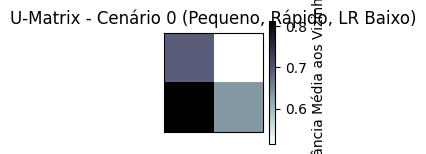

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


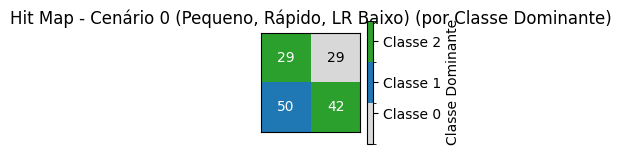

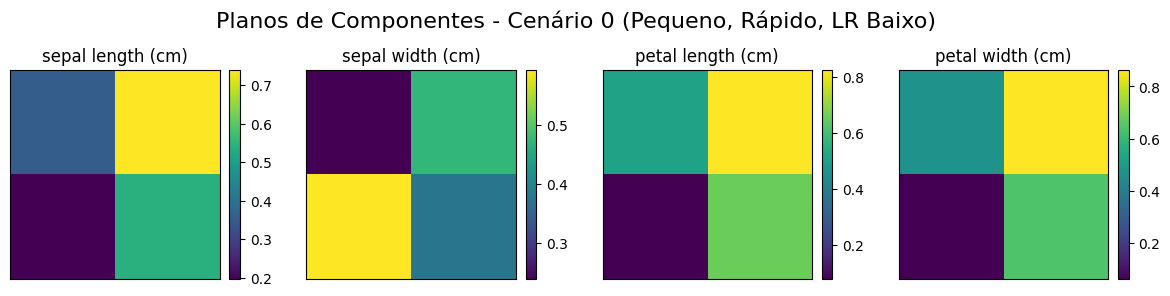

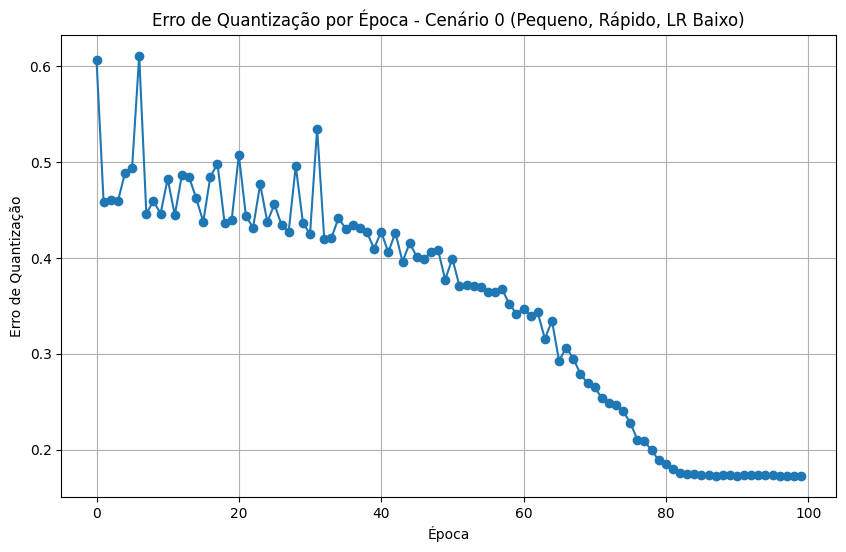


--- Executando Cenário 1 (Base, Linear) (Cenário 2/10) ---
Iniciando treinamento do SOM com 100 iterações...
Iteração 10/100 - eta: 0.4550, sigma: 1.8200
Iteração 20/100 - eta: 0.4050, sigma: 1.6200
Iteração 30/100 - eta: 0.3550, sigma: 1.4200
Iteração 40/100 - eta: 0.3050, sigma: 1.2200
Iteração 50/100 - eta: 0.2550, sigma: 1.0200
Iteração 60/100 - eta: 0.2050, sigma: 0.8200
Iteração 70/100 - eta: 0.1550, sigma: 0.6200
Iteração 80/100 - eta: 0.1050, sigma: 0.4200
Iteração 90/100 - eta: 0.0550, sigma: 0.2200
Iteração 100/100 - eta: 0.0050, sigma: 0.0200
Treinamento concluído.
Erro de Quantização para Cenário 1 (Base, Linear): 0.1113


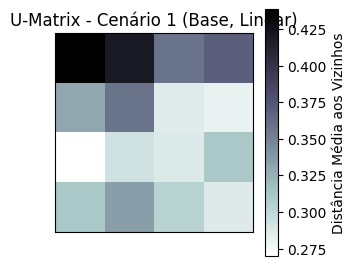

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


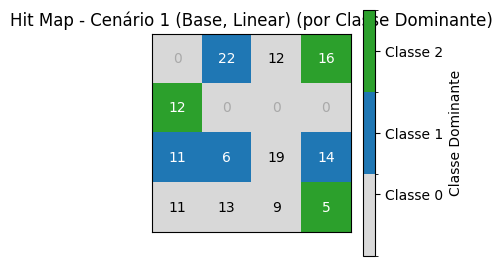

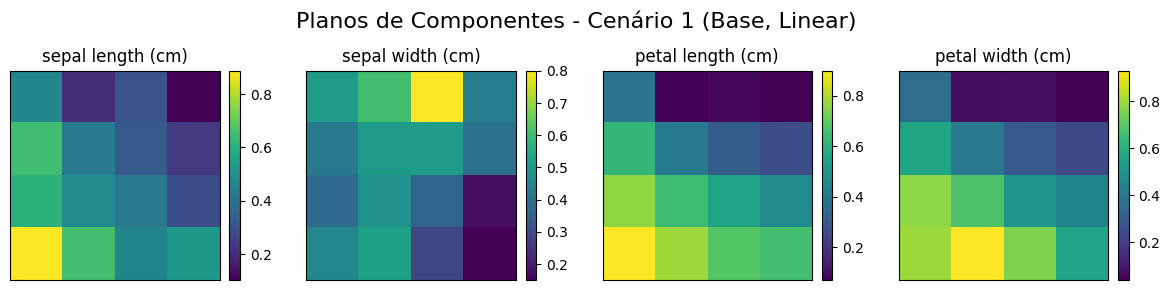

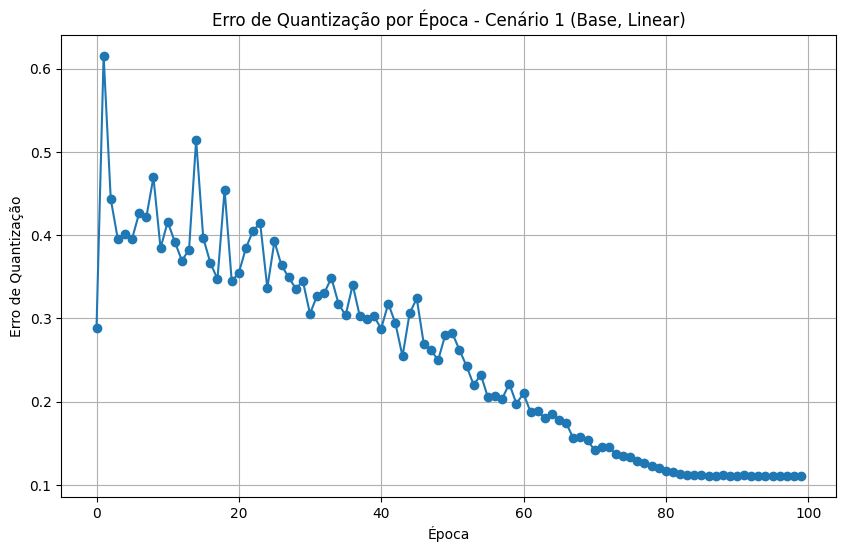


--- Executando Cenário 2 (Médio, Não-Linear) (Cenário 3/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.2481, sigma: 2.8944
Iteração 40/200 - eta: 0.2031, sigma: 2.3697
Iteração 60/200 - eta: 0.1663, sigma: 1.9401
Iteração 80/200 - eta: 0.1362, sigma: 1.5885
Iteração 100/200 - eta: 0.1115, sigma: 1.3005
Iteração 120/200 - eta: 0.0913, sigma: 1.0648
Iteração 140/200 - eta: 0.0747, sigma: 0.8718
Iteração 160/200 - eta: 0.0612, sigma: 0.7137
Iteração 180/200 - eta: 0.0501, sigma: 0.5844
Iteração 200/200 - eta: 0.0410, sigma: 0.4784
Treinamento concluído.
Erro de Quantização para Cenário 2 (Médio, Não-Linear): 0.0819


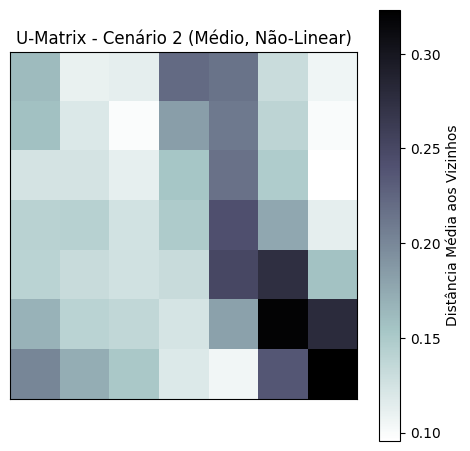

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


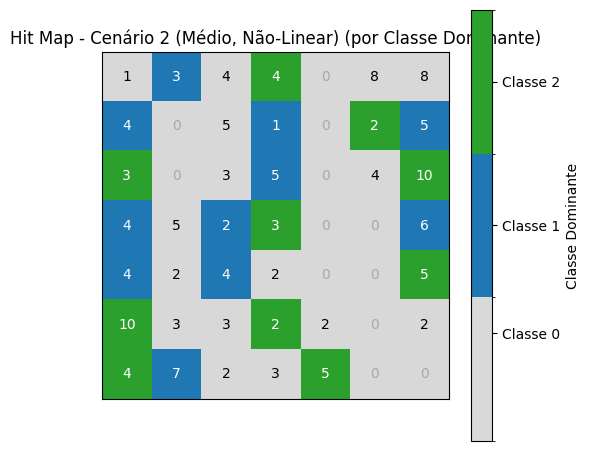

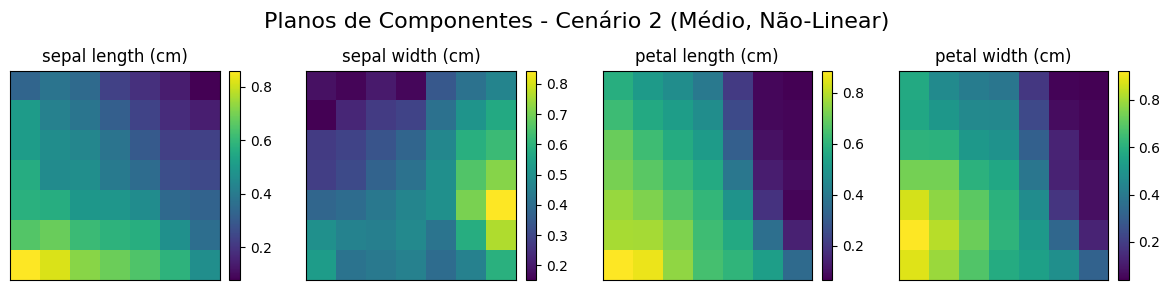

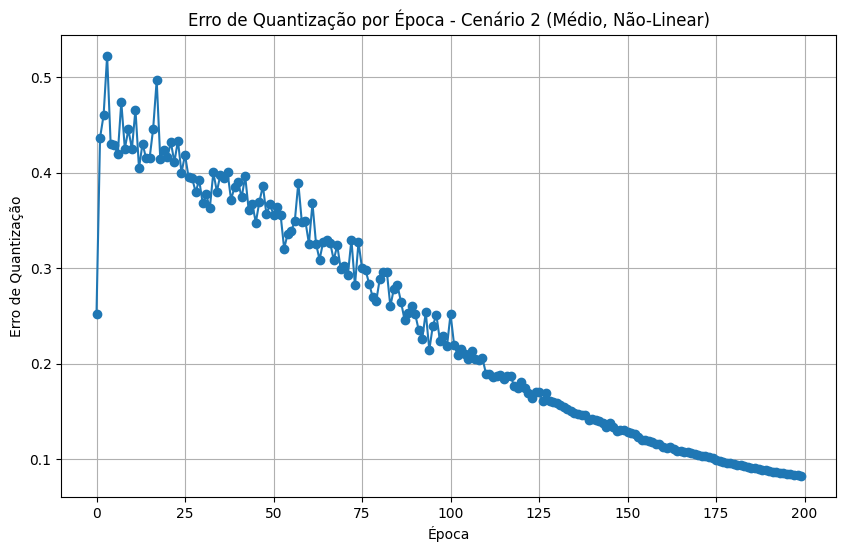


--- Executando Cenário 3 (Grande, Linear) (Cenário 4/10) ---
Iniciando treinamento do SOM com 300 iterações...
Iteração 30/300 - eta: 0.3613, sigma: 4.5167
Iteração 60/300 - eta: 0.3213, sigma: 4.0167
Iteração 90/300 - eta: 0.2813, sigma: 3.5167
Iteração 120/300 - eta: 0.2413, sigma: 3.0167
Iteração 150/300 - eta: 0.2013, sigma: 2.5167
Iteração 180/300 - eta: 0.1613, sigma: 2.0167
Iteração 210/300 - eta: 0.1213, sigma: 1.5167
Iteração 240/300 - eta: 0.0813, sigma: 1.0167
Iteração 270/300 - eta: 0.0413, sigma: 0.5167
Iteração 300/300 - eta: 0.0013, sigma: 0.0167
Treinamento concluído.
Erro de Quantização para Cenário 3 (Grande, Linear): 0.0580


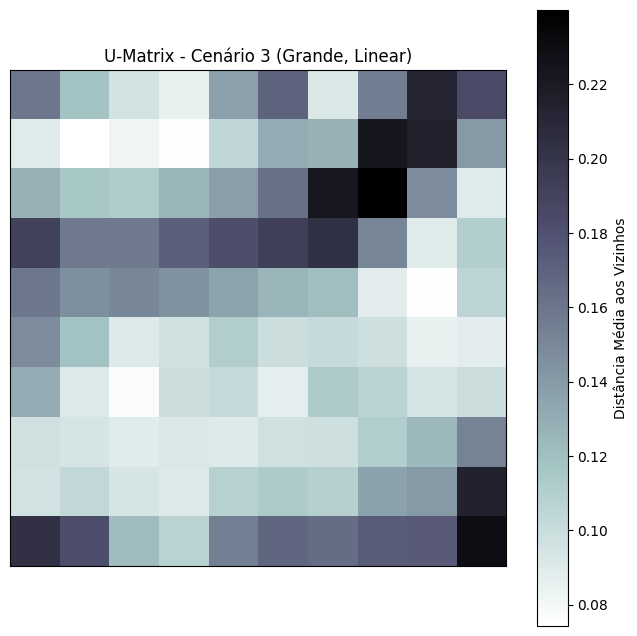

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


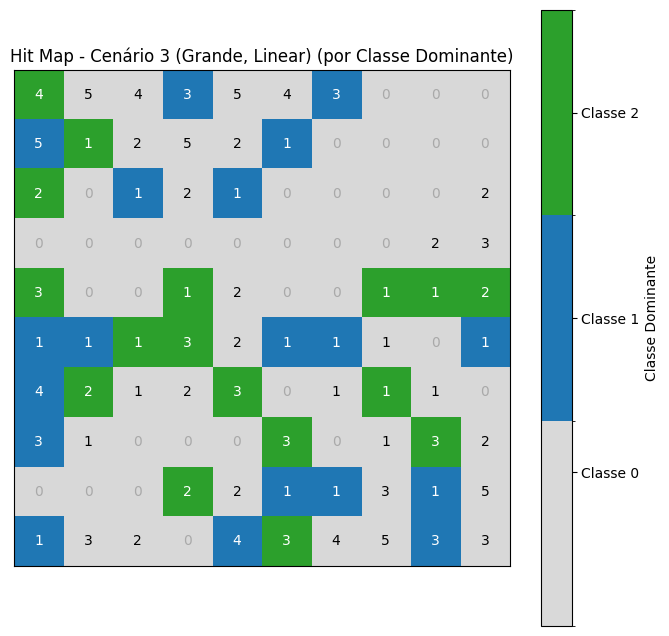

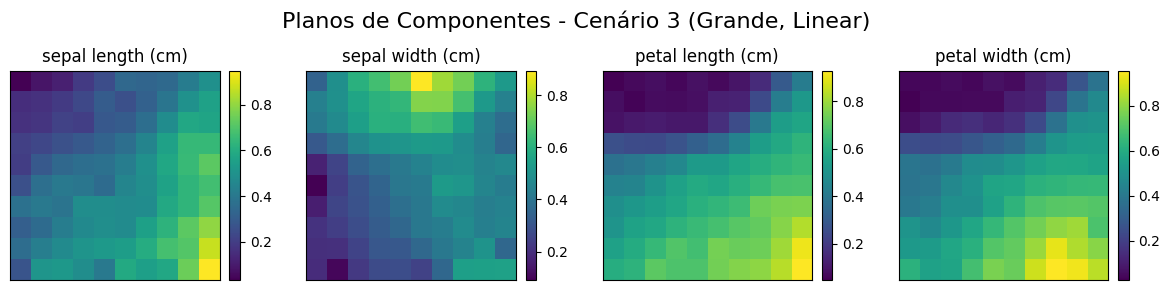

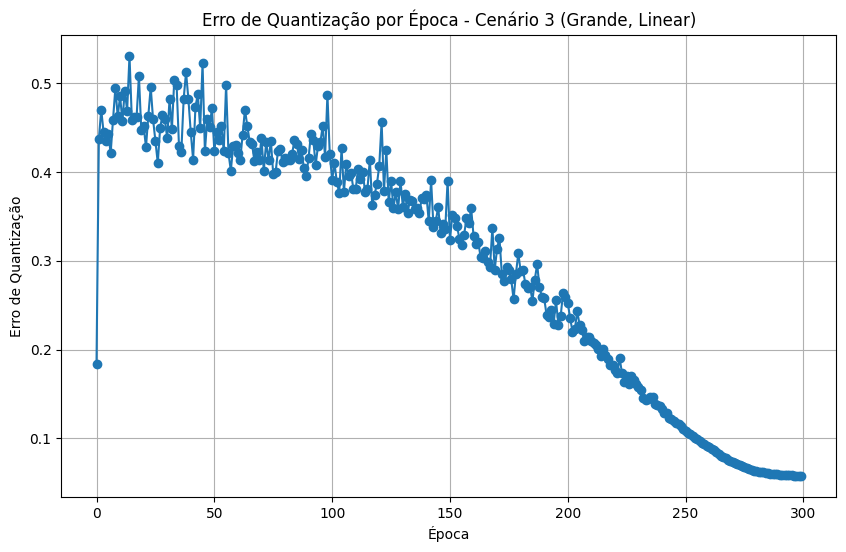


--- Executando Cenário 4 (Retangular, Não-Linear, LR Alto) (Cenário 5/10) ---
Iniciando treinamento do SOM com 150 iterações...
Iteração 15/150 - eta: 0.4978, sigma: 4.1486
Iteração 30/150 - eta: 0.4076, sigma: 3.3966
Iteração 45/150 - eta: 0.3337, sigma: 2.7809
Iteração 60/150 - eta: 0.2732, sigma: 2.2768
Iteração 75/150 - eta: 0.2237, sigma: 1.8641
Iteração 90/150 - eta: 0.1831, sigma: 1.5262
Iteração 105/150 - eta: 0.1499, sigma: 1.2495
Iteração 120/150 - eta: 0.1228, sigma: 1.0230
Iteração 135/150 - eta: 0.1005, sigma: 0.8376
Iteração 150/150 - eta: 0.0823, sigma: 0.6858
Treinamento concluído.
Erro de Quantização para Cenário 4 (Retangular, Não-Linear, LR Alto): 0.0972


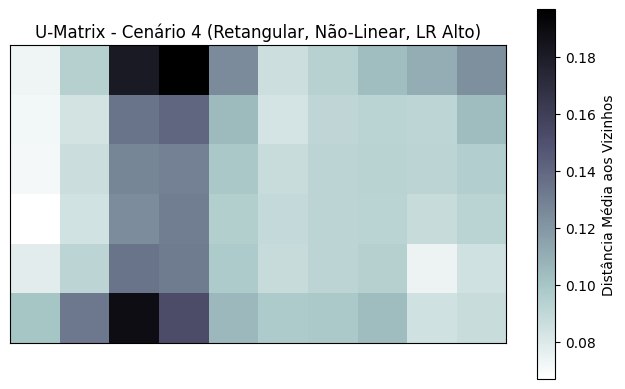

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


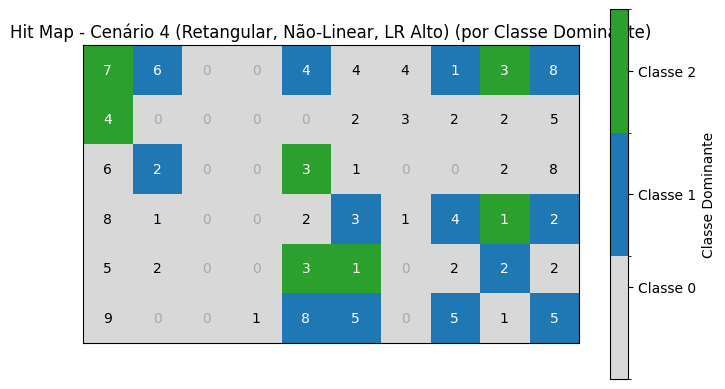

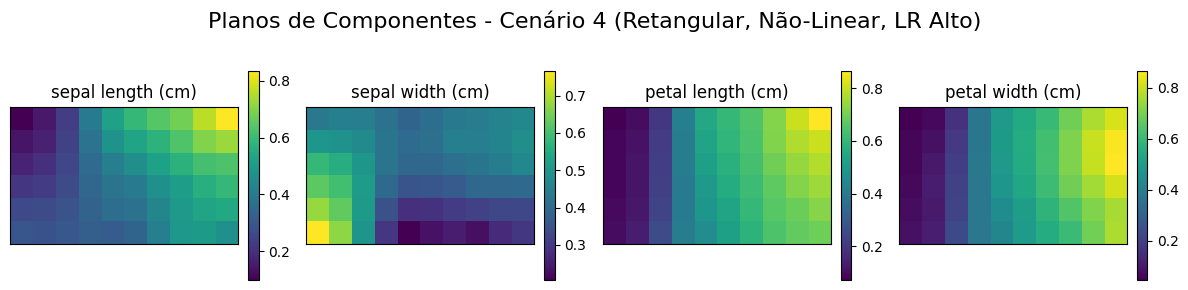

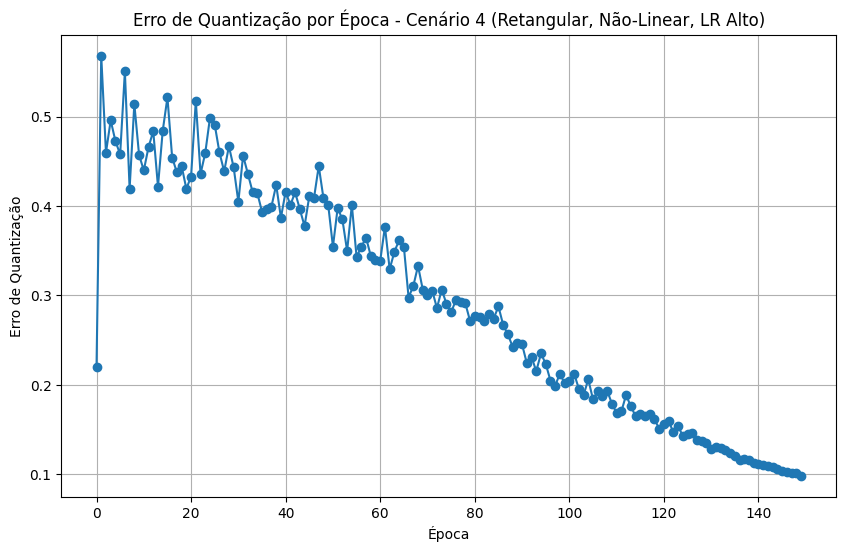


--- Executando Cenário 5 (Pequeno, Rápido, LR Alto) (Cenário 6/10) ---
Iniciando treinamento do SOM com 50 iterações...
Iteração 5/50 - eta: 0.6440, sigma: 1.3800
Iteração 10/50 - eta: 0.5740, sigma: 1.2300
Iteração 15/50 - eta: 0.5040, sigma: 1.0800
Iteração 20/50 - eta: 0.4340, sigma: 0.9300
Iteração 25/50 - eta: 0.3640, sigma: 0.7800
Iteração 30/50 - eta: 0.2940, sigma: 0.6300
Iteração 35/50 - eta: 0.2240, sigma: 0.4800
Iteração 40/50 - eta: 0.1540, sigma: 0.3300
Iteração 45/50 - eta: 0.0840, sigma: 0.1800
Iteração 50/50 - eta: 0.0140, sigma: 0.0300
Treinamento concluído.
Erro de Quantização para Cenário 5 (Pequeno, Rápido, LR Alto): 0.1300


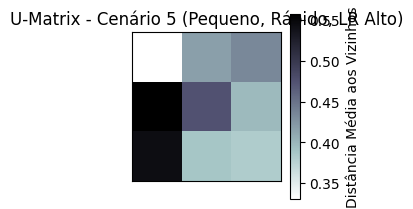

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


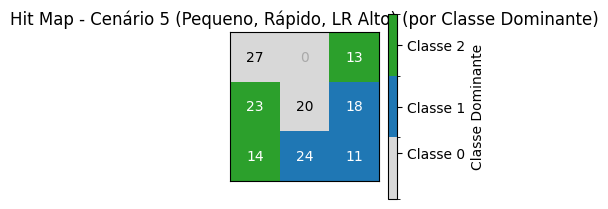

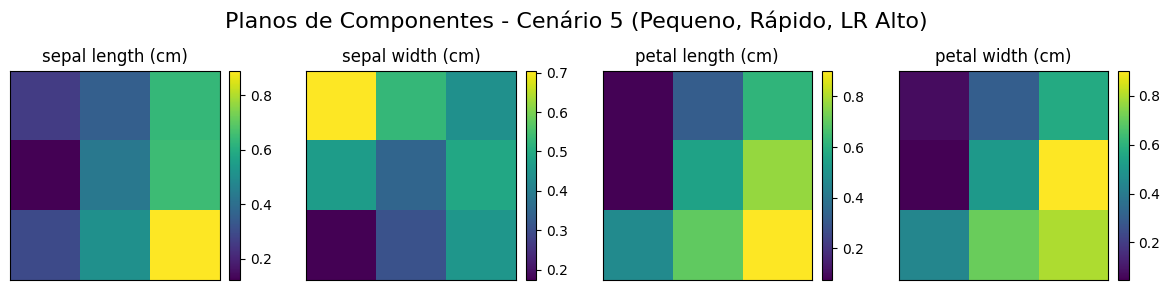

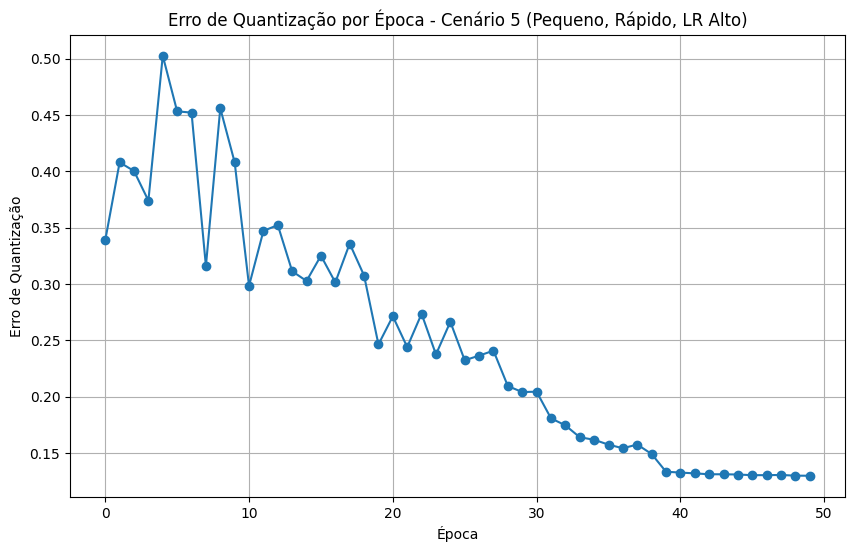


--- Executando Cenário 6 (Médio-Grande, Lento, LR Baixo) (Cenário 7/10) ---
Iniciando treinamento do SOM com 500 iterações...
Iteração 50/500 - eta: 0.1644, sigma: 3.2880
Iteração 100/500 - eta: 0.1346, sigma: 2.6920
Iteração 150/500 - eta: 0.1102, sigma: 2.2040
Iteração 200/500 - eta: 0.0902, sigma: 1.8045
Iteração 250/500 - eta: 0.0739, sigma: 1.4774
Iteração 300/500 - eta: 0.0605, sigma: 1.2096
Iteração 350/500 - eta: 0.0495, sigma: 0.9903
Iteração 400/500 - eta: 0.0405, sigma: 0.8108
Iteração 450/500 - eta: 0.0332, sigma: 0.6638
Iteração 500/500 - eta: 0.0272, sigma: 0.5435
Treinamento concluído.
Erro de Quantização para Cenário 6 (Médio-Grande, Lento, LR Baixo): 0.0813


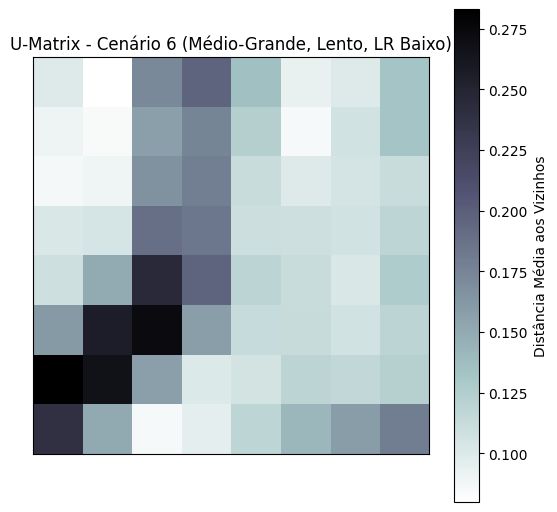

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


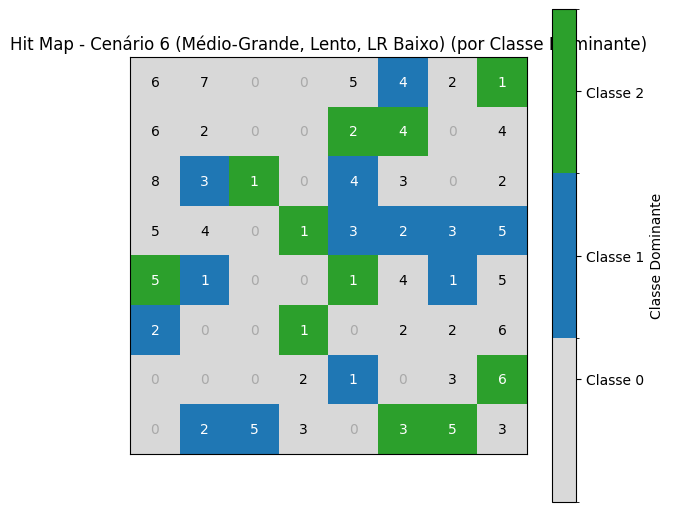

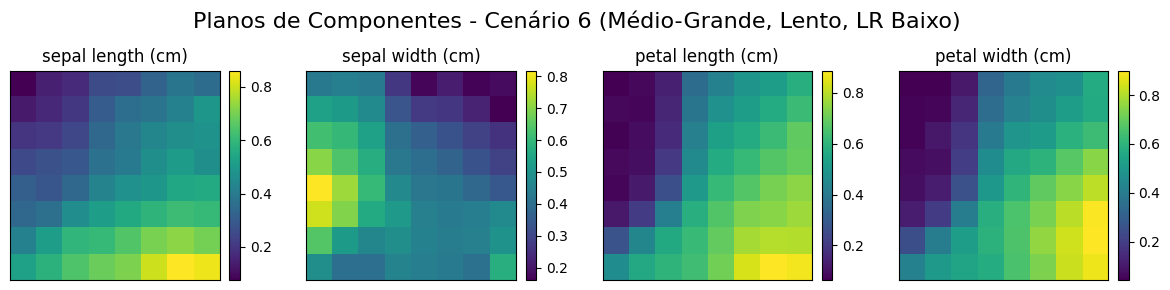

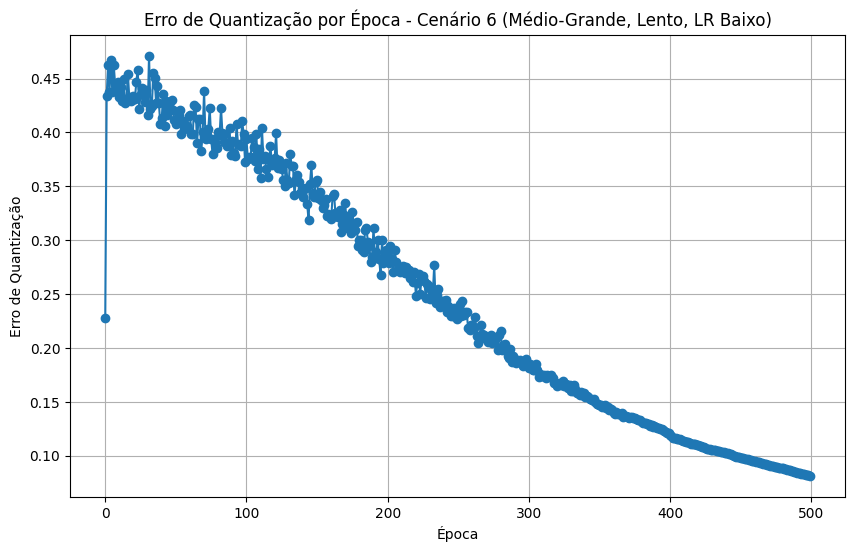


--- Executando Cenário 7 (Constante) (Cenário 8/10) ---
Iniciando treinamento do SOM com 100 iterações...
Iteração 10/100 - eta: 0.5000, sigma: 2.5000
Iteração 20/100 - eta: 0.5000, sigma: 2.5000
Iteração 30/100 - eta: 0.5000, sigma: 2.5000
Iteração 40/100 - eta: 0.5000, sigma: 2.5000
Iteração 50/100 - eta: 0.5000, sigma: 2.5000
Iteração 60/100 - eta: 0.5000, sigma: 2.5000
Iteração 70/100 - eta: 0.5000, sigma: 2.5000
Iteração 80/100 - eta: 0.5000, sigma: 2.5000
Iteração 90/100 - eta: 0.5000, sigma: 2.5000
Iteração 100/100 - eta: 0.5000, sigma: 2.5000
Treinamento concluído.
Erro de Quantização para Cenário 7 (Constante): 0.4465


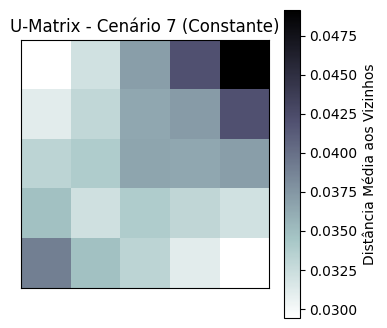

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


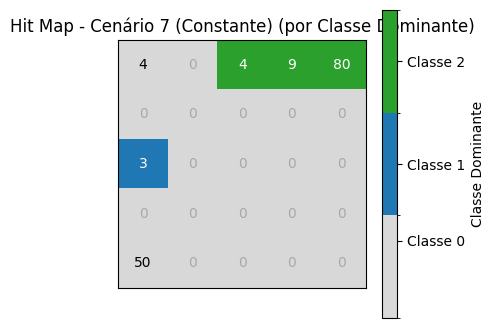

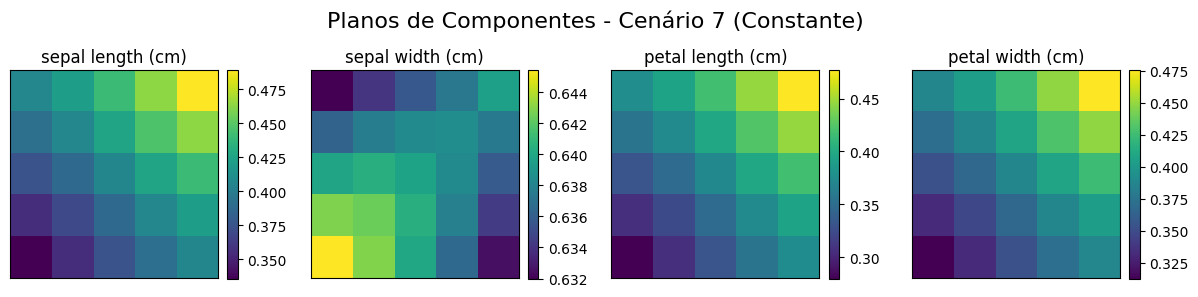

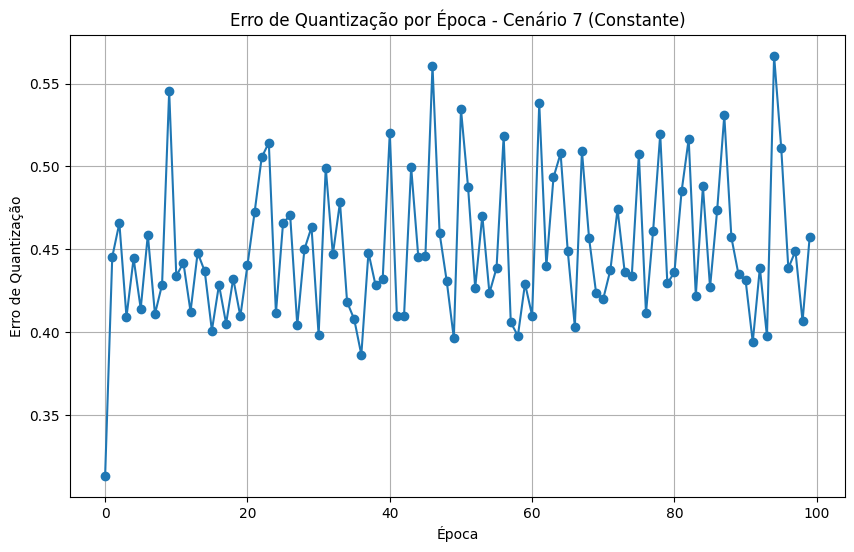


--- Executando Cenário 8 (Grande, Sigma Menor) (Cenário 9/10) ---
Iniciando treinamento do SOM com 250 iterações...
Iteração 25/250 - eta: 0.3616, sigma: 2.7120
Iteração 50/250 - eta: 0.3216, sigma: 2.4120
Iteração 75/250 - eta: 0.2816, sigma: 2.1120
Iteração 100/250 - eta: 0.2416, sigma: 1.8120
Iteração 125/250 - eta: 0.2016, sigma: 1.5120
Iteração 150/250 - eta: 0.1616, sigma: 1.2120
Iteração 175/250 - eta: 0.1216, sigma: 0.9120
Iteração 200/250 - eta: 0.0816, sigma: 0.6120
Iteração 225/250 - eta: 0.0416, sigma: 0.3120
Iteração 250/250 - eta: 0.0016, sigma: 0.0120
Treinamento concluído.
Erro de Quantização para Cenário 8 (Grande, Sigma Menor): 0.0551


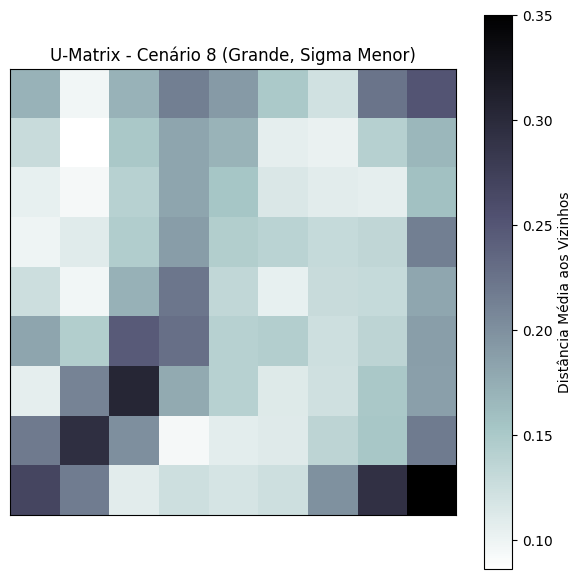

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


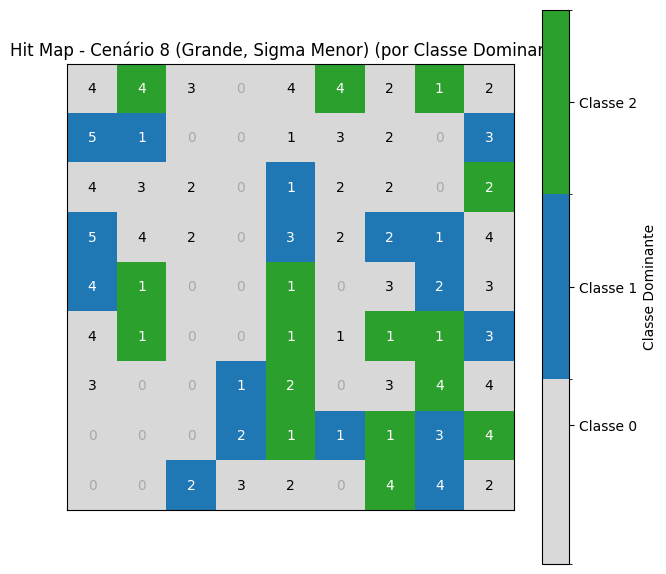

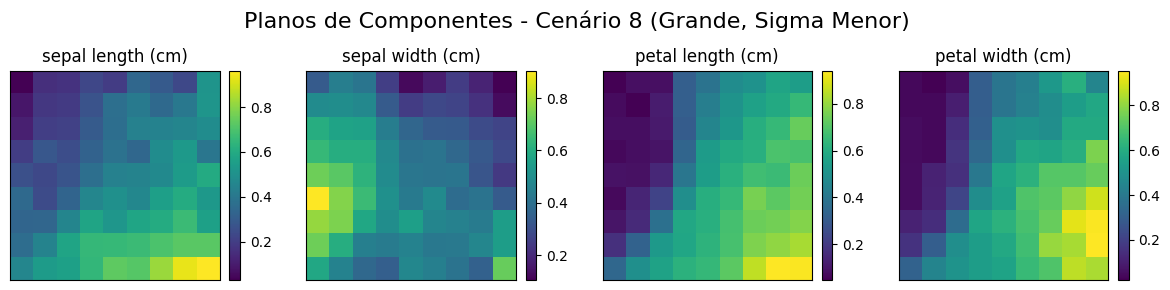

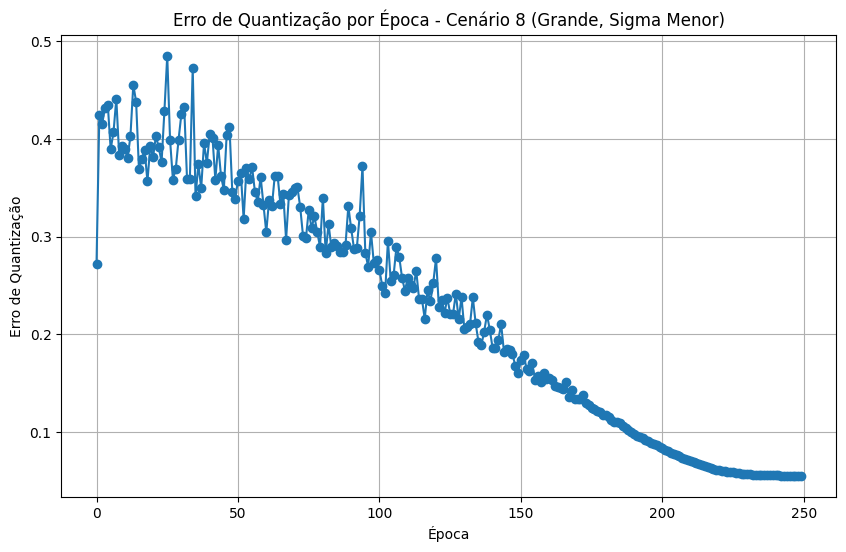


--- Executando Cenário 9 (Retangular, Não-Linear, Sigma Maior) (Cenário 10/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.2481, sigma: 4.1348
Iteração 40/200 - eta: 0.2031, sigma: 3.3853
Iteração 60/200 - eta: 0.1663, sigma: 2.7716
Iteração 80/200 - eta: 0.1362, sigma: 2.2692
Iteração 100/200 - eta: 0.1115, sigma: 1.8579
Iteração 120/200 - eta: 0.0913, sigma: 1.5211
Iteração 140/200 - eta: 0.0747, sigma: 1.2454
Iteração 160/200 - eta: 0.0612, sigma: 1.0196
Iteração 180/200 - eta: 0.0501, sigma: 0.8348
Iteração 200/200 - eta: 0.0410, sigma: 0.6835
Treinamento concluído.
Erro de Quantização para Cenário 9 (Retangular, Não-Linear, Sigma Maior): 0.1140


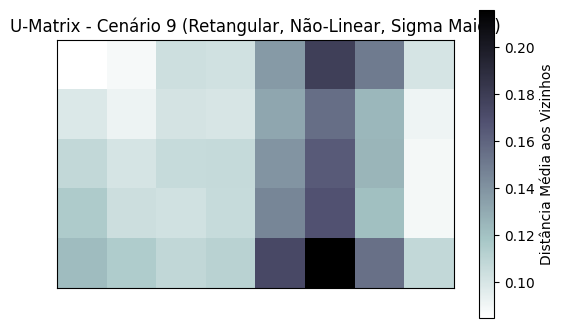

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


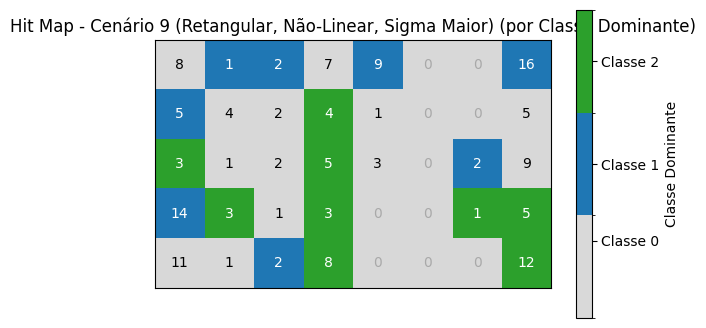

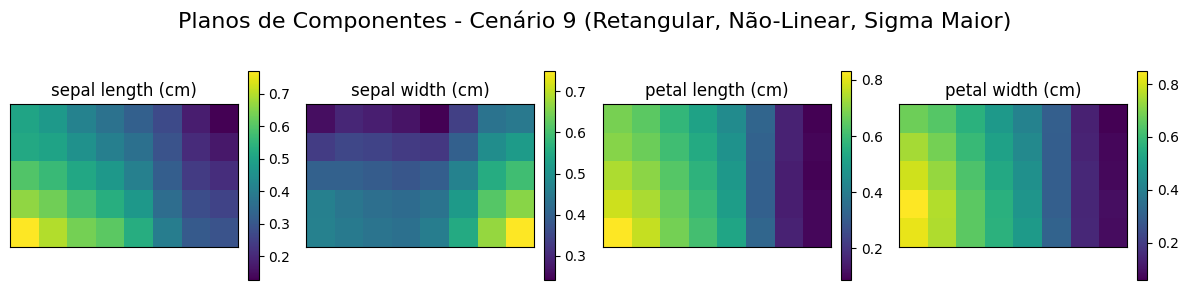

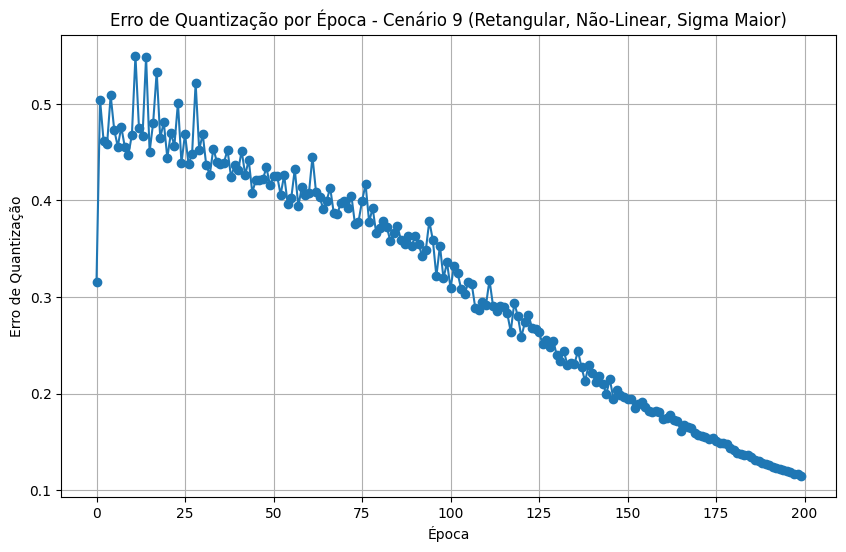


--- Executando Cenário 10 (Muito Grande, Rápido, LR Alto) (Cenário 11/10) ---
Iniciando treinamento do SOM com 100 iterações...
Iteração 10/100 - eta: 0.6370, sigma: 5.4600
Iteração 20/100 - eta: 0.5670, sigma: 4.8600
Iteração 30/100 - eta: 0.4970, sigma: 4.2600
Iteração 40/100 - eta: 0.4270, sigma: 3.6600
Iteração 50/100 - eta: 0.3570, sigma: 3.0600
Iteração 60/100 - eta: 0.2870, sigma: 2.4600
Iteração 70/100 - eta: 0.2170, sigma: 1.8600
Iteração 80/100 - eta: 0.1470, sigma: 1.2600
Iteração 90/100 - eta: 0.0770, sigma: 0.6600
Iteração 100/100 - eta: 0.0070, sigma: 0.0600
Treinamento concluído.
Erro de Quantização para Cenário 10 (Muito Grande, Rápido, LR Alto): 0.0632


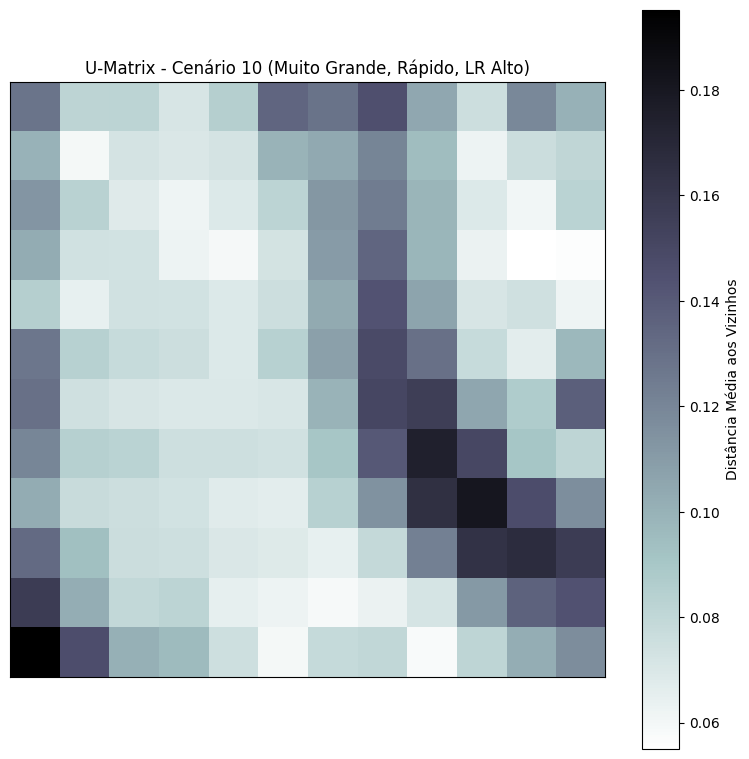

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


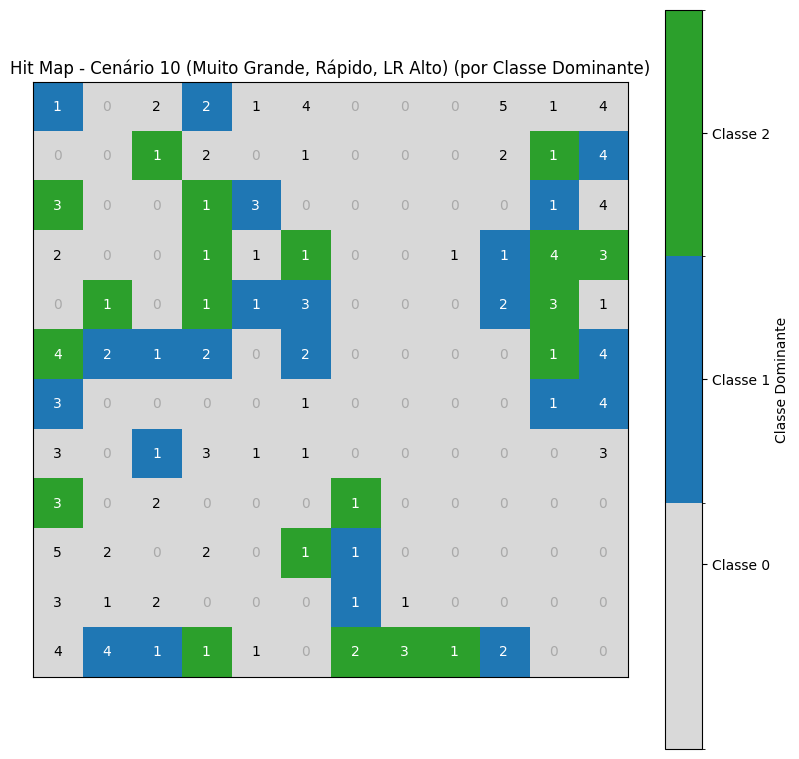

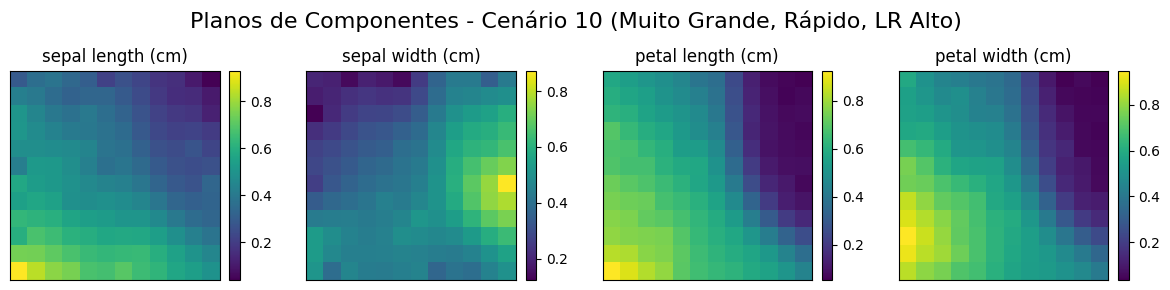

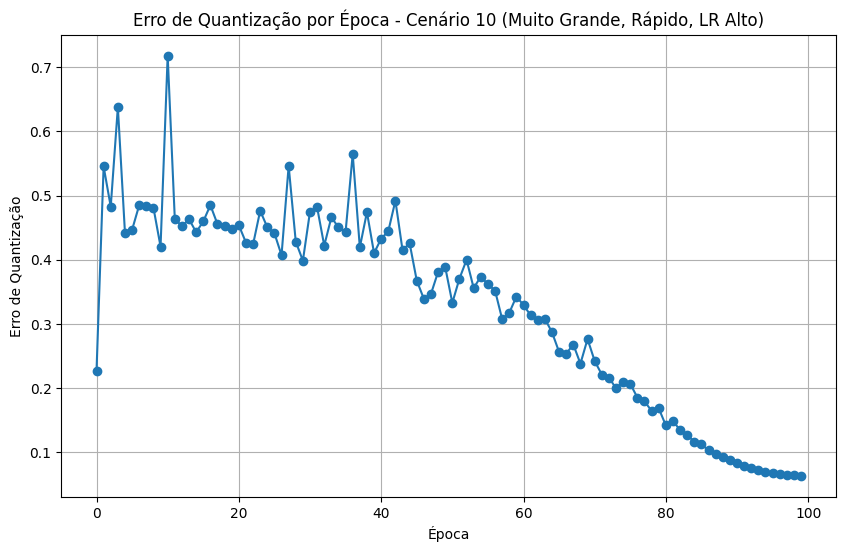


Execução de todos os 10 cenários concluída.
Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.


In [ ]:
# Testes iniciais com tamanho
if __name__ == "__main__":
    # Carregar e normalizar os dados Iris
    dados_iris_normalizados, labels_iris, feature_names_iris, target_names_iris = carregar_e_normalizar_iris()
    print("Shape dos dados normalizados:", dados_iris_normalizados.shape)

    # --- Definição dos 10 Cenários de Hiperparâmetros ---
    scenarios = [
        {"name": "Cenário 0 (Pequeno, Rápido, LR Baixo)", "linhas": 2, "colunas": 2, "iteracoes":100, "taxa_aprendizado_inicial": 0.3, "sigma_inicial": 2.0, "decaimento": 'linear'},
        {"name": "Cenário 1 (Base, Linear)", "linhas": 4, "colunas": 4, "iteracoes": 100, "taxa_aprendizado_inicial": 0.5, "sigma_inicial": 2.0, "decaimento": 'linear'},
        {"name": "Cenário 2 (Médio, Não-Linear)", "linhas": 7, "colunas": 7, "iteracoes": 200, "taxa_aprendizado_inicial": 0.3, "sigma_inicial": 3.5, "decaimento": 'nao-linear'},
        {"name": "Cenário 3 (Grande, Linear)", "linhas": 10, "colunas": 10, "iteracoes": 300, "taxa_aprendizado_inicial": 0.4, "sigma_inicial": 5.0, "decaimento": 'linear'},
        {"name": "Cenário 4 (Retangular, Não-Linear, LR Alto)", "linhas": 6, "colunas": 10, "iteracoes": 150, "taxa_aprendizado_inicial": 0.6, "sigma_inicial": 5.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 5 (Pequeno, Rápido, LR Alto)", "linhas": 3, "colunas": 3, "iteracoes": 50, "taxa_aprendizado_inicial": 0.7, "sigma_inicial": 1.5, "decaimento": 'linear'},
        {"name": "Cenário 6 (Médio-Grande, Lento, LR Baixo)", "linhas": 8, "colunas": 8, "iteracoes": 500, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 4.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 7 (Constante)", "linhas": 5, "colunas": 5, "iteracoes": 100, "taxa_aprendizado_inicial": 0.5, "sigma_inicial": 2.5, "decaimento": 'constante'},
        {"name": "Cenário 8 (Grande, Sigma Menor)", "linhas": 9, "colunas": 9, "iteracoes": 250, "taxa_aprendizado_inicial": 0.4, "sigma_inicial": 3.0, "decaimento": 'linear'},
        {"name": "Cenário 9 (Retangular, Não-Linear, Sigma Maior)", "linhas": 5, "colunas": 8, "iteracoes": 200, "taxa_aprendizado_inicial": 0.3, "sigma_inicial": 5.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 10 (Muito Grande, Rápido, LR Alto)", "linhas": 12, "colunas": 12, "iteracoes": 100, "taxa_aprendizado_inicial": 0.7, "sigma_inicial": 6.0, "decaimento": 'linear'},
    ]

    # --- Execução de cada cenário ---
    for i, scenario in enumerate(scenarios):
        print(f"\n--- Executando {scenario['name']} (Cenário {i+1}/10) ---")

        som_model = SOM(
            linhas=scenario['linhas'],
            colunas=scenario['colunas'],
            iteracoes=scenario['iteracoes'],
            taxa_aprendizado_inicial=scenario['taxa_aprendizado_inicial'],
            sigma_inicial=scenario['sigma_inicial'],
            decaimento=scenario['decaimento']
        )

        # Treinar o modelo (usar uma cópia dos dados para garantir que não haja side-effects entre as rodadas)
        som_model.treinar(dados_iris_normalizados.copy())

        # Calcular e exibir o erro de quantização
        erro_quantizacao = som_model.calcular_erro_quantizacao()
        print(f"Erro de Quantização para {scenario['name']}: {erro_quantizacao:.4f}")

        # Gerar e exibir as visualizações
        som_model.visualizar_umatrix(title=f"U-Matrix - {scenario['name']}")
        som_model.visualizar_hit_map(labels=labels_iris, title=f"Hit Map - {scenario['name']}")
        som_model.visualizar_component_planes(feature_names=feature_names_iris, title=f"Planos de Componentes - {scenario['name']}")

        import matplotlib.pyplot as plt

        # ... (após treinar seu som_model) ...

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(som_model.erros_por_epoca)), som_model.erros_por_epoca, marker='o', linestyle='-')
        plt.title(f"Erro de Quantização por Época - {scenario['name']}")
        plt.xlabel("Época")
        plt.ylabel("Erro de Quantização")
        plt.grid(True)
        plt.show()

    print("\nExecução de todos os 10 cenários concluída.")
    print("Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.")


Shape dos dados normalizados: (150, 4)

--- Executando Cenário 1 (Cenário 1/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.0827, sigma: 3.3078
Iteração 40/200 - eta: 0.0677, sigma: 2.7082
Iteração 60/200 - eta: 0.0554, sigma: 2.2173
Iteração 80/200 - eta: 0.0454, sigma: 1.8154
Iteração 100/200 - eta: 0.0372, sigma: 1.4863
Iteração 120/200 - eta: 0.0304, sigma: 1.2169
Iteração 140/200 - eta: 0.0249, sigma: 0.9963
Iteração 160/200 - eta: 0.0204, sigma: 0.8157
Iteração 180/200 - eta: 0.0167, sigma: 0.6678
Iteração 200/200 - eta: 0.0137, sigma: 0.5468
Treinamento concluído.
Erro de Quantização para Cenário 1: 0.0921


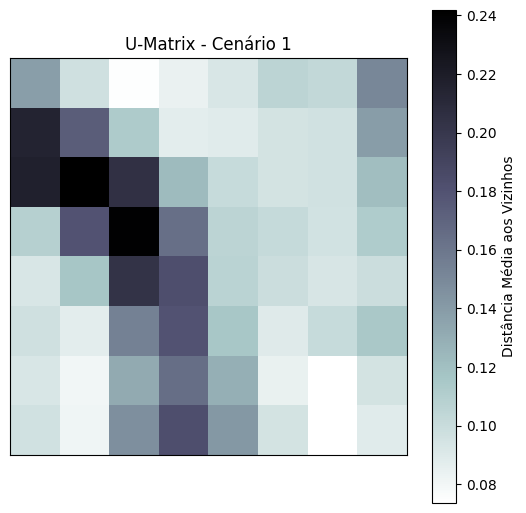

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


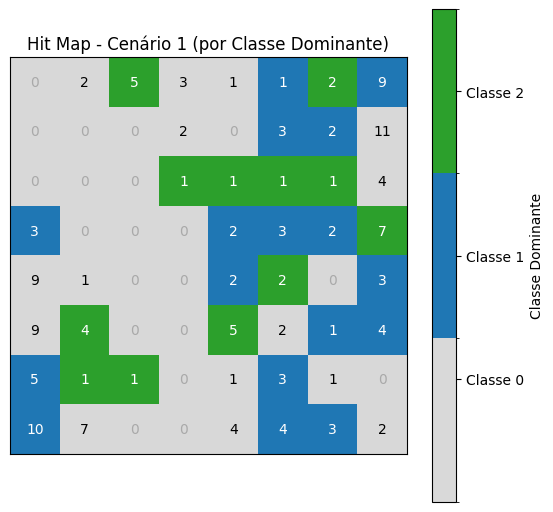

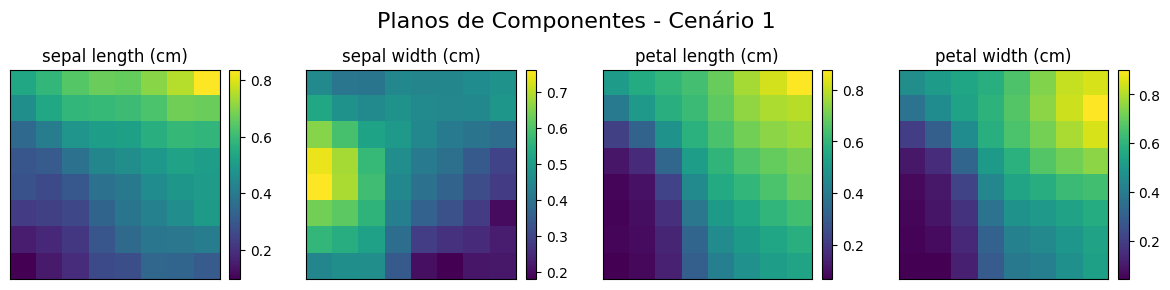

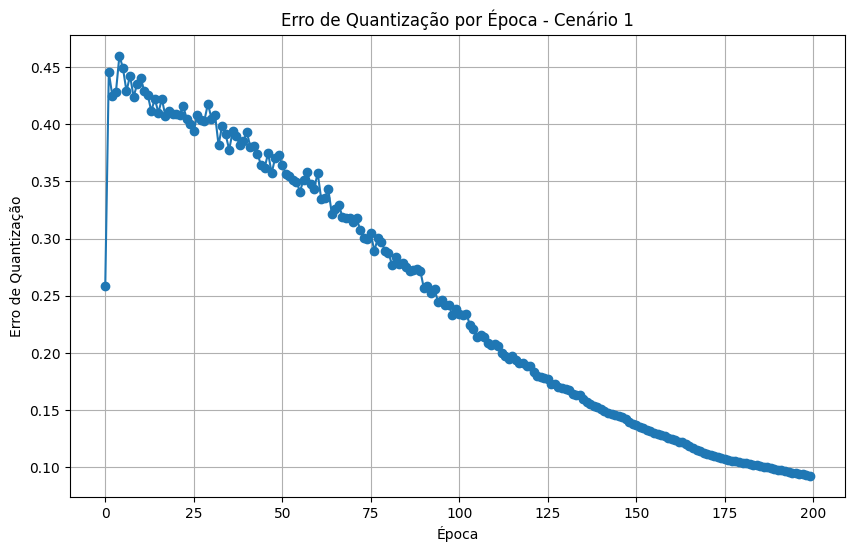


--- Executando Cenário 2 (Cenário 2/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.2481, sigma: 3.3078
Iteração 40/200 - eta: 0.2031, sigma: 2.7082
Iteração 60/200 - eta: 0.1663, sigma: 2.2173
Iteração 80/200 - eta: 0.1362, sigma: 1.8154
Iteração 100/200 - eta: 0.1115, sigma: 1.4863
Iteração 120/200 - eta: 0.0913, sigma: 1.2169
Iteração 140/200 - eta: 0.0747, sigma: 0.9963
Iteração 160/200 - eta: 0.0612, sigma: 0.8157
Iteração 180/200 - eta: 0.0501, sigma: 0.6678
Iteração 200/200 - eta: 0.0410, sigma: 0.5468
Treinamento concluído.
Erro de Quantização para Cenário 2: 0.0827


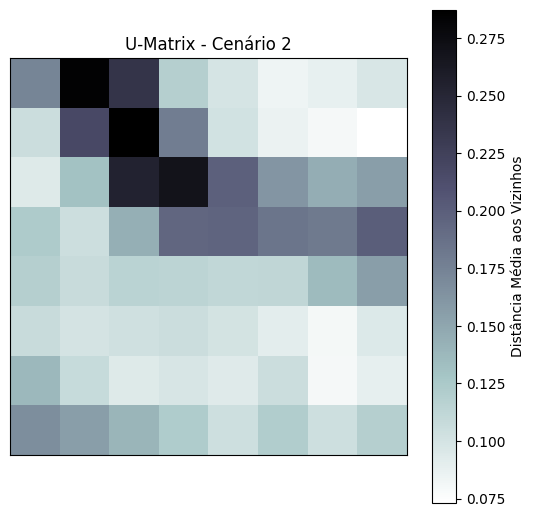

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


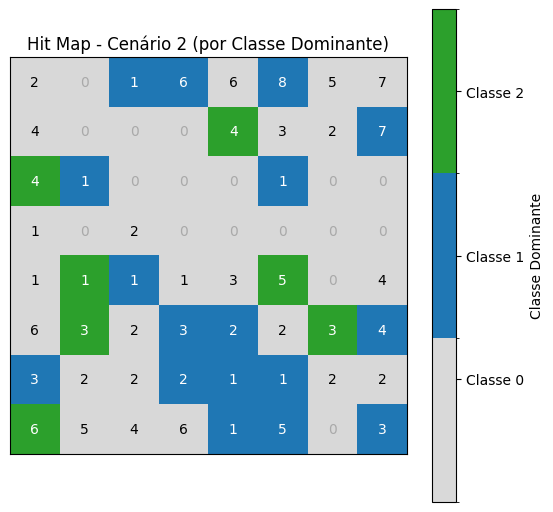

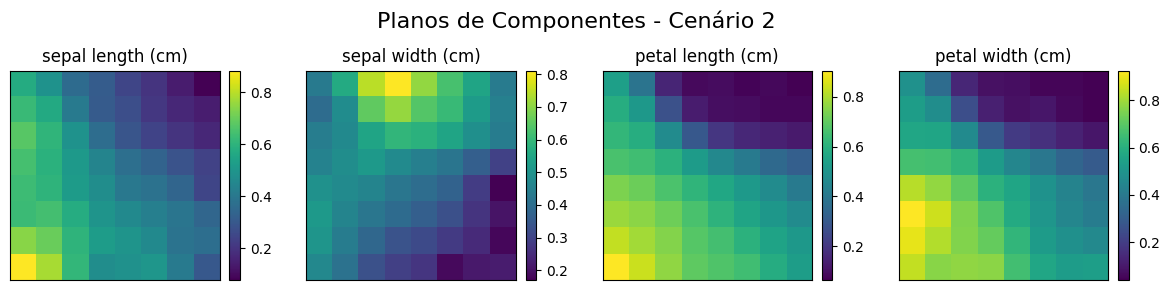

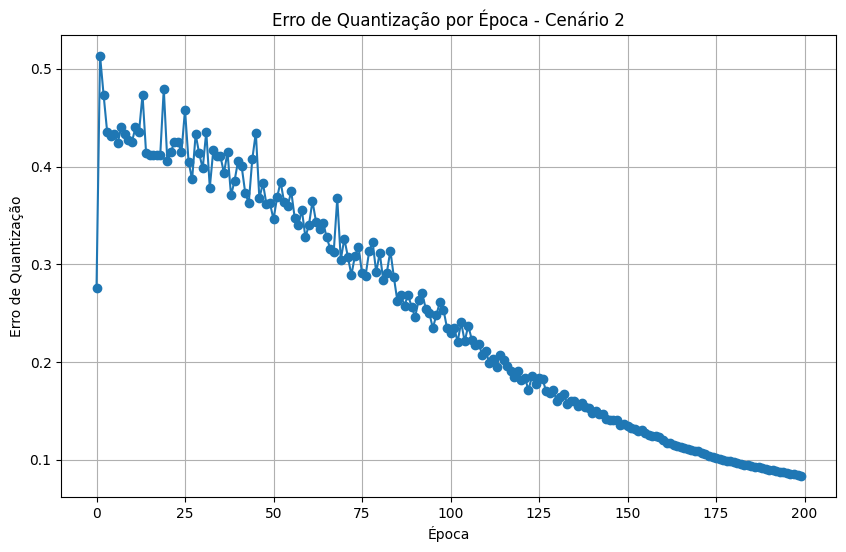


--- Executando Cenário 3 (Cenário 3/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.1654, sigma: 2.8944
Iteração 40/200 - eta: 0.1354, sigma: 2.3697
Iteração 60/200 - eta: 0.1109, sigma: 1.9401
Iteração 80/200 - eta: 0.0908, sigma: 1.5885
Iteração 100/200 - eta: 0.0743, sigma: 1.3005
Iteração 120/200 - eta: 0.0608, sigma: 1.0648
Iteração 140/200 - eta: 0.0498, sigma: 0.8718
Iteração 160/200 - eta: 0.0408, sigma: 0.7137
Iteração 180/200 - eta: 0.0334, sigma: 0.5844
Iteração 200/200 - eta: 0.0273, sigma: 0.4784
Treinamento concluído.
Erro de Quantização para Cenário 3: 0.0868


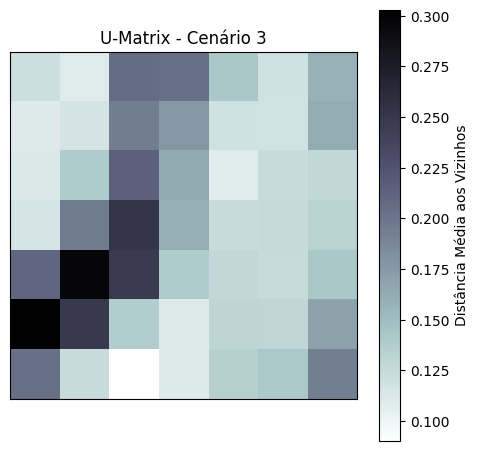

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


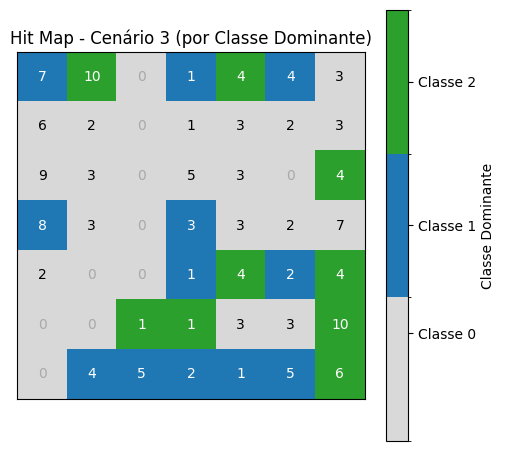

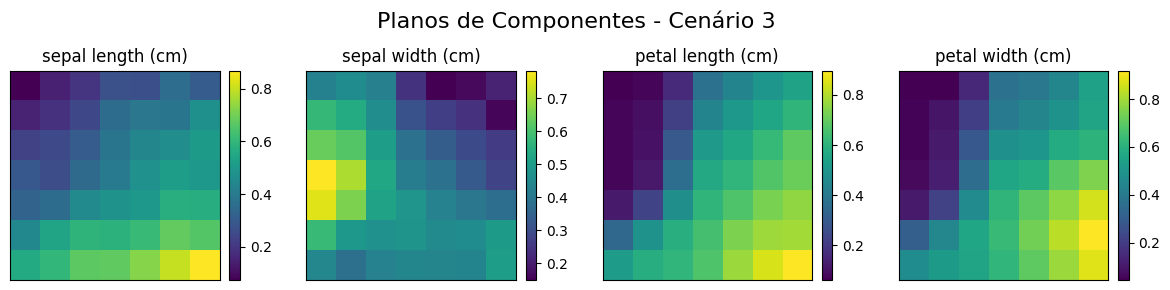

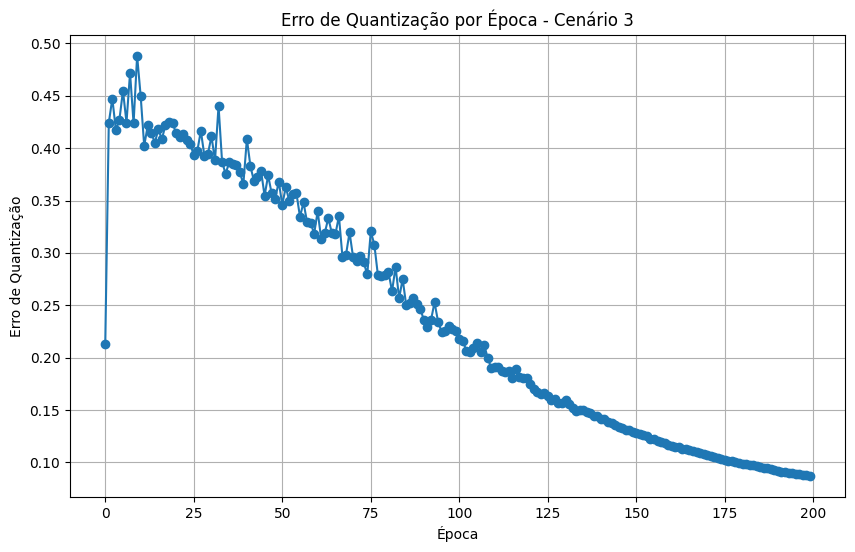


--- Executando Cenário 4 (Cenário 4/10) ---
Iniciando treinamento do SOM com 300 iterações...
Iteração 30/300 - eta: 0.1648, sigma: 4.1210
Iteração 60/300 - eta: 0.1350, sigma: 3.3740
Iteração 90/300 - eta: 0.1105, sigma: 2.7624
Iteração 120/300 - eta: 0.0905, sigma: 2.2617
Iteração 150/300 - eta: 0.0741, sigma: 1.8517
Iteração 180/300 - eta: 0.0606, sigma: 1.5160
Iteração 210/300 - eta: 0.0496, sigma: 1.2412
Iteração 240/300 - eta: 0.0406, sigma: 1.0162
Iteração 270/300 - eta: 0.0333, sigma: 0.8320
Iteração 300/300 - eta: 0.0272, sigma: 0.6812
Treinamento concluído.
Erro de Quantização para Cenário 4: 0.0893


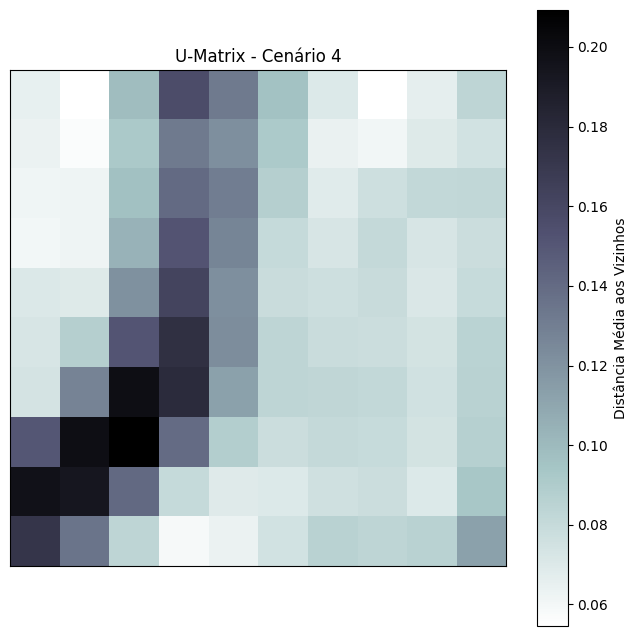

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


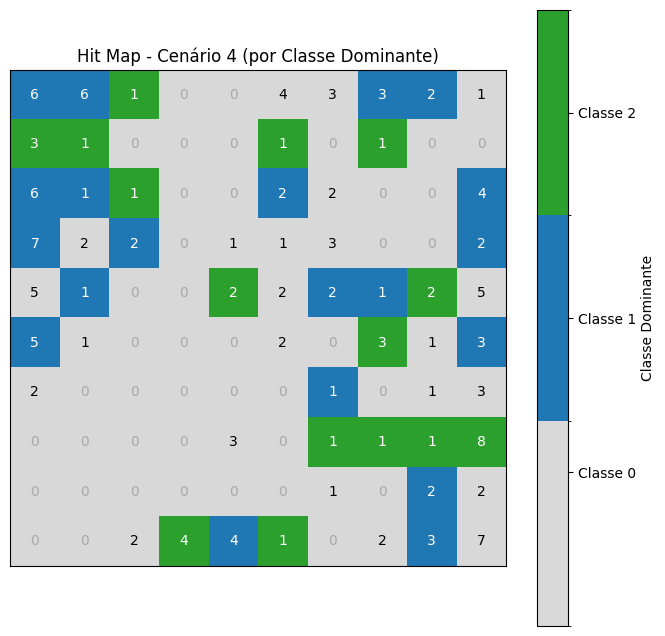

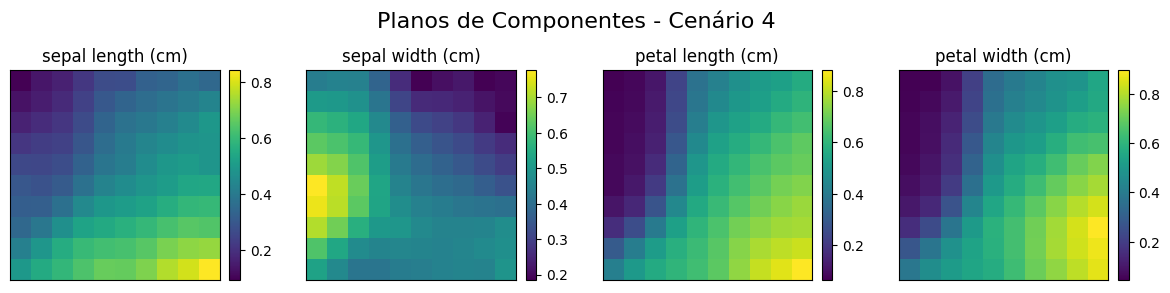

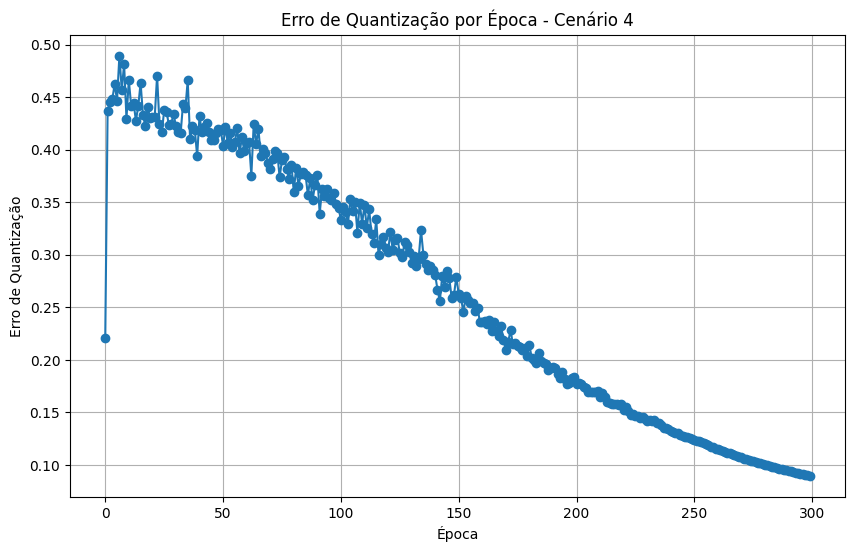


--- Executando Cenário 5 (Cenário 5/10) ---
Iniciando treinamento do SOM com 150 iterações...
Iteração 15/150 - eta: 0.2489, sigma: 2.4892
Iteração 30/150 - eta: 0.2038, sigma: 2.0380
Iteração 45/150 - eta: 0.1669, sigma: 1.6685
Iteração 60/150 - eta: 0.1366, sigma: 1.3661
Iteração 75/150 - eta: 0.1118, sigma: 1.1185
Iteração 90/150 - eta: 0.0916, sigma: 0.9157
Iteração 105/150 - eta: 0.0750, sigma: 0.7497
Iteração 120/150 - eta: 0.0614, sigma: 0.6138
Iteração 135/150 - eta: 0.0503, sigma: 0.5026
Iteração 150/150 - eta: 0.0411, sigma: 0.4115
Treinamento concluído.
Erro de Quantização para Cenário 5: 0.0865


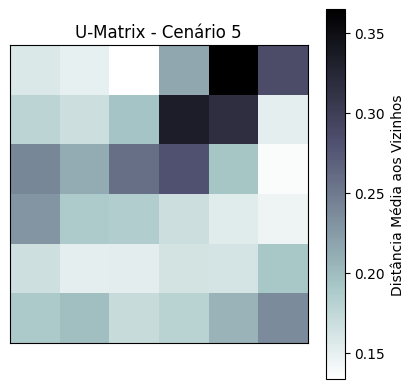

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


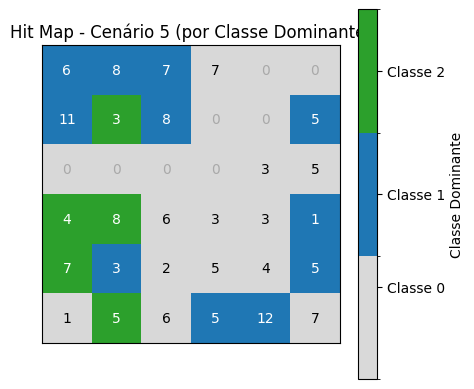

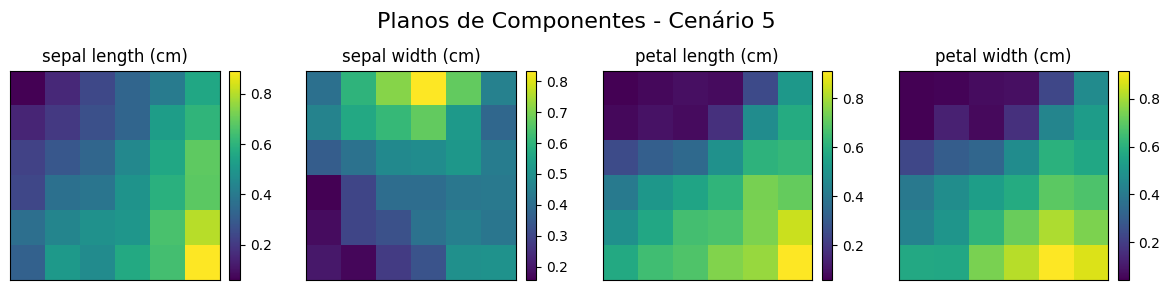

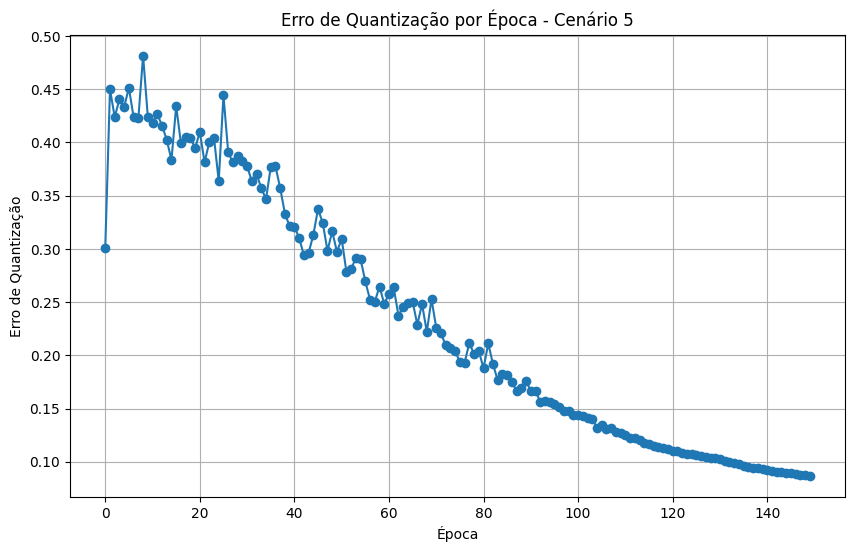


--- Executando Cenário 6 (Cenário 6/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.4135, sigma: 2.4809
Iteração 40/200 - eta: 0.3385, sigma: 2.0312
Iteração 60/200 - eta: 0.2772, sigma: 1.6630
Iteração 80/200 - eta: 0.2269, sigma: 1.3615
Iteração 100/200 - eta: 0.1858, sigma: 1.1147
Iteração 120/200 - eta: 0.1521, sigma: 0.9127
Iteração 140/200 - eta: 0.1245, sigma: 0.7472
Iteração 160/200 - eta: 0.1020, sigma: 0.6118
Iteração 180/200 - eta: 0.0835, sigma: 0.5009
Iteração 200/200 - eta: 0.0683, sigma: 0.4101
Treinamento concluído.
Erro de Quantização para Cenário 6: 0.0653


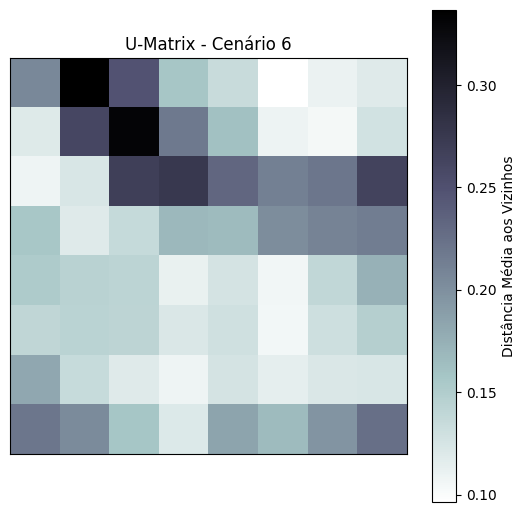

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


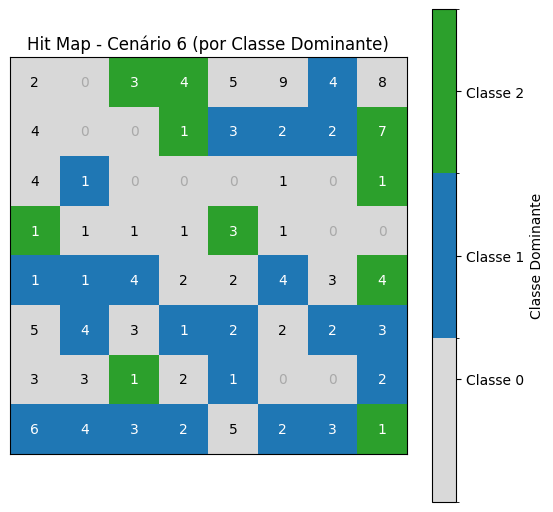

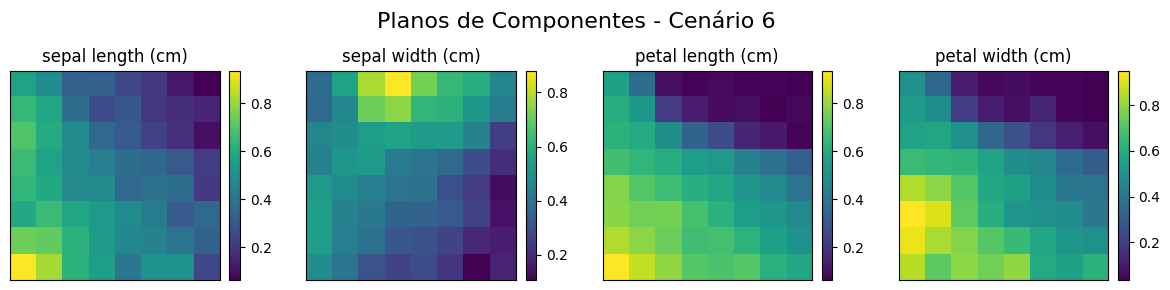

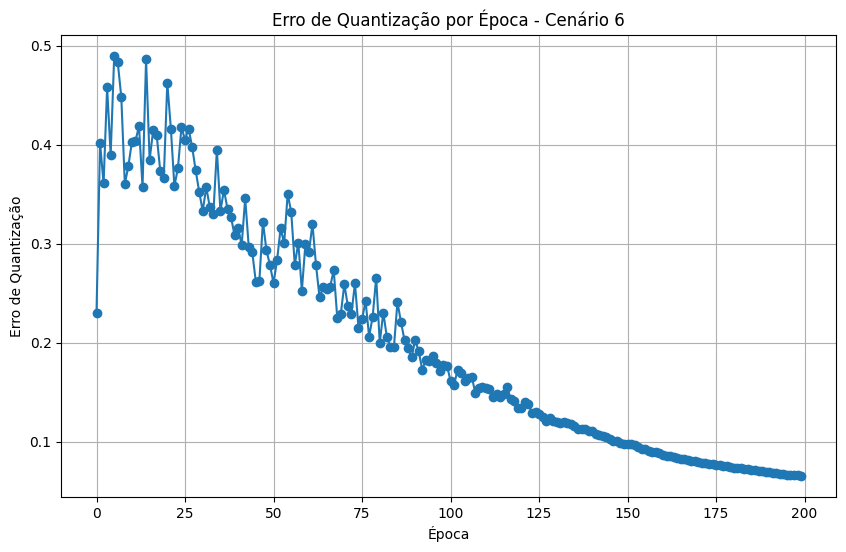


--- Executando Cenário 7  (Cenário 7/10) ---
Iniciando treinamento do SOM com 300 iterações...
Iteração 30/300 - eta: 0.1648, sigma: 3.2968
Iteração 60/300 - eta: 0.1350, sigma: 2.6992
Iteração 90/300 - eta: 0.1105, sigma: 2.2099
Iteração 120/300 - eta: 0.0905, sigma: 1.8093
Iteração 150/300 - eta: 0.0741, sigma: 1.4814
Iteração 180/300 - eta: 0.0606, sigma: 1.2128
Iteração 210/300 - eta: 0.0496, sigma: 0.9930
Iteração 240/300 - eta: 0.0406, sigma: 0.8130
Iteração 270/300 - eta: 0.0333, sigma: 0.6656
Iteração 300/300 - eta: 0.0272, sigma: 0.5450
Treinamento concluído.
Erro de Quantização para Cenário 7 : 0.0753


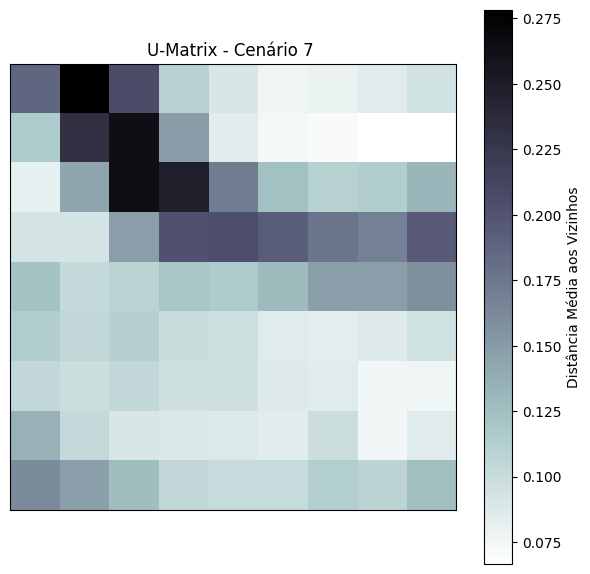

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


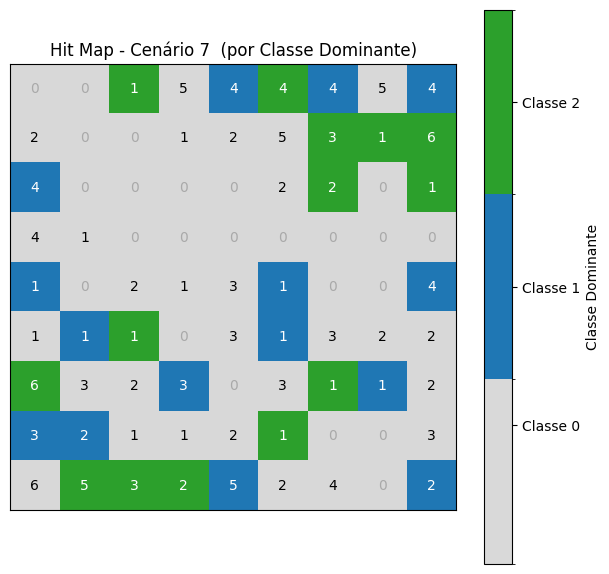

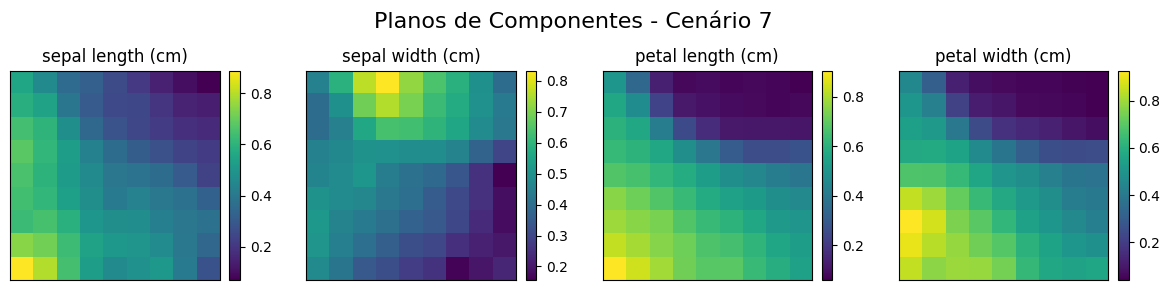

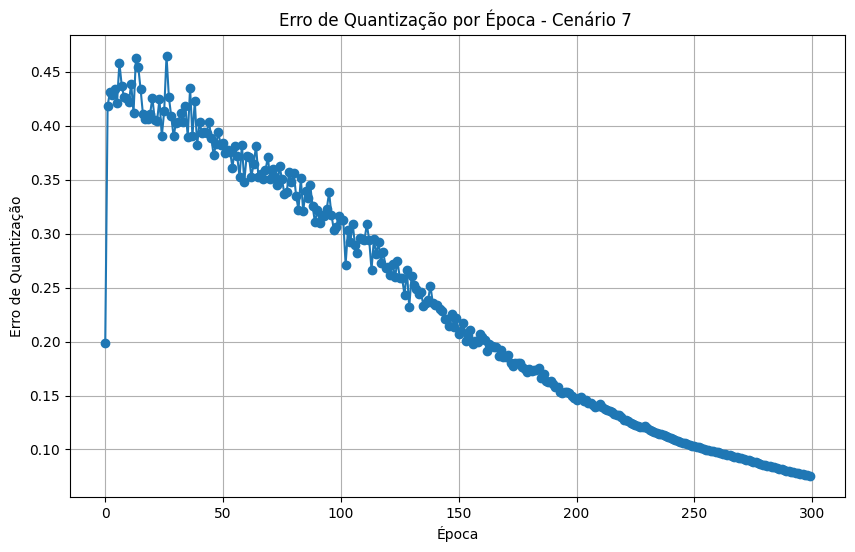


--- Executando Cenário 8 (Cenário 8/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.4135, sigma: 2.0674
Iteração 40/200 - eta: 0.3385, sigma: 1.6926
Iteração 60/200 - eta: 0.2772, sigma: 1.3858
Iteração 80/200 - eta: 0.2269, sigma: 1.1346
Iteração 100/200 - eta: 0.1858, sigma: 0.9289
Iteração 120/200 - eta: 0.1521, sigma: 0.7606
Iteração 140/200 - eta: 0.1245, sigma: 0.6227
Iteração 160/200 - eta: 0.1020, sigma: 0.5098
Iteração 180/200 - eta: 0.0835, sigma: 0.4174
Iteração 200/200 - eta: 0.0683, sigma: 0.3417
Treinamento concluído.
Erro de Quantização para Cenário 8: 0.0657


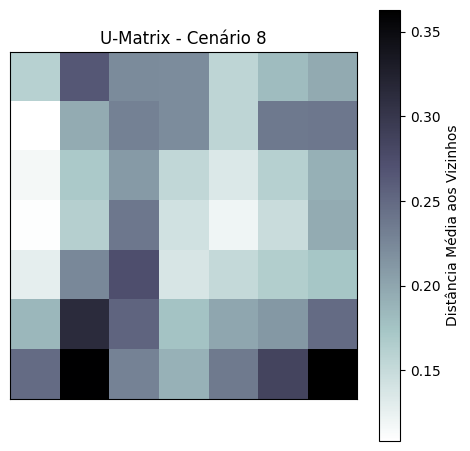

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


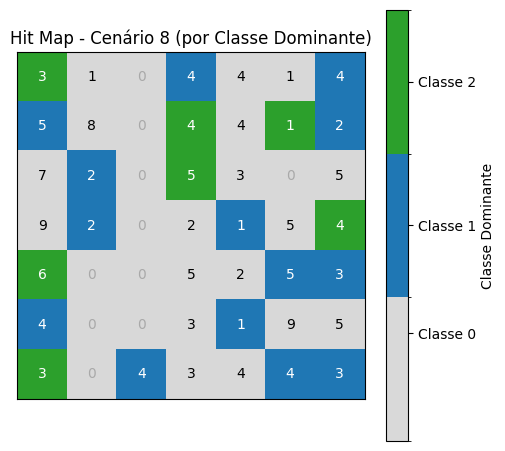

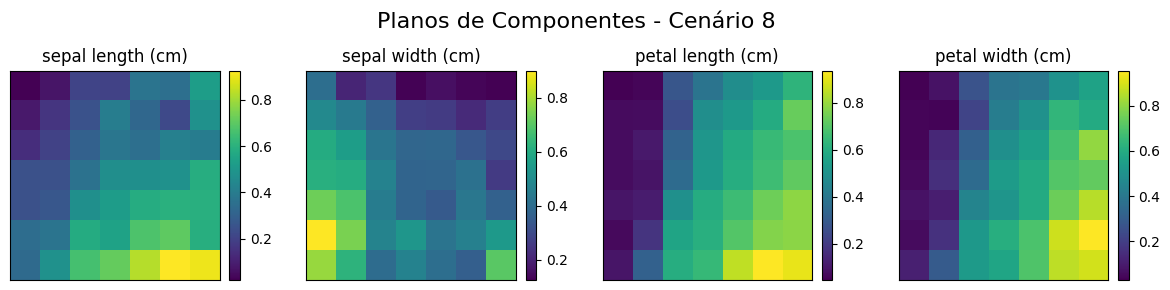

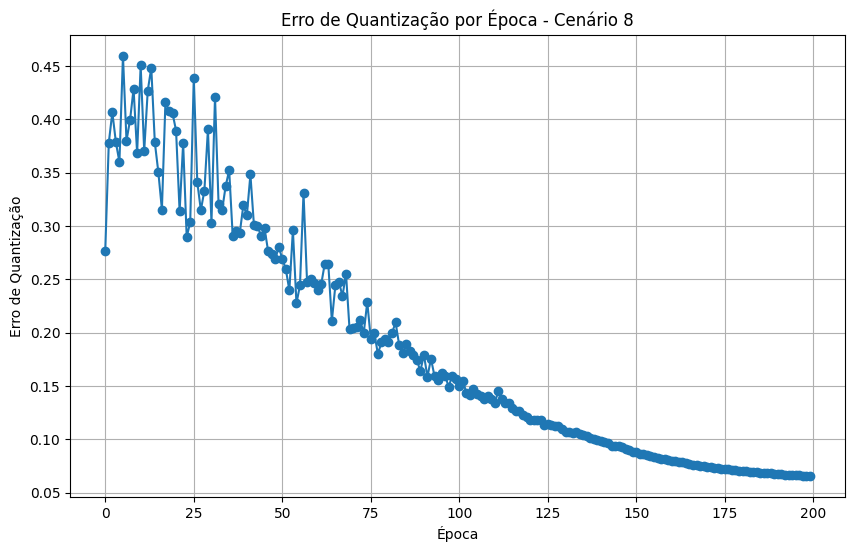


--- Executando Cenário 9 (Cenário 9/10) ---
Iniciando treinamento do SOM com 250 iterações...
Iteração 25/250 - eta: 0.3301, sigma: 3.7139
Iteração 50/250 - eta: 0.2703, sigma: 3.0407
Iteração 75/250 - eta: 0.2213, sigma: 2.4895
Iteração 100/250 - eta: 0.1812, sigma: 2.0382
Iteração 125/250 - eta: 0.1483, sigma: 1.6688
Iteração 150/250 - eta: 0.1214, sigma: 1.3663
Iteração 175/250 - eta: 0.0994, sigma: 1.1186
Iteração 200/250 - eta: 0.0814, sigma: 0.9158
Iteração 225/250 - eta: 0.0667, sigma: 0.7498
Iteração 250/250 - eta: 0.0546, sigma: 0.6139
Treinamento concluído.
Erro de Quantização para Cenário 9: 0.0823


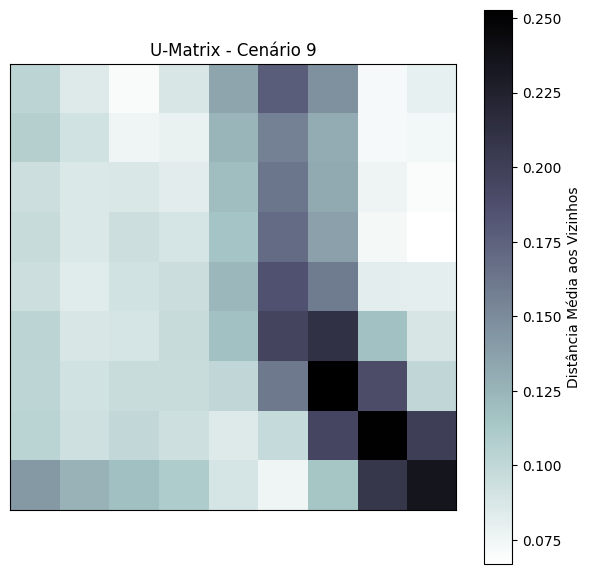

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


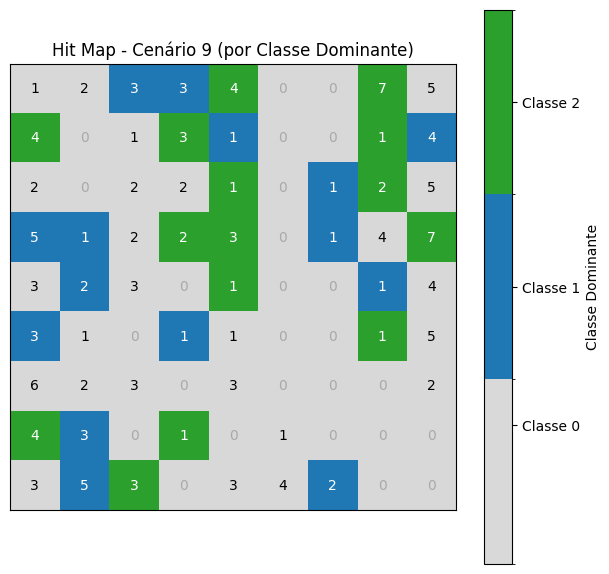

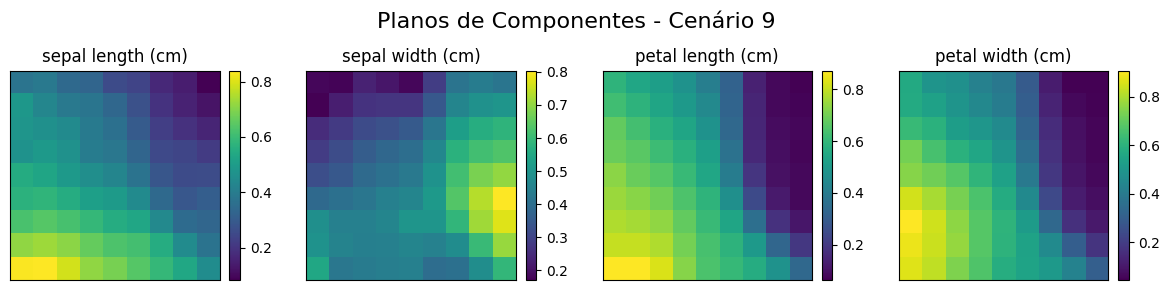

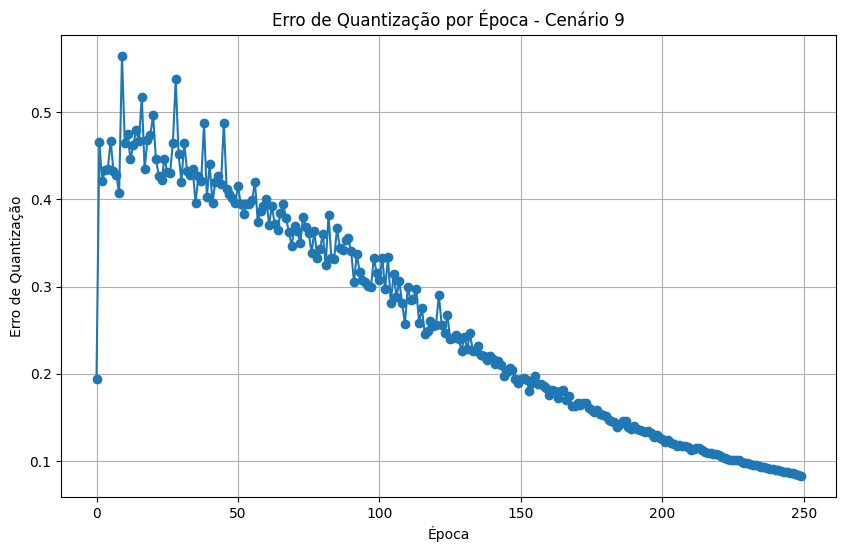


--- Executando Cenário 10 (Cenário 10/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.2481, sigma: 2.4809
Iteração 40/200 - eta: 0.2031, sigma: 2.0312
Iteração 60/200 - eta: 0.1663, sigma: 1.6630
Iteração 80/200 - eta: 0.1362, sigma: 1.3615
Iteração 100/200 - eta: 0.1115, sigma: 1.1147
Iteração 120/200 - eta: 0.0913, sigma: 0.9127
Iteração 140/200 - eta: 0.0747, sigma: 0.7472
Iteração 160/200 - eta: 0.0612, sigma: 0.6118
Iteração 180/200 - eta: 0.0501, sigma: 0.5009
Iteração 200/200 - eta: 0.0410, sigma: 0.4101
Treinamento concluído.
Erro de Quantização para Cenário 10: 0.0672


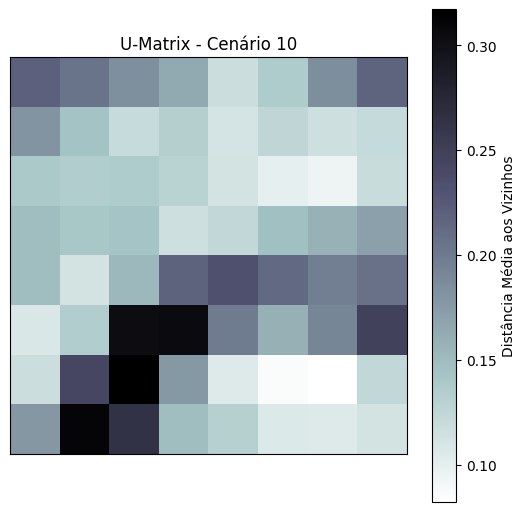

/tmp/ipython-input-2-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


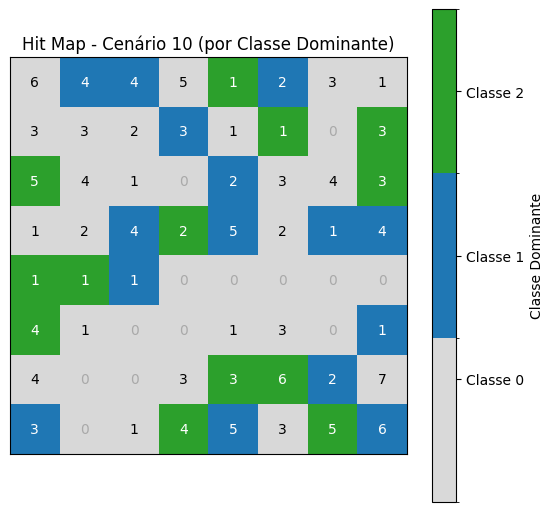

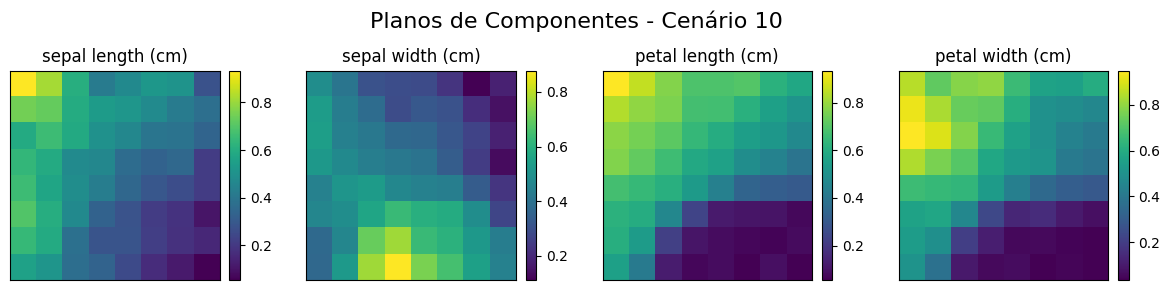

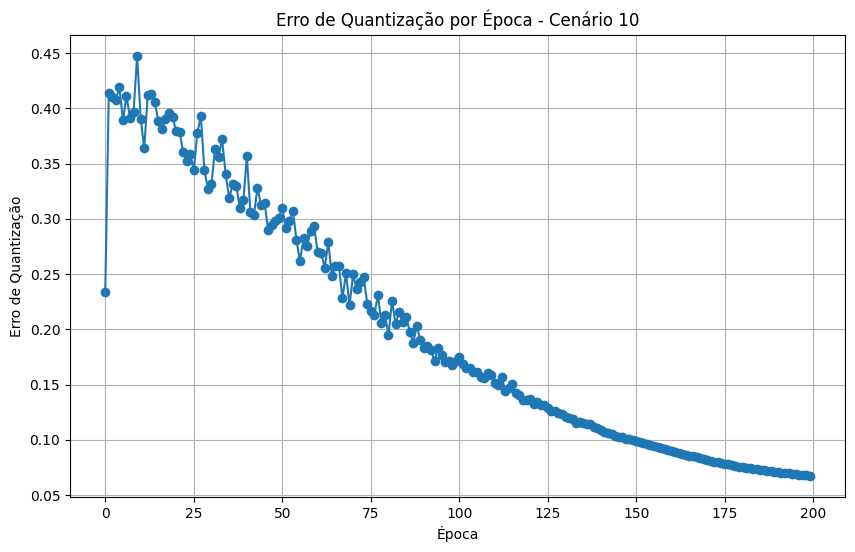


Execução de todos os 10 cenários concluída.
Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.


In [ ]:
# Testes iniciais com tamanho entre 7 e 10
if __name__ == "__main__":
    # Carregar e normalizar os dados Iris
    dados_iris_normalizados, labels_iris, feature_names_iris, target_names_iris = carregar_e_normalizar_iris()
    print("Shape dos dados normalizados:", dados_iris_normalizados.shape)

    # --- Definição dos 10 Cenários de Hiperparâmetros ---
    scenarios = [
        {"name": "Cenário 1", "linhas": 8, "colunas": 8, "iteracoes":200, "taxa_aprendizado_inicial": 0.1, "sigma_inicial": 4.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 2", "linhas": 8, "colunas": 8, "iteracoes": 200, "taxa_aprendizado_inicial": 0.3, "sigma_inicial": 4.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 3", "linhas": 7, "colunas": 7, "iteracoes": 200, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 3.5, "decaimento": 'nao-linear'},
        {"name": "Cenário 4", "linhas": 10, "colunas": 10, "iteracoes": 300, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 5.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 5", "linhas": 6, "colunas": 6, "iteracoes": 150, "taxa_aprendizado_inicial": 0.3, "sigma_inicial": 3.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 6", "linhas": 8, "colunas": 8, "iteracoes": 200, "taxa_aprendizado_inicial": 0.5, "sigma_inicial": 3.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 7 ", "linhas": 9, "colunas": 9, "iteracoes": 300, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 4.0, "decaimento": 'nao-linear'},
        {"name": "Cenário 8", "linhas": 7, "colunas": 7, "iteracoes": 200, "taxa_aprendizado_inicial": 0.5, "sigma_inicial": 2.5, "decaimento": 'nao-linear'},
        {"name": "Cenário 9", "linhas": 9, "colunas": 9, "iteracoes": 250, "taxa_aprendizado_inicial": 0.4, "sigma_inicial": 4.5, "decaimento": 'nao-linear'},
        {"name": "Cenário 10", "linhas": 8, "colunas": 8, "iteracoes": 200, "taxa_aprendizado_inicial": 0.3, "sigma_inicial": 3.0, "decaimento": 'nao-linear'},
    ]

    # --- Execução de cada cenário ---
    for i, scenario in enumerate(scenarios):
        print(f"\n--- Executando {scenario['name']} (Cenário {i+1}/10) ---")

        som_model = SOM(
            linhas=scenario['linhas'],
            colunas=scenario['colunas'],
            iteracoes=scenario['iteracoes'],
            taxa_aprendizado_inicial=scenario['taxa_aprendizado_inicial'],
            sigma_inicial=scenario['sigma_inicial'],
            decaimento=scenario['decaimento']
        )

        # Treinar o modelo (usar uma cópia dos dados para garantir que não haja side-effects entre as rodadas)
        som_model.treinar(dados_iris_normalizados.copy())

        # Calcular e exibir o erro de quantização
        erro_quantizacao = som_model.calcular_erro_quantizacao()
        print(f"Erro de Quantização para {scenario['name']}: {erro_quantizacao:.4f}")

        # Gerar e exibir as visualizações
        som_model.visualizar_umatrix(title=f"U-Matrix - {scenario['name']}")
        som_model.visualizar_hit_map(labels=labels_iris, title=f"Hit Map - {scenario['name']}")
        som_model.visualizar_component_planes(feature_names=feature_names_iris, title=f"Planos de Componentes - {scenario['name']}")

        import matplotlib.pyplot as plt

        # ... (após treinar seu som_model) ...

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(som_model.erros_por_epoca)), som_model.erros_por_epoca, marker='o', linestyle='-')
        plt.title(f"Erro de Quantização por Época - {scenario['name']}")
        plt.xlabel("Época")
        plt.ylabel("Erro de Quantização")
        plt.grid(True)
        plt.show()

    print("\nExecução de todos os 10 cenários concluída.")
    print("Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.")

Shape dos dados normalizados: (150, 4)

--- Executando Cenário Menor 1 (2x2, Épocas Baixas) (Cenário 1/10) ---
Iniciando treinamento do SOM com 150 iterações...
Iteração 15/150 - eta: 0.1813, sigma: 0.9067
Iteração 30/150 - eta: 0.1613, sigma: 0.8067
Iteração 45/150 - eta: 0.1413, sigma: 0.7067
Iteração 60/150 - eta: 0.1213, sigma: 0.6067
Iteração 75/150 - eta: 0.1013, sigma: 0.5067
Iteração 90/150 - eta: 0.0813, sigma: 0.4067
Iteração 105/150 - eta: 0.0613, sigma: 0.3067
Iteração 120/150 - eta: 0.0413, sigma: 0.2067
Iteração 135/150 - eta: 0.0213, sigma: 0.1067
Iteração 150/150 - eta: 0.0013, sigma: 0.0067
Treinamento concluído.
Erro de Quantização para Cenário Menor 1 (2x2, Épocas Baixas): 0.1732


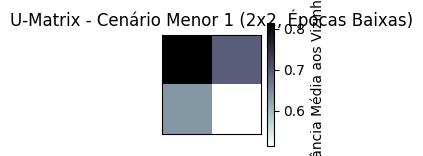

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


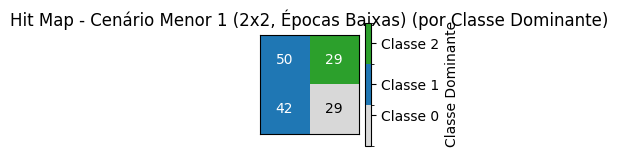

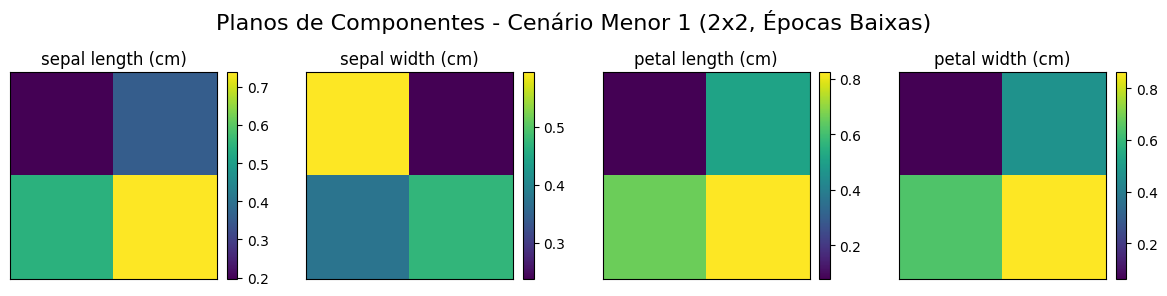

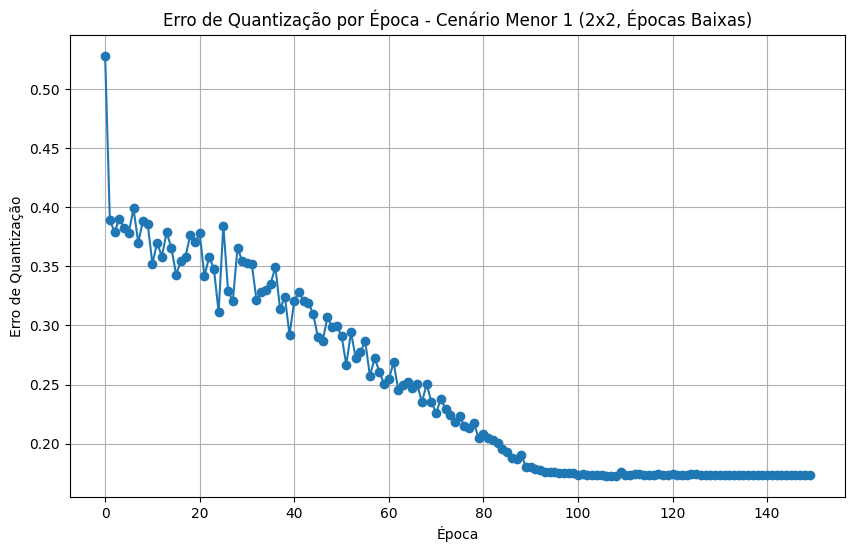


--- Executando Cenário Menor 2 (2x2, Épocas Médias) (Cenário 2/10) ---
Iniciando treinamento do SOM com 300 iterações...
Iteração 30/300 - eta: 0.1355, sigma: 1.3550
Iteração 60/300 - eta: 0.1205, sigma: 1.2050
Iteração 90/300 - eta: 0.1055, sigma: 1.0550
Iteração 120/300 - eta: 0.0905, sigma: 0.9050
Iteração 150/300 - eta: 0.0755, sigma: 0.7550
Iteração 180/300 - eta: 0.0605, sigma: 0.6050
Iteração 210/300 - eta: 0.0455, sigma: 0.4550
Iteração 240/300 - eta: 0.0305, sigma: 0.3050
Iteração 270/300 - eta: 0.0155, sigma: 0.1550
Iteração 300/300 - eta: 0.0005, sigma: 0.0050
Treinamento concluído.
Erro de Quantização para Cenário Menor 2 (2x2, Épocas Médias): 0.1732


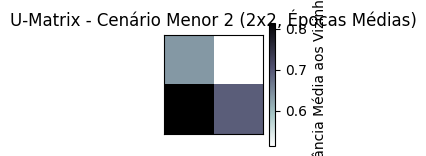

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


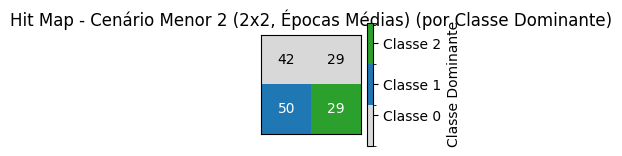

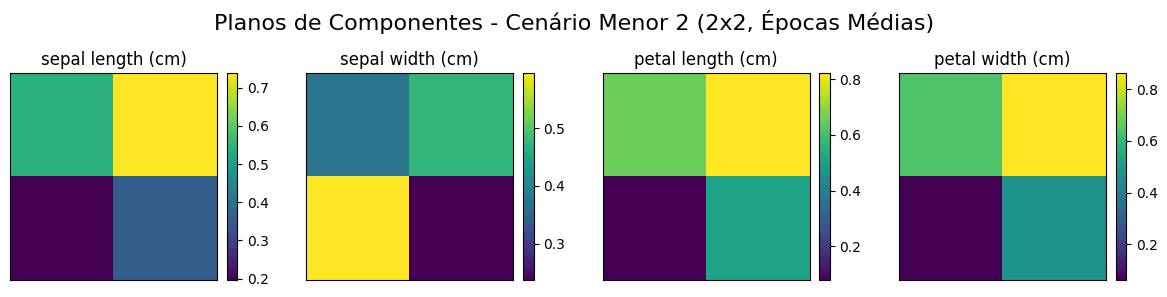

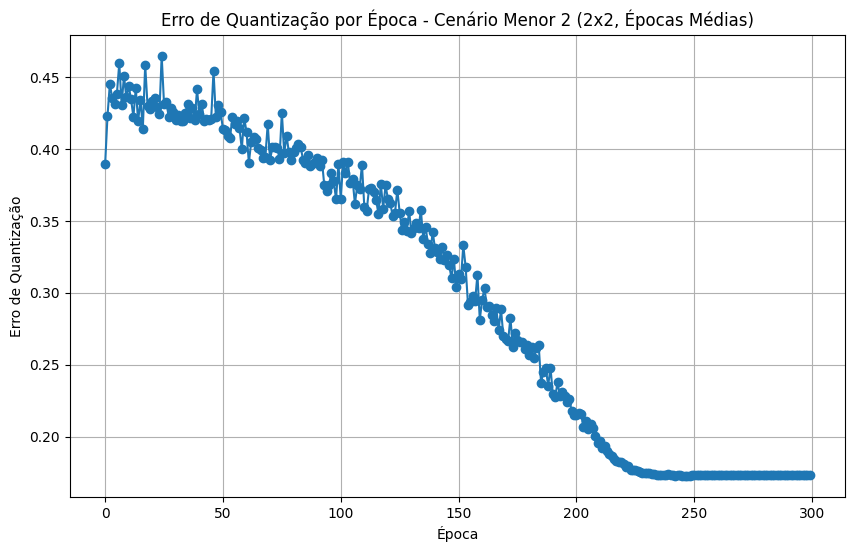


--- Executando Cenário Menor 3 (2x3, LR Mais Alto) (Cenário 3/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.2263, sigma: 1.0860
Iteração 40/200 - eta: 0.2012, sigma: 0.9660
Iteração 60/200 - eta: 0.1763, sigma: 0.8460
Iteração 80/200 - eta: 0.1512, sigma: 0.7260
Iteração 100/200 - eta: 0.1263, sigma: 0.6060
Iteração 120/200 - eta: 0.1013, sigma: 0.4860
Iteração 140/200 - eta: 0.0763, sigma: 0.3660
Iteração 160/200 - eta: 0.0512, sigma: 0.2460
Iteração 180/200 - eta: 0.0262, sigma: 0.1260
Iteração 200/200 - eta: 0.0013, sigma: 0.0060
Treinamento concluído.
Erro de Quantização para Cenário Menor 3 (2x3, LR Mais Alto): 0.1472


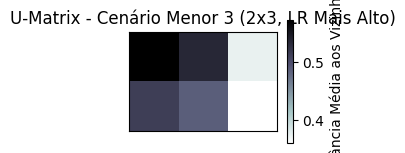

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


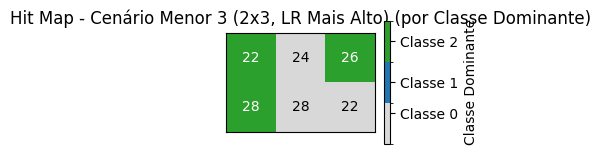

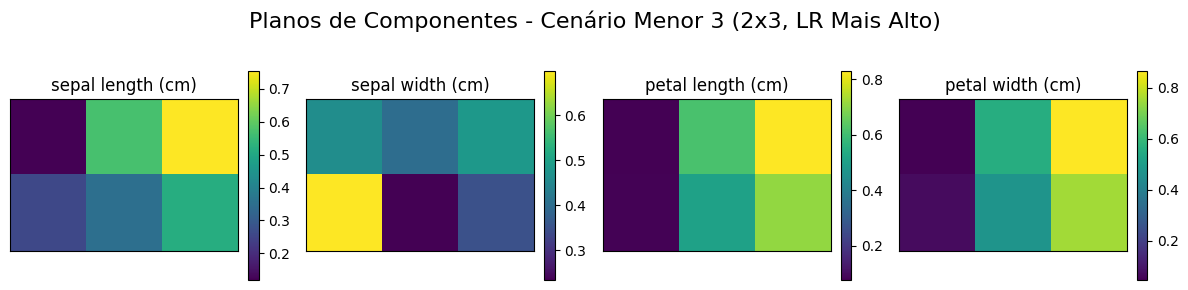

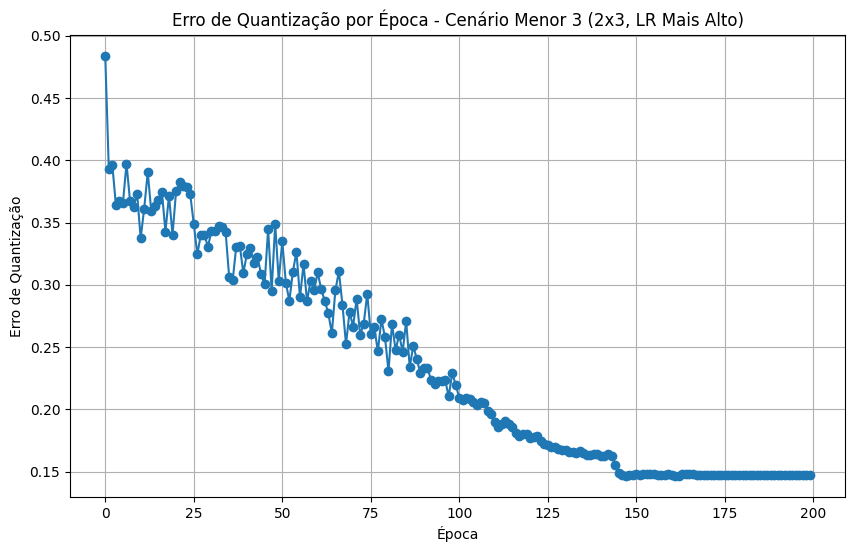


--- Executando Cenário Menor 4 (2x3, Épocas Altas) (Cenário 4/10) ---
Iniciando treinamento do SOM com 400 iterações...
Iteração 40/400 - eta: 0.0902, sigma: 1.8050
Iteração 80/400 - eta: 0.0803, sigma: 1.6050
Iteração 120/400 - eta: 0.0703, sigma: 1.4050
Iteração 160/400 - eta: 0.0603, sigma: 1.2050
Iteração 200/400 - eta: 0.0502, sigma: 1.0050
Iteração 240/400 - eta: 0.0403, sigma: 0.8050
Iteração 280/400 - eta: 0.0302, sigma: 0.6050
Iteração 320/400 - eta: 0.0203, sigma: 0.4050
Iteração 360/400 - eta: 0.0103, sigma: 0.2050
Iteração 400/400 - eta: 0.0002, sigma: 0.0050
Treinamento concluído.
Erro de Quantização para Cenário Menor 4 (2x3, Épocas Altas): 0.1605


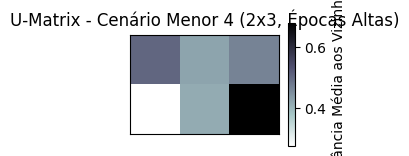

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


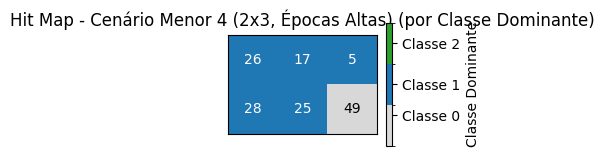

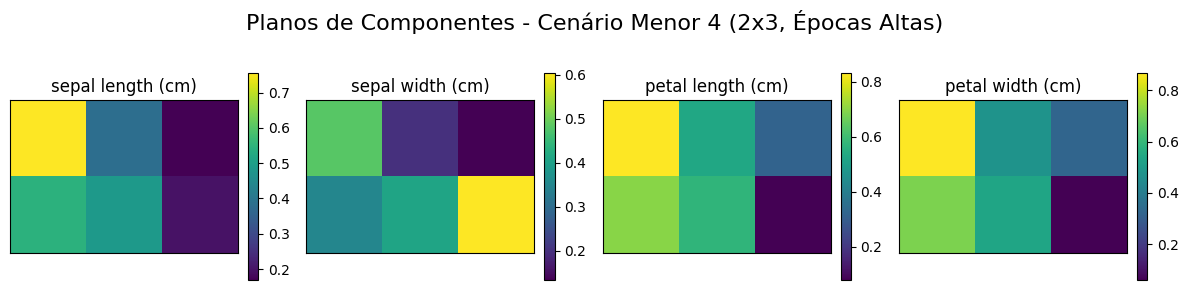

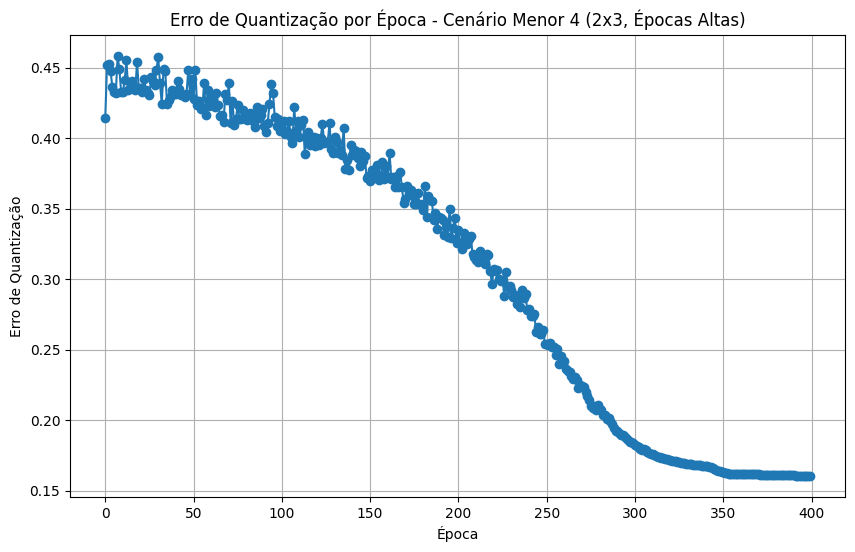


--- Executando Cenário Menor 5 (3x3, Base) (Cenário 5/10) ---
Iniciando treinamento do SOM com 250 iterações...
Iteração 25/250 - eta: 0.1808, sigma: 1.6272
Iteração 50/250 - eta: 0.1608, sigma: 1.4472
Iteração 75/250 - eta: 0.1408, sigma: 1.2672
Iteração 100/250 - eta: 0.1208, sigma: 1.0872
Iteração 125/250 - eta: 0.1008, sigma: 0.9072
Iteração 150/250 - eta: 0.0808, sigma: 0.7272
Iteração 175/250 - eta: 0.0608, sigma: 0.5472
Iteração 200/250 - eta: 0.0408, sigma: 0.3672
Iteração 225/250 - eta: 0.0208, sigma: 0.1872
Iteração 250/250 - eta: 0.0008, sigma: 0.0072
Treinamento concluído.
Erro de Quantização para Cenário Menor 5 (3x3, Base): 0.1304


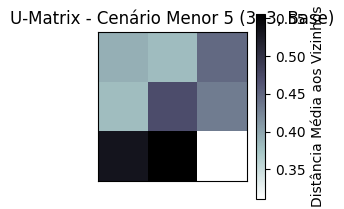

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


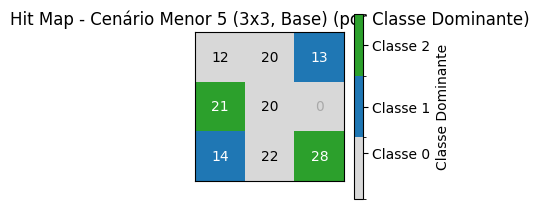

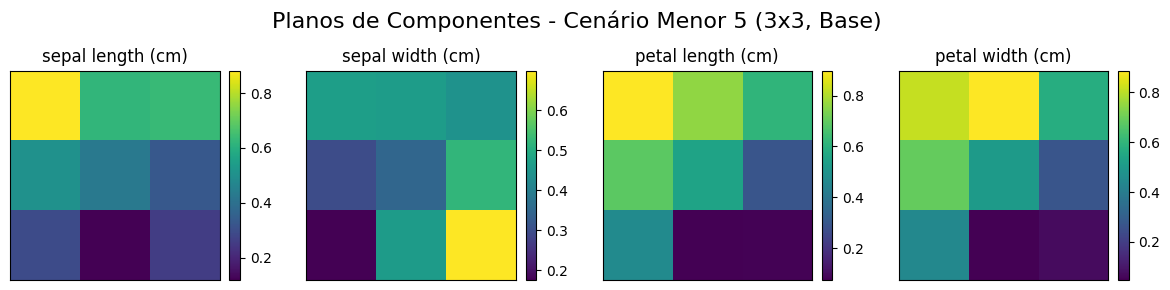

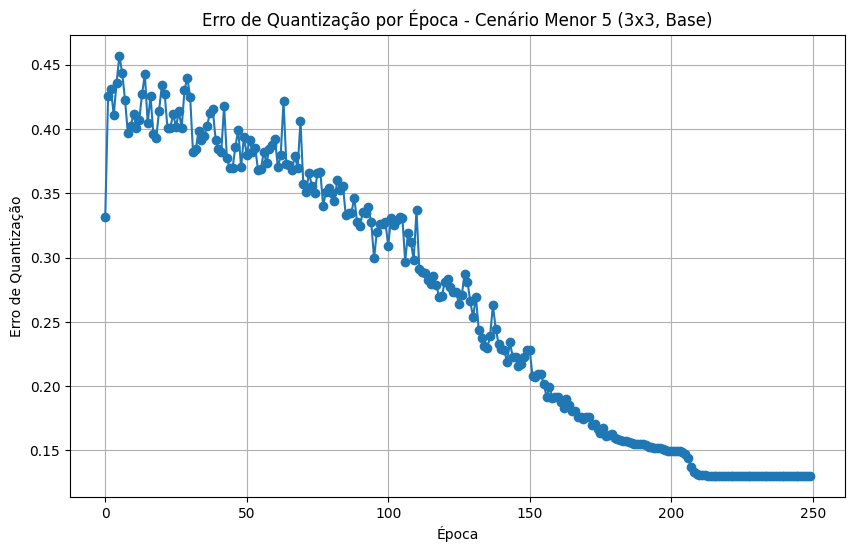


--- Executando Cenário Menor 6 (3x3, Sigma Maior) (Cenário 6/10) ---
Iniciando treinamento do SOM com 500 iterações...
Iteração 50/500 - eta: 0.1353, sigma: 2.2550
Iteração 100/500 - eta: 0.1203, sigma: 2.0050
Iteração 150/500 - eta: 0.1053, sigma: 1.7550
Iteração 200/500 - eta: 0.0903, sigma: 1.5050
Iteração 250/500 - eta: 0.0753, sigma: 1.2550
Iteração 300/500 - eta: 0.0603, sigma: 1.0050
Iteração 350/500 - eta: 0.0453, sigma: 0.7550
Iteração 400/500 - eta: 0.0303, sigma: 0.5050
Iteração 450/500 - eta: 0.0153, sigma: 0.2550
Iteração 500/500 - eta: 0.0003, sigma: 0.0050
Treinamento concluído.
Erro de Quantização para Cenário Menor 6 (3x3, Sigma Maior): 0.1364


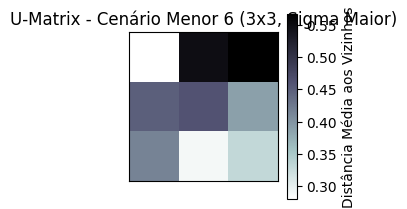

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


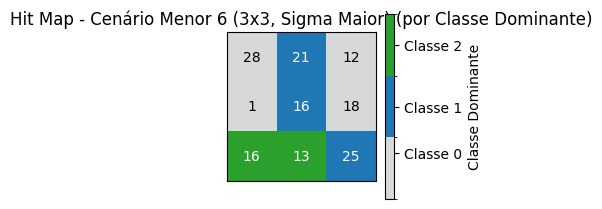

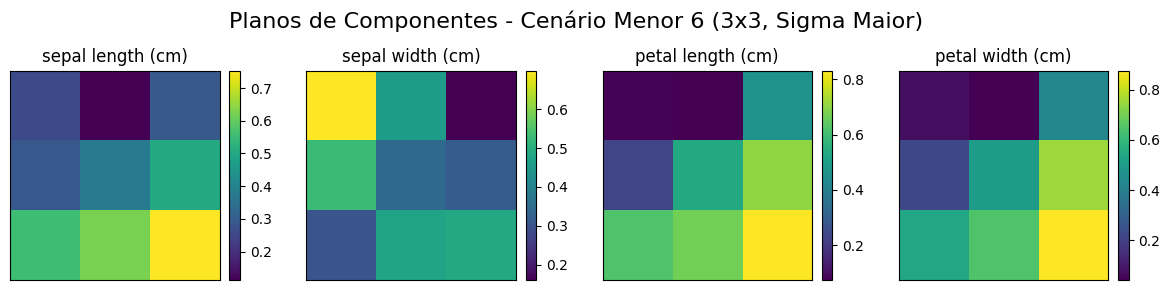

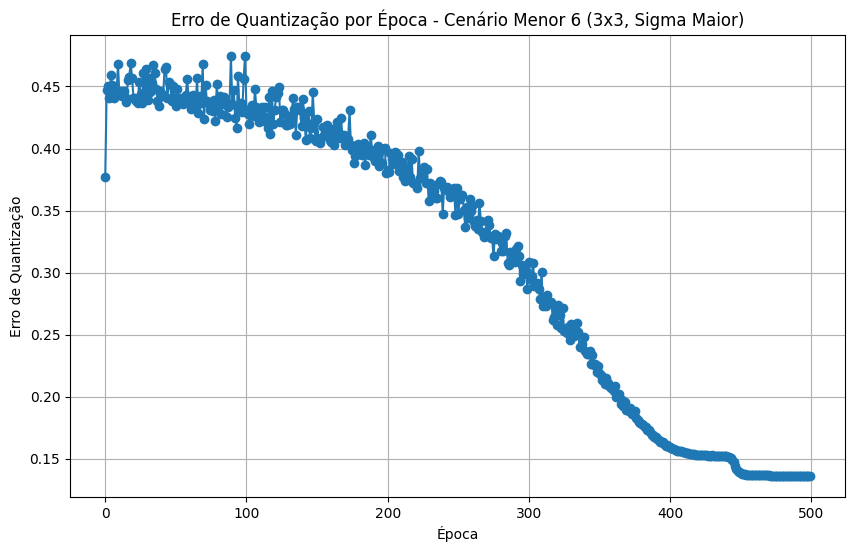


--- Executando Cenário Menor 7 (3x3, 6 ajustado) (Cenário 7/10) ---
Iniciando treinamento do SOM com 600 iterações...
Iteração 60/600 - eta: 0.2254, sigma: 1.8033
Iteração 120/600 - eta: 0.2004, sigma: 1.6033
Iteração 180/600 - eta: 0.1754, sigma: 1.4033
Iteração 240/600 - eta: 0.1504, sigma: 1.2033
Iteração 300/600 - eta: 0.1254, sigma: 1.0033
Iteração 360/600 - eta: 0.1004, sigma: 0.8033
Iteração 420/600 - eta: 0.0754, sigma: 0.6033
Iteração 480/600 - eta: 0.0504, sigma: 0.4033
Iteração 540/600 - eta: 0.0254, sigma: 0.2033
Iteração 600/600 - eta: 0.0004, sigma: 0.0033
Treinamento concluído.
Erro de Quantização para Cenário Menor 7 (3x3, 6 ajustado): 0.1303


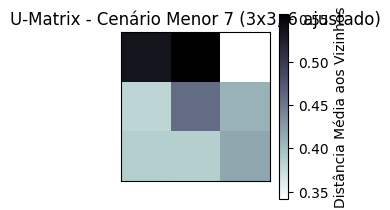

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


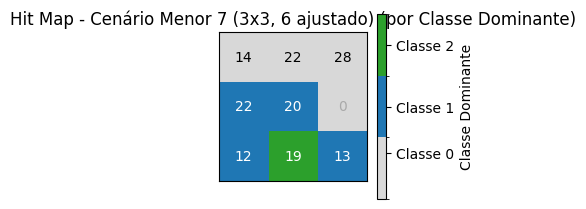

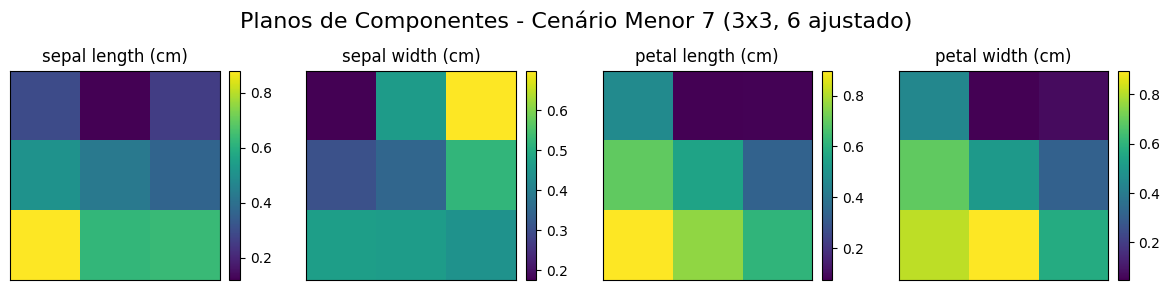

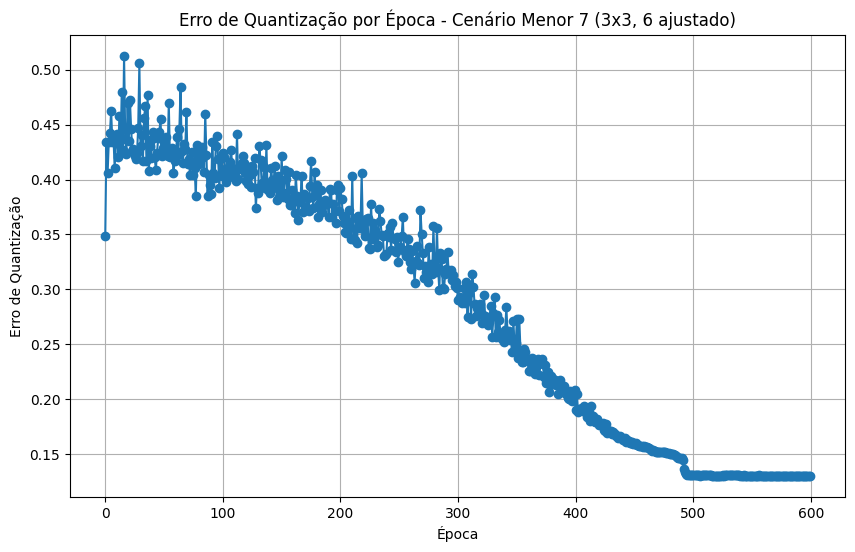


--- Executando Cenário Menor 8 (3x4, Épocas Altas) (Cenário 8/10) ---
Iniciando treinamento do SOM com 600 iterações...
Iteração 60/600 - eta: 0.0902, sigma: 2.7050
Iteração 120/600 - eta: 0.0802, sigma: 2.4050
Iteração 180/600 - eta: 0.0702, sigma: 2.1050
Iteração 240/600 - eta: 0.0602, sigma: 1.8050
Iteração 300/600 - eta: 0.0502, sigma: 1.5050
Iteração 360/600 - eta: 0.0402, sigma: 1.2050
Iteração 420/600 - eta: 0.0302, sigma: 0.9050
Iteração 480/600 - eta: 0.0202, sigma: 0.6050
Iteração 540/600 - eta: 0.0102, sigma: 0.3050
Iteração 600/600 - eta: 0.0002, sigma: 0.0050
Treinamento concluído.
Erro de Quantização para Cenário Menor 8 (3x4, Épocas Altas): 0.1204


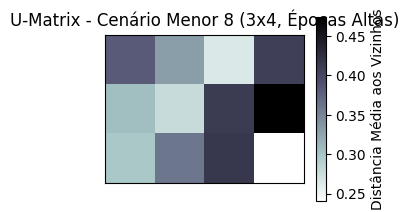

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


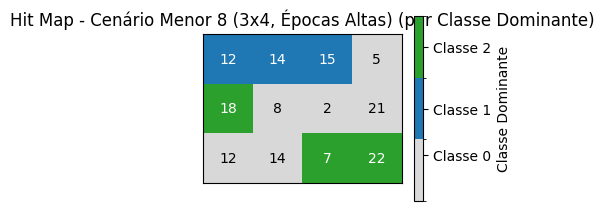

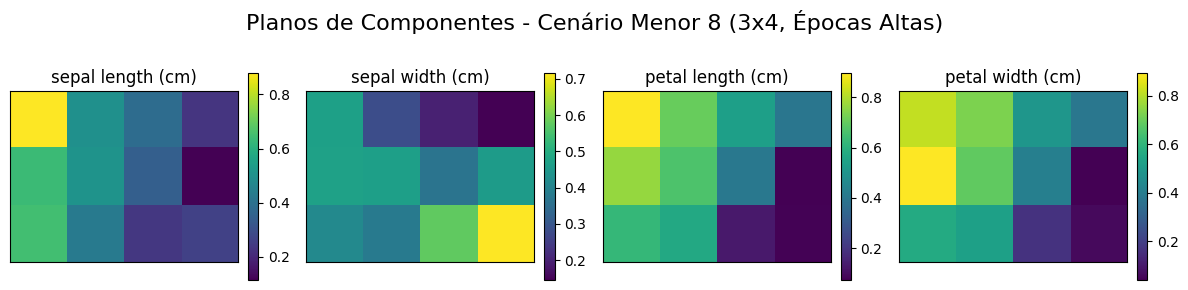

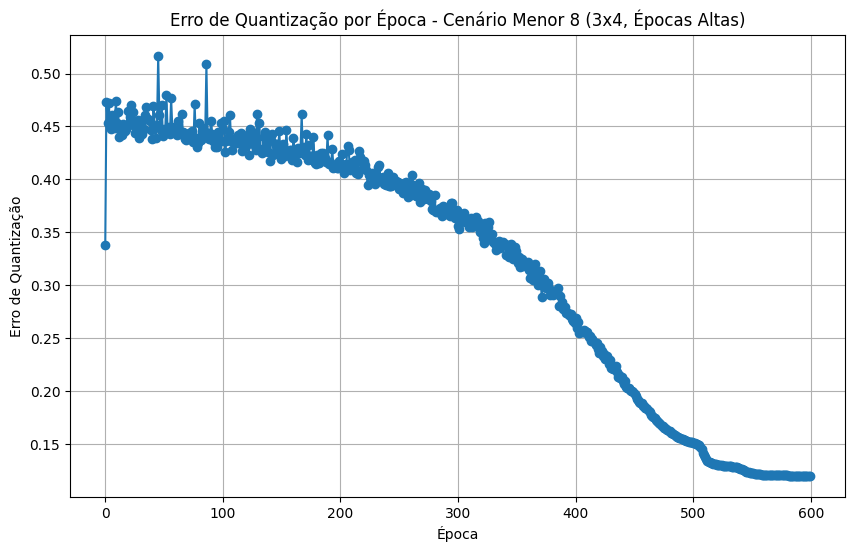


--- Executando Cenário Menor 9 (4x4, Base) (Cenário 9/10) ---
Iniciando treinamento do SOM com 350 iterações...
Iteração 35/350 - eta: 0.1806, sigma: 2.2571
Iteração 70/350 - eta: 0.1606, sigma: 2.0071
Iteração 105/350 - eta: 0.1406, sigma: 1.7571
Iteração 140/350 - eta: 0.1206, sigma: 1.5071
Iteração 175/350 - eta: 0.1006, sigma: 1.2571
Iteração 210/350 - eta: 0.0806, sigma: 1.0071
Iteração 245/350 - eta: 0.0606, sigma: 0.7571
Iteração 280/350 - eta: 0.0406, sigma: 0.5071
Iteração 315/350 - eta: 0.0206, sigma: 0.2571
Iteração 350/350 - eta: 0.0006, sigma: 0.0071
Treinamento concluído.
Erro de Quantização para Cenário Menor 9 (4x4, Base): 0.1067


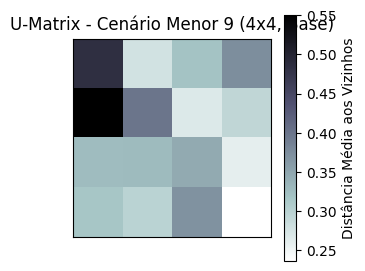

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


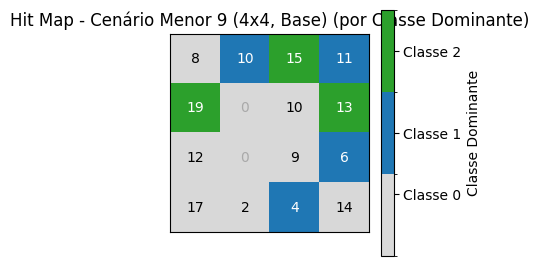

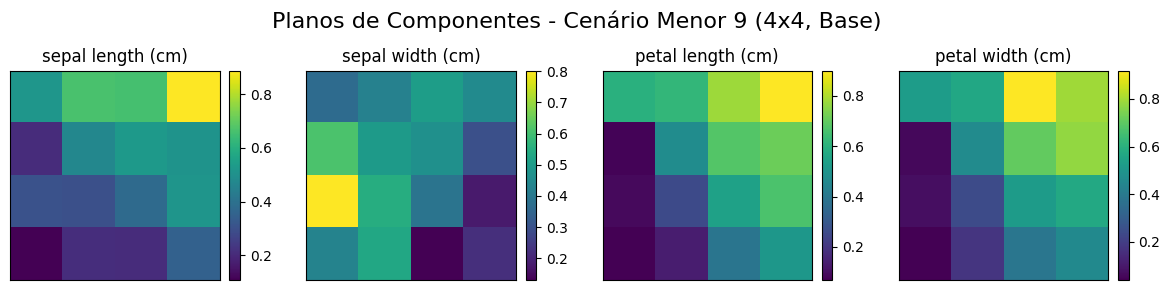

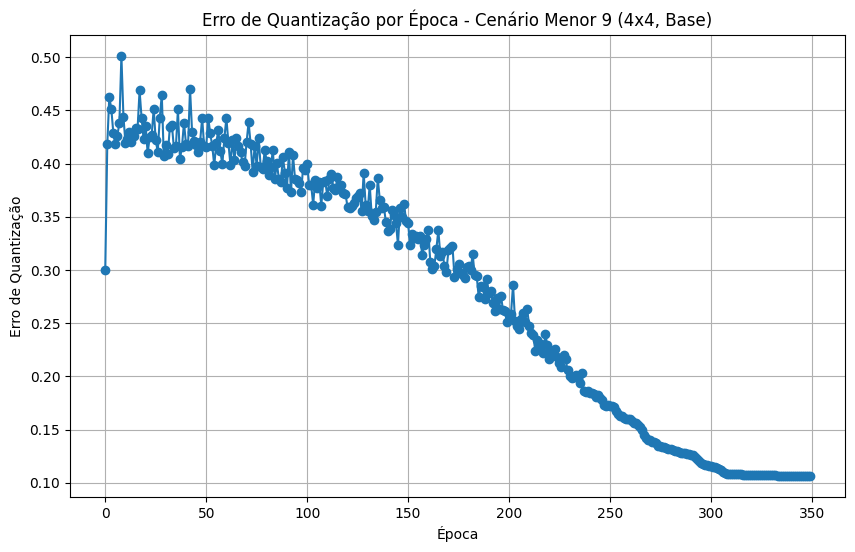


--- Executando Cenário Menor 10 (4x4, Épocas Altas) (Cenário 10/10) ---
Iniciando treinamento do SOM com 800 iterações...
Iteração 80/800 - eta: 0.1352, sigma: 3.1544
Iteração 160/800 - eta: 0.1202, sigma: 2.8044
Iteração 240/800 - eta: 0.1052, sigma: 2.4544
Iteração 320/800 - eta: 0.0902, sigma: 2.1044
Iteração 400/800 - eta: 0.0752, sigma: 1.7544
Iteração 480/800 - eta: 0.0602, sigma: 1.4044
Iteração 560/800 - eta: 0.0452, sigma: 1.0544
Iteração 640/800 - eta: 0.0302, sigma: 0.7044
Iteração 720/800 - eta: 0.0152, sigma: 0.3544
Iteração 800/800 - eta: 0.0002, sigma: 0.0044
Treinamento concluído.
Erro de Quantização para Cenário Menor 10 (4x4, Épocas Altas): 0.1087


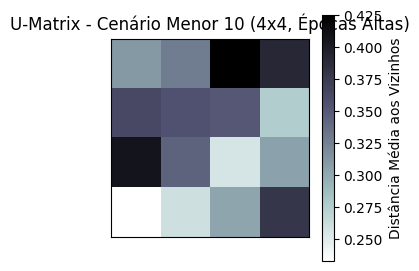

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


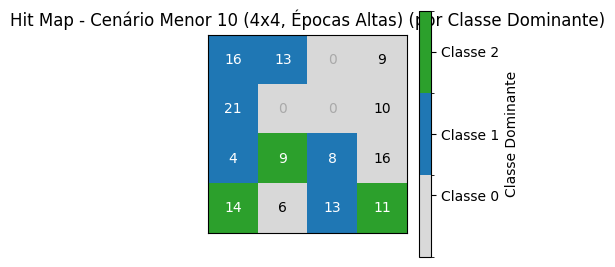

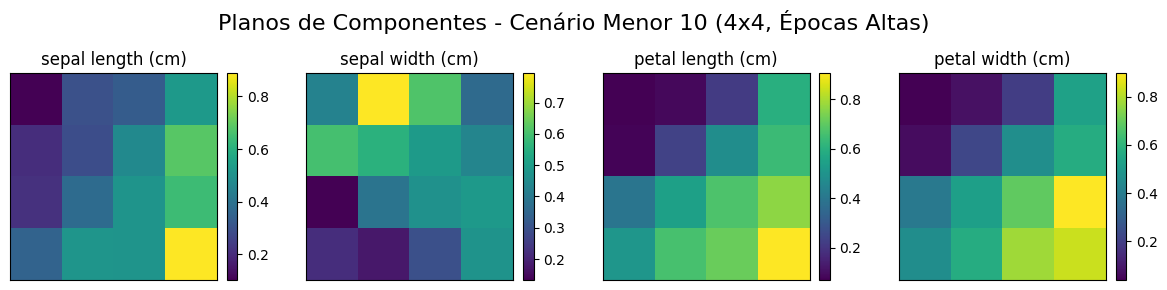

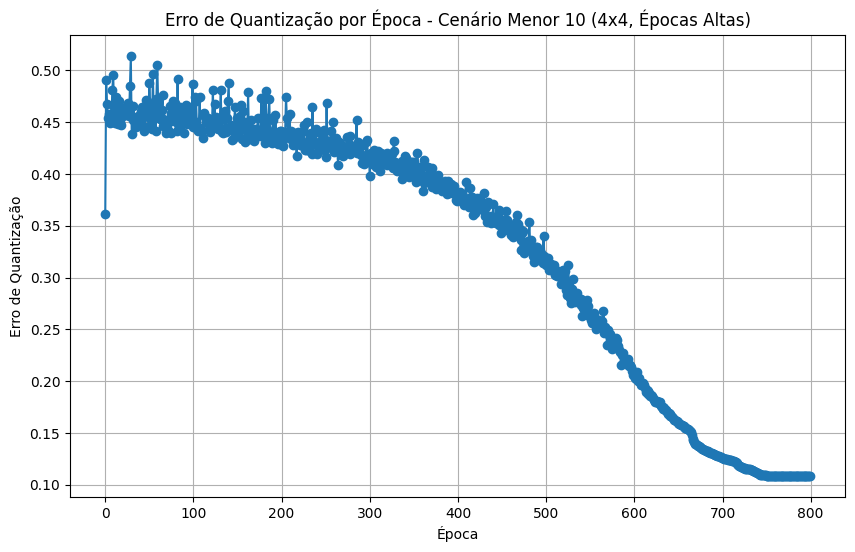


Execução de todos os 10 cenários concluída.
Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.


In [ ]:
# Testes com tamanhos pequenos
if __name__ == "__main__":
    # Carregar e normalizar os dados Iris
    dados_iris_normalizados, labels_iris, feature_names_iris, target_names_iris = carregar_e_normalizar_iris()
    print("Shape dos dados normalizados:", dados_iris_normalizados.shape)

    # --- Definição dos 10 Cenários de Hiperparâmetros ---
    scenarios = [
    {"name": "Cenário Menor 1 (2x2, Épocas Baixas)", "linhas": 2, "colunas": 2, "iteracoes": 150, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 1.0, "decaimento": 'linear'},
    {"name": "Cenário Menor 2 (2x2, Épocas Médias)", "linhas": 2, "colunas": 2, "iteracoes": 300, "taxa_aprendizado_inicial": 0.15, "sigma_inicial": 1.5, "decaimento": 'linear'},
    {"name": "Cenário Menor 3 (2x3, LR Mais Alto)", "linhas": 2, "colunas": 3, "iteracoes": 200, "taxa_aprendizado_inicial": 0.25, "sigma_inicial": 1.2, "decaimento": 'linear'},
    {"name": "Cenário Menor 4 (2x3, Épocas Altas)", "linhas": 2, "colunas": 3, "iteracoes": 400, "taxa_aprendizado_inicial": 0.1, "sigma_inicial": 2.0, "decaimento": 'linear'},
    {"name": "Cenário Menor 5 (3x3, Base)", "linhas": 3, "colunas": 3, "iteracoes": 250, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 1.8, "decaimento": 'linear'},
    {"name": "Cenário Menor 6 (3x3, Sigma Maior)", "linhas": 3, "colunas": 3, "iteracoes": 500, "taxa_aprendizado_inicial": 0.15, "sigma_inicial": 2.5, "decaimento": 'linear'},
    {"name": "Cenário Menor 7 (3x3, 6 ajustado)", "linhas": 3, "colunas": 3, "iteracoes": 600, "taxa_aprendizado_inicial": 0.25, "sigma_inicial": 2.0, "decaimento": 'linear'},
    {"name": "Cenário Menor 8 (3x4, Épocas Altas)", "linhas": 3, "colunas": 4, "iteracoes": 600, "taxa_aprendizado_inicial": 0.1, "sigma_inicial": 3.0, "decaimento": 'linear'},
    {"name": "Cenário Menor 9 (4x4, Base)", "linhas": 4, "colunas": 4, "iteracoes": 350, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 2.5, "decaimento": 'linear'},
    {"name": "Cenário Menor 10 (4x4, Épocas Altas)", "linhas": 4, "colunas": 4, "iteracoes": 800, "taxa_aprendizado_inicial": 0.15, "sigma_inicial": 3.5, "decaimento": 'linear'},
]


    # --- Execução de cada cenário ---
    for i, scenario in enumerate(scenarios):
        print(f"\n--- Executando {scenario['name']} (Cenário {i+1}/10) ---")

        som_model = SOM(
            linhas=scenario['linhas'],
            colunas=scenario['colunas'],
            iteracoes=scenario['iteracoes'],
            taxa_aprendizado_inicial=scenario['taxa_aprendizado_inicial'],
            sigma_inicial=scenario['sigma_inicial'],
            decaimento=scenario['decaimento']
        )

        # Treinar o modelo (usar uma cópia dos dados para garantir que não haja side-effects entre as rodadas)
        som_model.treinar(dados_iris_normalizados.copy())

        # Calcular e exibir o erro de quantização
        erro_quantizacao = som_model.calcular_erro_quantizacao()
        print(f"Erro de Quantização para {scenario['name']}: {erro_quantizacao:.4f}")

        # Gerar e exibir as visualizações
        som_model.visualizar_umatrix(title=f"U-Matrix - {scenario['name']}")
        som_model.visualizar_hit_map(labels=labels_iris, title=f"Hit Map - {scenario['name']}")
        som_model.visualizar_component_planes(feature_names=feature_names_iris, title=f"Planos de Componentes - {scenario['name']}")

        import matplotlib.pyplot as plt

        # ... (após treinar seu som_model) ...

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(som_model.erros_por_epoca)), som_model.erros_por_epoca, marker='o', linestyle='-')
        plt.title(f"Erro de Quantização por Época - {scenario['name']}")
        plt.xlabel("Época")
        plt.ylabel("Erro de Quantização")
        plt.grid(True)
        plt.show()

    print("\nExecução de todos os 10 cenários concluída.")
    print("Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.")


Shape dos dados normalizados: (150, 4)

--- Executando Cenário Menor 1 (2x2, Épocas Baixas) (Cenário 1/10) ---
Iniciando treinamento do SOM com 150 iterações...
Iteração 15/150 - eta: 0.1659, sigma: 0.8297
Iteração 30/150 - eta: 0.1359, sigma: 0.6793
Iteração 45/150 - eta: 0.1112, sigma: 0.5562
Iteração 60/150 - eta: 0.0911, sigma: 0.4554
Iteração 75/150 - eta: 0.0746, sigma: 0.3728
Iteração 90/150 - eta: 0.0610, sigma: 0.3052
Iteração 105/150 - eta: 0.0500, sigma: 0.2499
Iteração 120/150 - eta: 0.0409, sigma: 0.2046
Iteração 135/150 - eta: 0.0335, sigma: 0.1675
Iteração 150/150 - eta: 0.0274, sigma: 0.1372
Treinamento concluído.
Erro de Quantização para Cenário Menor 1 (2x2, Épocas Baixas): 0.1732


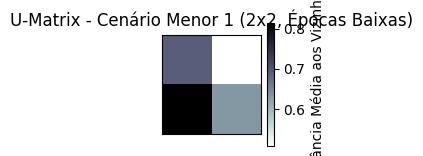

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


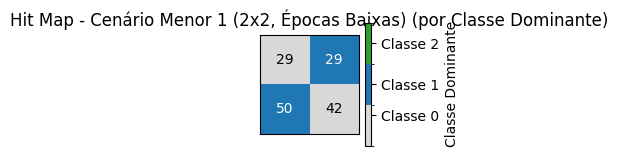

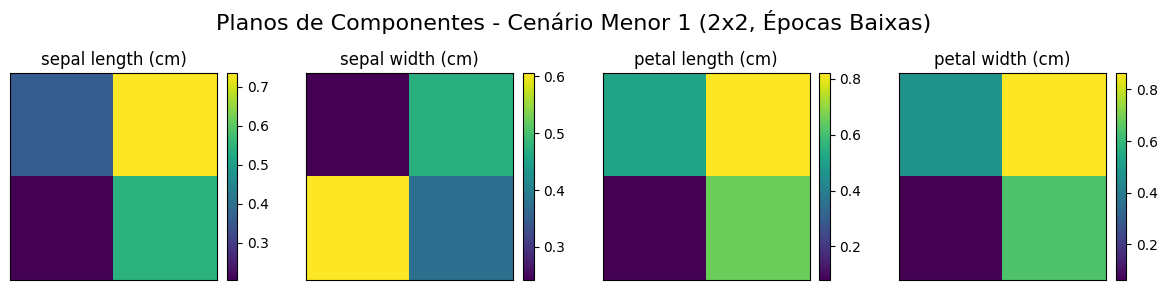

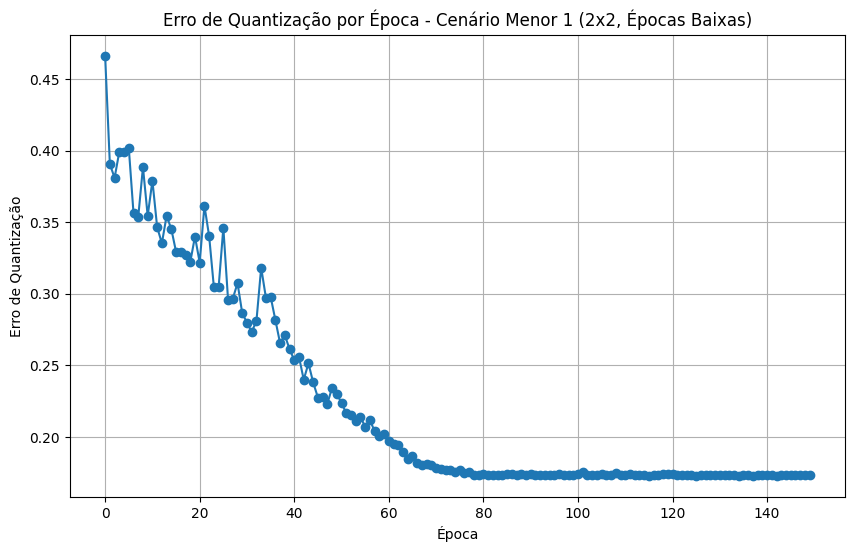


--- Executando Cenário Menor 2 (2x2, Épocas Médias) (Cenário 2/10) ---
Iniciando treinamento do SOM com 300 iterações...
Iteração 30/300 - eta: 0.1236, sigma: 1.2363
Iteração 60/300 - eta: 0.1012, sigma: 1.0122
Iteração 90/300 - eta: 0.0829, sigma: 0.8287
Iteração 120/300 - eta: 0.0679, sigma: 0.6785
Iteração 150/300 - eta: 0.0556, sigma: 0.5555
Iteração 180/300 - eta: 0.0455, sigma: 0.4548
Iteração 210/300 - eta: 0.0372, sigma: 0.3724
Iteração 240/300 - eta: 0.0305, sigma: 0.3049
Iteração 270/300 - eta: 0.0250, sigma: 0.2496
Iteração 300/300 - eta: 0.0204, sigma: 0.2044
Treinamento concluído.
Erro de Quantização para Cenário Menor 2 (2x2, Épocas Médias): 0.1733


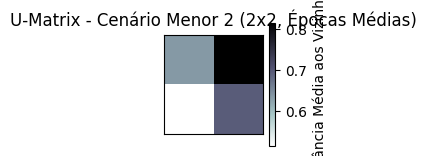

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


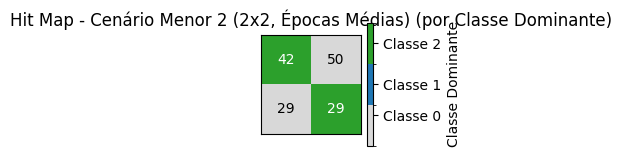

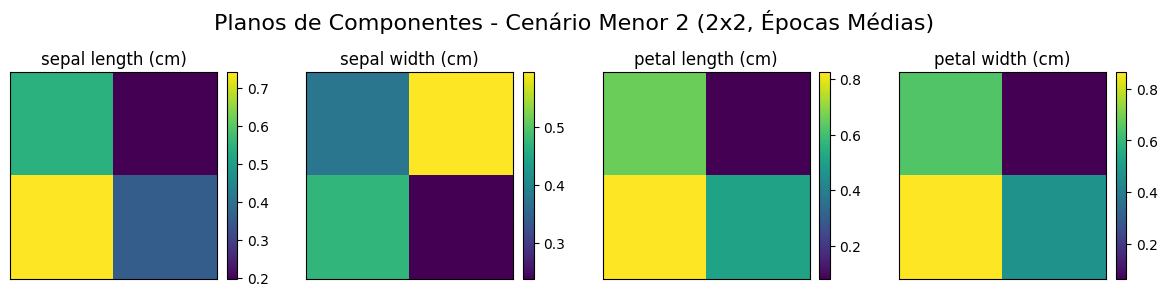

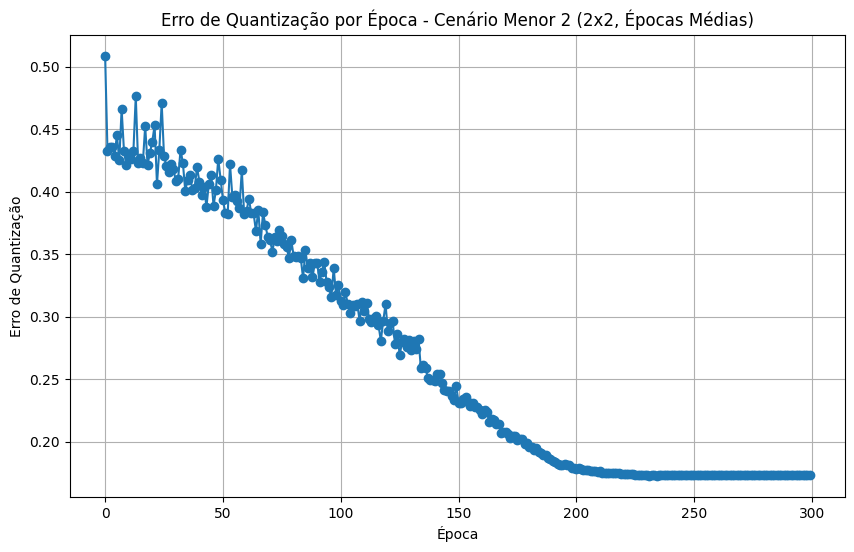


--- Executando Cenário Menor 3 (2x3, LR Mais Alto) (Cenário 3/10) ---
Iniciando treinamento do SOM com 200 iterações...
Iteração 20/200 - eta: 0.2067, sigma: 0.9924
Iteração 40/200 - eta: 0.1693, sigma: 0.8125
Iteração 60/200 - eta: 0.1386, sigma: 0.6652
Iteração 80/200 - eta: 0.1135, sigma: 0.5446
Iteração 100/200 - eta: 0.0929, sigma: 0.4459
Iteração 120/200 - eta: 0.0761, sigma: 0.3651
Iteração 140/200 - eta: 0.0623, sigma: 0.2989
Iteração 160/200 - eta: 0.0510, sigma: 0.2447
Iteração 180/200 - eta: 0.0417, sigma: 0.2004
Iteração 200/200 - eta: 0.0342, sigma: 0.1640
Treinamento concluído.
Erro de Quantização para Cenário Menor 3 (2x3, LR Mais Alto): 0.1490


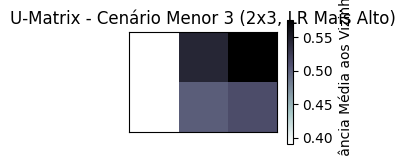

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


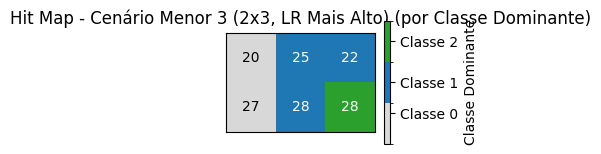

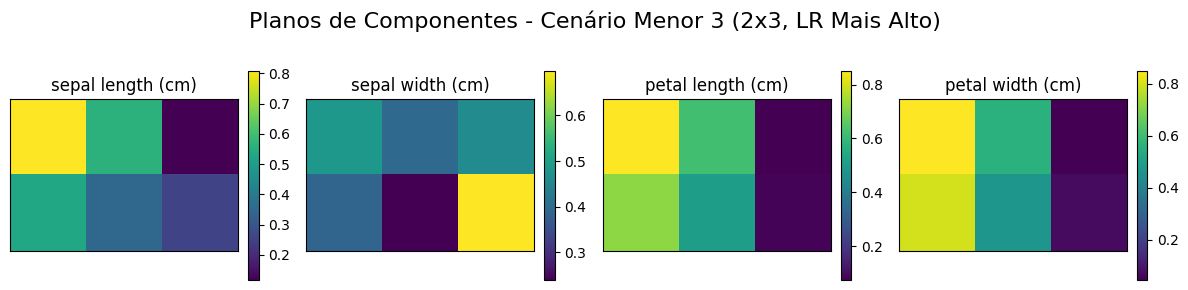

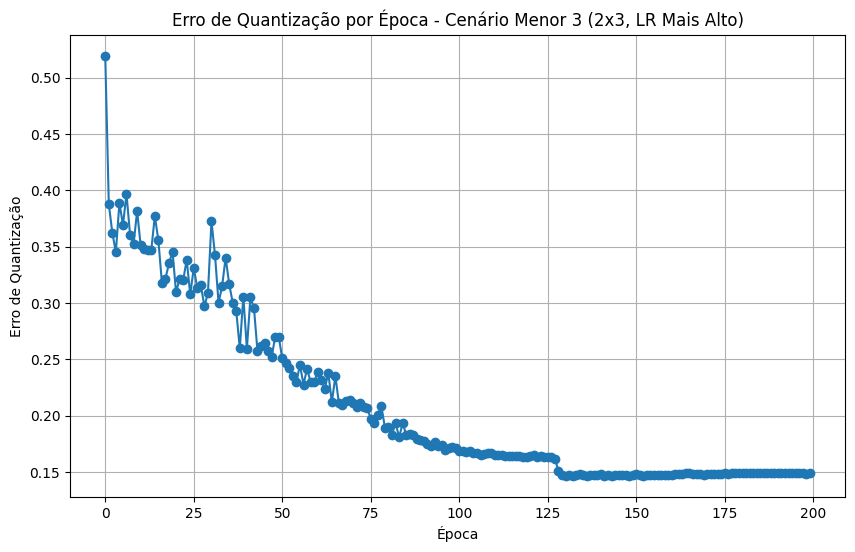


--- Executando Cenário Menor 4 (2x3, Épocas Altas) (Cenário 4/10) ---
Iniciando treinamento do SOM com 400 iterações...
Iteração 40/400 - eta: 0.0823, sigma: 1.6457
Iteração 80/400 - eta: 0.0674, sigma: 1.3474
Iteração 120/400 - eta: 0.0552, sigma: 1.1031
Iteração 160/400 - eta: 0.0452, sigma: 0.9032
Iteração 200/400 - eta: 0.0370, sigma: 0.7394
Iteração 240/400 - eta: 0.0303, sigma: 0.6054
Iteração 280/400 - eta: 0.0248, sigma: 0.4957
Iteração 320/400 - eta: 0.0203, sigma: 0.4058
Iteração 360/400 - eta: 0.0166, sigma: 0.3323
Iteração 400/400 - eta: 0.0136, sigma: 0.2720
Treinamento concluído.
Erro de Quantização para Cenário Menor 4 (2x3, Épocas Altas): 0.1476


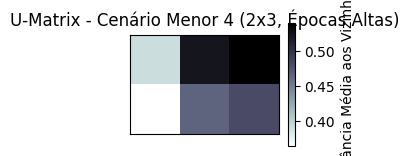

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


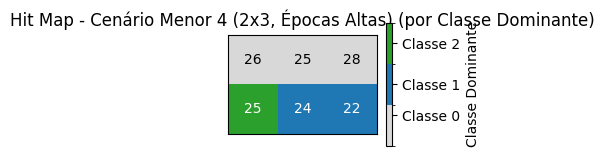

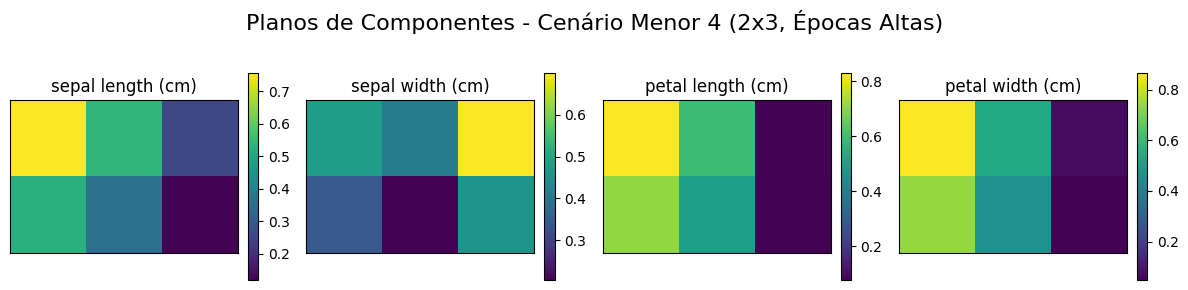

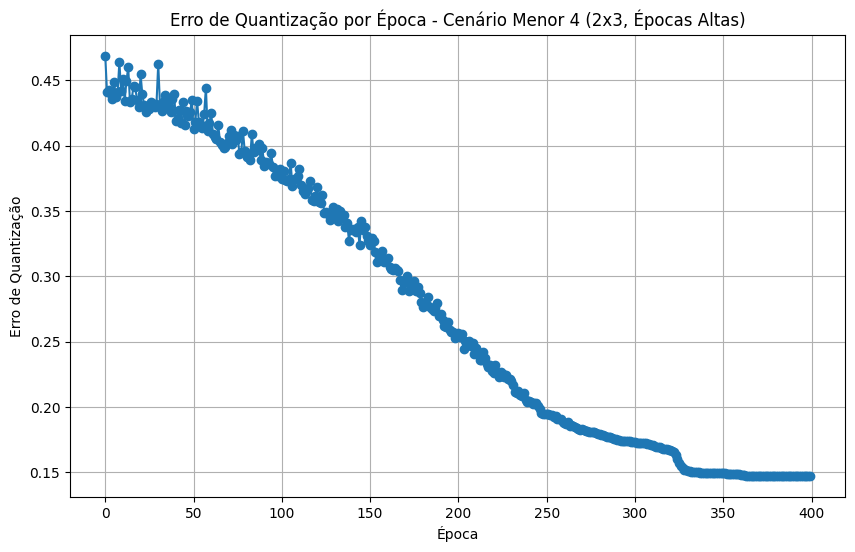


--- Executando Cenário Menor 5 (3x3, Base) (Cenário 5/10) ---
Iniciando treinamento do SOM com 250 iterações...
Iteração 25/250 - eta: 0.1651, sigma: 1.4856
Iteração 50/250 - eta: 0.1351, sigma: 1.2163
Iteração 75/250 - eta: 0.1106, sigma: 0.9958
Iteração 100/250 - eta: 0.0906, sigma: 0.8153
Iteração 125/250 - eta: 0.0742, sigma: 0.6675
Iteração 150/250 - eta: 0.0607, sigma: 0.5465
Iteração 175/250 - eta: 0.0497, sigma: 0.4474
Iteração 200/250 - eta: 0.0407, sigma: 0.3663
Iteração 225/250 - eta: 0.0333, sigma: 0.2999
Iteração 250/250 - eta: 0.0273, sigma: 0.2456
Treinamento concluído.
Erro de Quantização para Cenário Menor 5 (3x3, Base): 0.1304


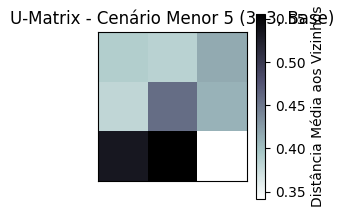

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


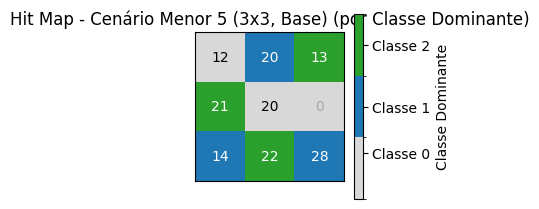

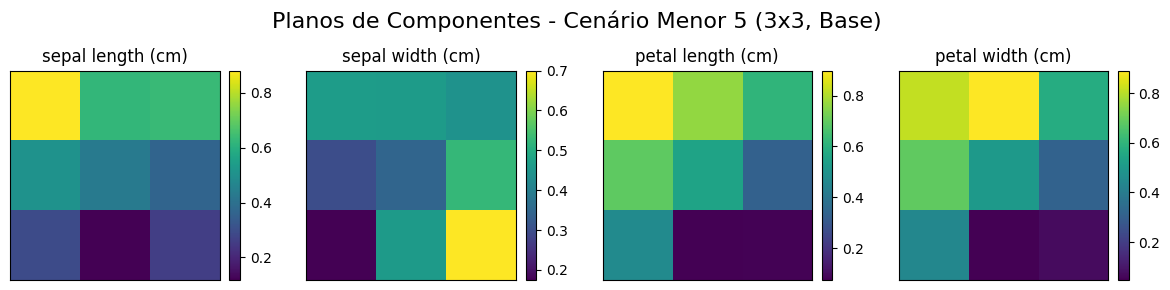

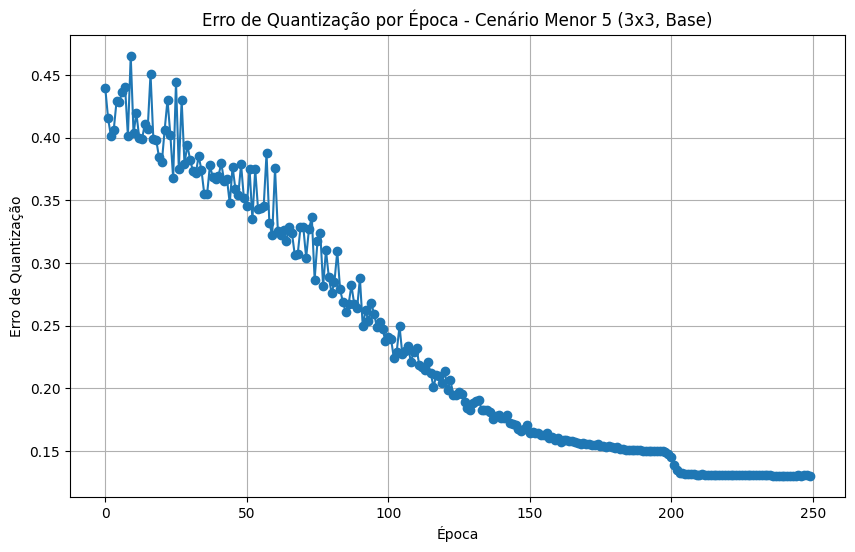


--- Executando Cenário Menor 6 (3x3, Sigma Maior) (Cenário 6/10) ---
Iniciando treinamento do SOM com 500 iterações...
Iteração 50/500 - eta: 0.1233, sigma: 2.0550
Iteração 100/500 - eta: 0.1010, sigma: 1.6825
Iteração 150/500 - eta: 0.0827, sigma: 1.3775
Iteração 200/500 - eta: 0.0677, sigma: 1.1278
Iteração 250/500 - eta: 0.0554, sigma: 0.9234
Iteração 300/500 - eta: 0.0454, sigma: 0.7560
Iteração 350/500 - eta: 0.0371, sigma: 0.6190
Iteração 400/500 - eta: 0.0304, sigma: 0.5068
Iteração 450/500 - eta: 0.0249, sigma: 0.4149
Iteração 500/500 - eta: 0.0204, sigma: 0.3397
Treinamento concluído.
Erro de Quantização para Cenário Menor 6 (3x3, Sigma Maior): 0.1313


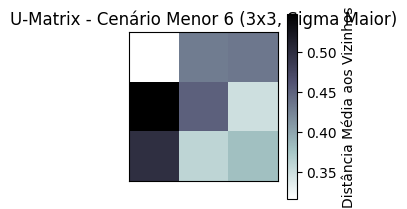

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


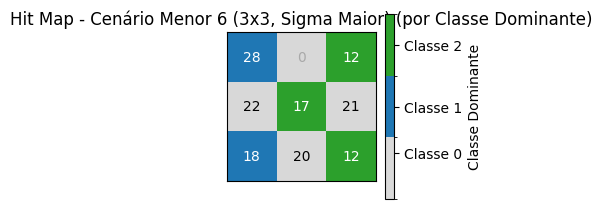

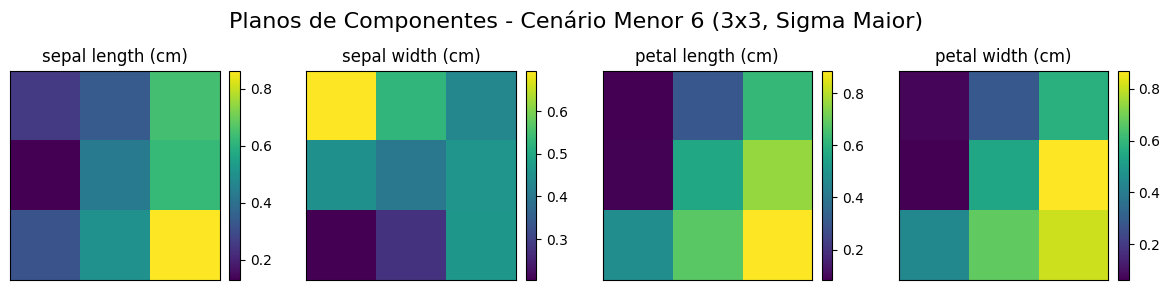

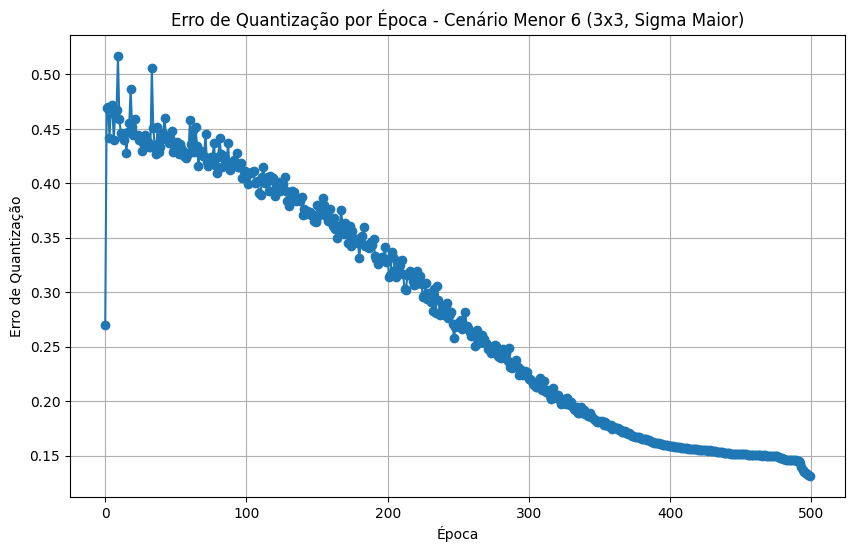


--- Executando Cenário Menor 7 (3x3, 6 ajustado) (Cenário 7/10) ---
Iniciando treinamento do SOM com 600 iterações...
Iteração 60/600 - eta: 0.2054, sigma: 1.6429
Iteração 120/600 - eta: 0.1681, sigma: 1.3451
Iteração 180/600 - eta: 0.1377, sigma: 1.1013
Iteração 240/600 - eta: 0.1127, sigma: 0.9017
Iteração 300/600 - eta: 0.0923, sigma: 0.7382
Iteração 360/600 - eta: 0.0755, sigma: 0.6044
Iteração 420/600 - eta: 0.0619, sigma: 0.4948
Iteração 480/600 - eta: 0.0506, sigma: 0.4051
Iteração 540/600 - eta: 0.0415, sigma: 0.3317
Iteração 600/600 - eta: 0.0339, sigma: 0.2716
Treinamento concluído.
Erro de Quantização para Cenário Menor 7 (3x3, 6 ajustado): 0.1304


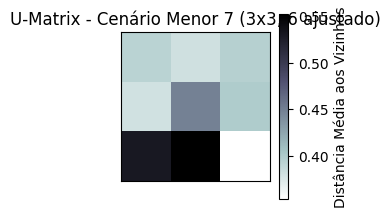

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


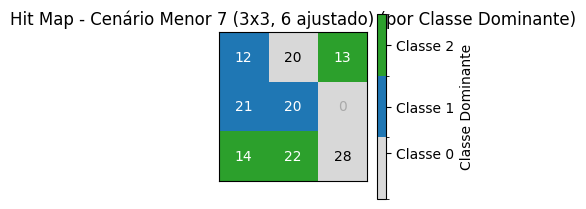

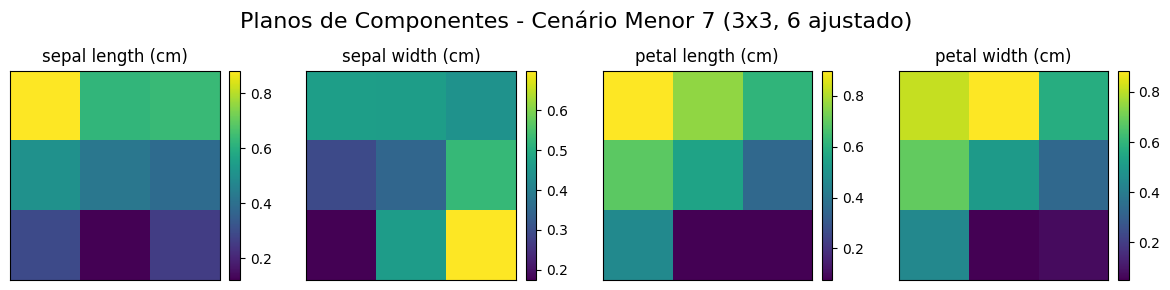

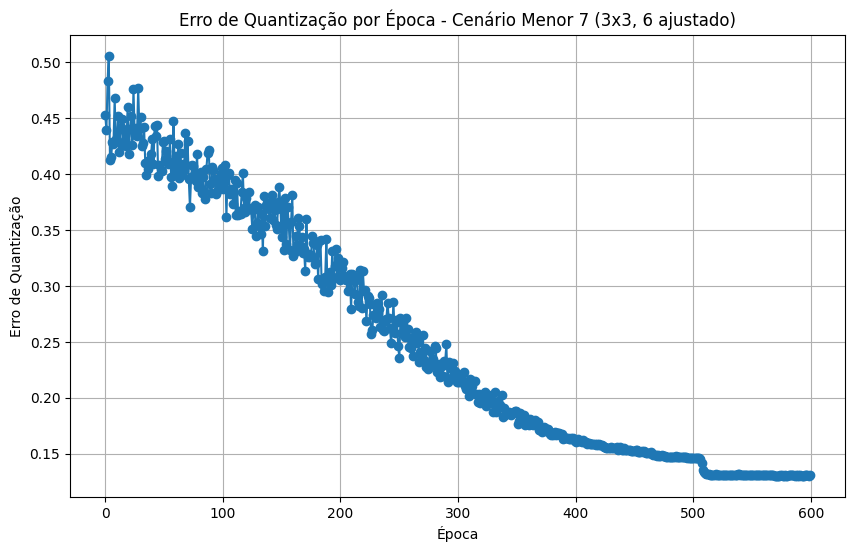


--- Executando Cenário Menor 8 (3x4, Épocas Altas) (Cenário 8/10) ---
Iniciando treinamento do SOM com 600 iterações...
Iteração 60/600 - eta: 0.0821, sigma: 2.4644
Iteração 120/600 - eta: 0.0673, sigma: 2.0177
Iteração 180/600 - eta: 0.0551, sigma: 1.6519
Iteração 240/600 - eta: 0.0451, sigma: 1.3525
Iteração 300/600 - eta: 0.0369, sigma: 1.1073
Iteração 360/600 - eta: 0.0302, sigma: 0.9066
Iteração 420/600 - eta: 0.0247, sigma: 0.7423
Iteração 480/600 - eta: 0.0203, sigma: 0.6077
Iteração 540/600 - eta: 0.0166, sigma: 0.4976
Iteração 600/600 - eta: 0.0136, sigma: 0.4074
Treinamento concluído.
Erro de Quantização para Cenário Menor 8 (3x4, Épocas Altas): 0.1317


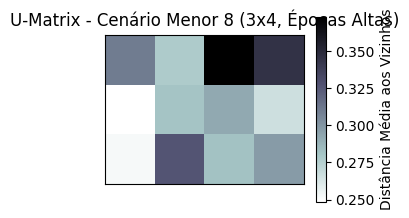

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


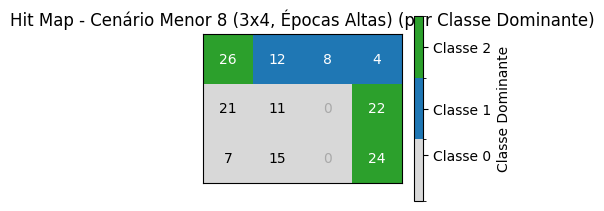

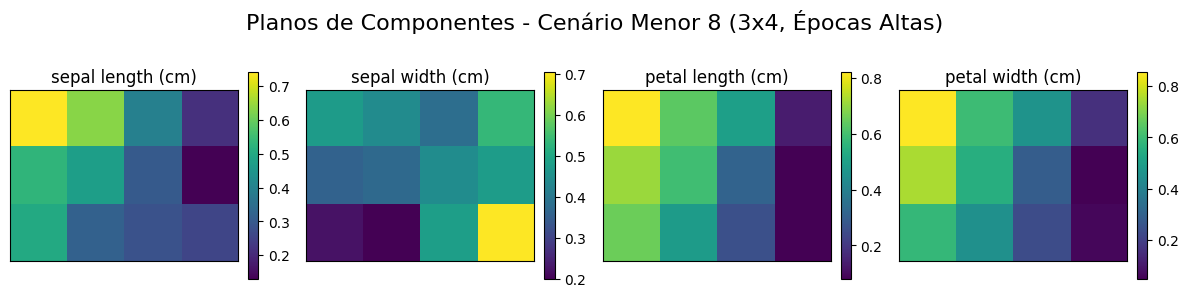

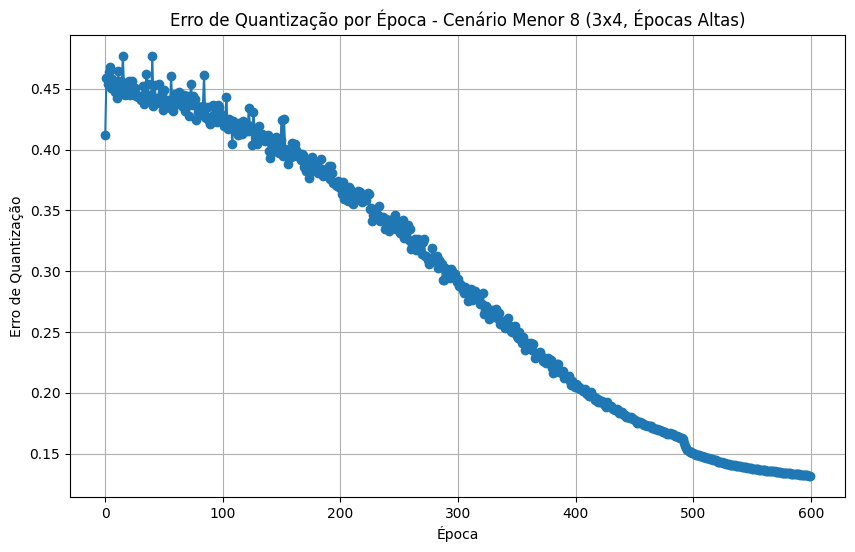


--- Executando Cenário Menor 9 (4x4, Base) (Cenário 9/10) ---
Iniciando treinamento do SOM com 350 iterações...
Iteração 35/350 - eta: 0.1647, sigma: 2.0586
Iteração 70/350 - eta: 0.1348, sigma: 1.6854
Iteração 105/350 - eta: 0.1104, sigma: 1.3799
Iteração 140/350 - eta: 0.0904, sigma: 1.1298
Iteração 175/350 - eta: 0.0740, sigma: 0.9250
Iteração 210/350 - eta: 0.0606, sigma: 0.7573
Iteração 245/350 - eta: 0.0496, sigma: 0.6200
Iteração 280/350 - eta: 0.0406, sigma: 0.5076
Iteração 315/350 - eta: 0.0332, sigma: 0.4156
Iteração 350/350 - eta: 0.0272, sigma: 0.3403
Treinamento concluído.
Erro de Quantização para Cenário Menor 9 (4x4, Base): 0.1115


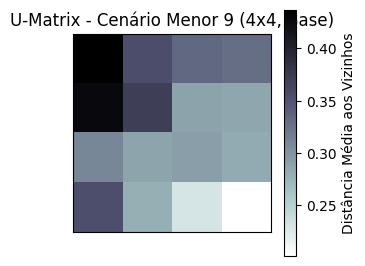

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


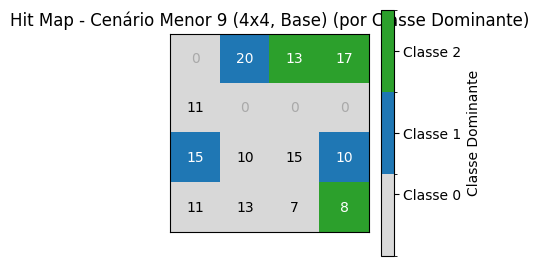

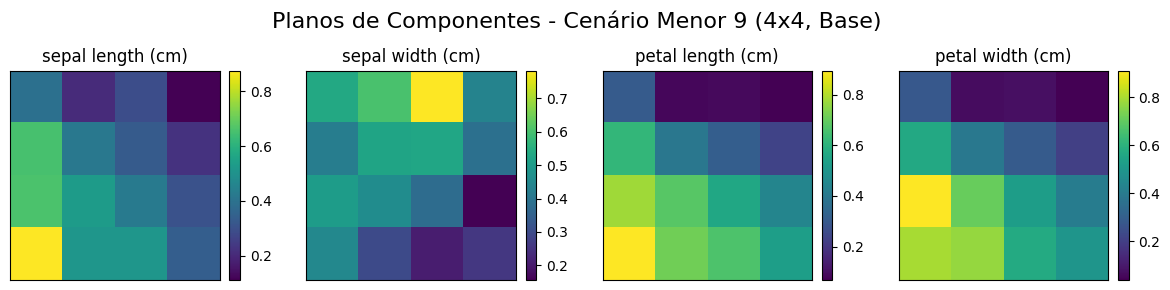

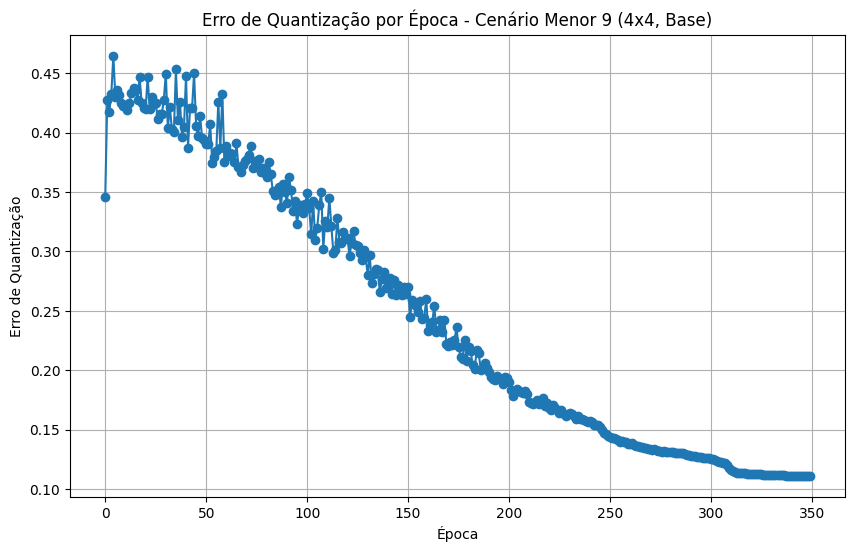


--- Executando Cenário Menor 10 (4x4, Épocas Altas) (Cenário 10/10) ---
Iniciando treinamento do SOM com 800 iterações...
Iteração 80/800 - eta: 0.1231, sigma: 2.8727
Iteração 160/800 - eta: 0.1008, sigma: 2.3520
Iteração 240/800 - eta: 0.0825, sigma: 1.9256
Iteração 320/800 - eta: 0.0676, sigma: 1.5766
Iteração 400/800 - eta: 0.0553, sigma: 1.2908
Iteração 480/800 - eta: 0.0453, sigma: 1.0568
Iteração 560/800 - eta: 0.0371, sigma: 0.8652
Iteração 640/800 - eta: 0.0304, sigma: 0.7084
Iteração 720/800 - eta: 0.0249, sigma: 0.5800
Iteração 800/800 - eta: 0.0204, sigma: 0.4749
Treinamento concluído.
Erro de Quantização para Cenário Menor 10 (4x4, Épocas Altas): 0.1284


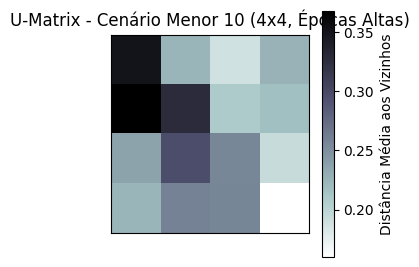

/tmp/ipython-input-35-1967456980.py:278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_labels[i]: plt.cm.get_cmap('tab10')(i) for i in range(num_classes)


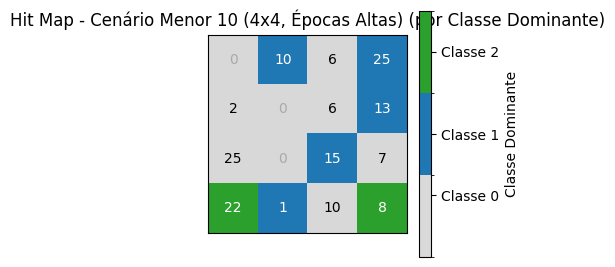

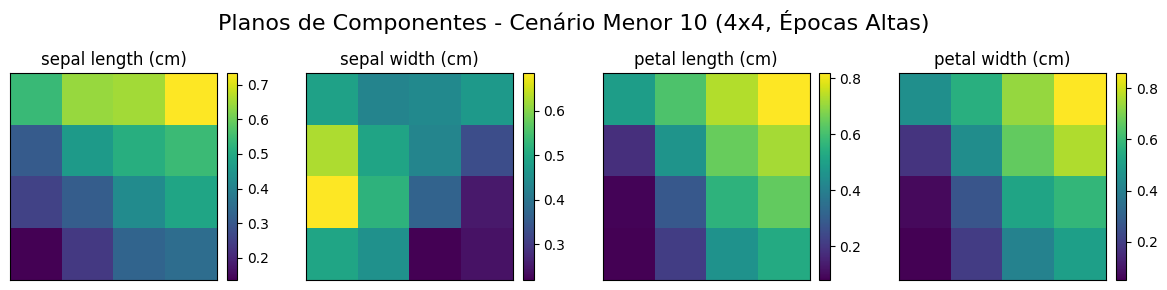

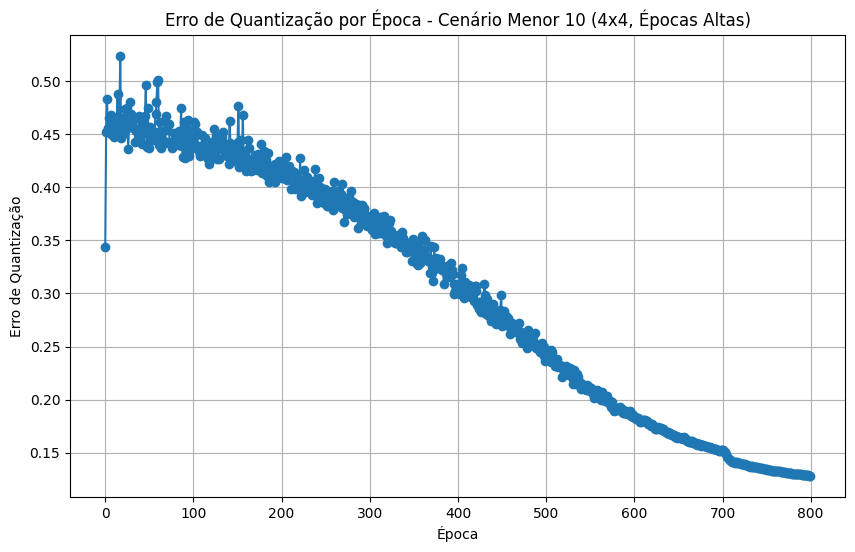


Execução de todos os 10 cenários concluída.
Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.


In [ ]:
# Testes com tamanhos pequenos - Não-linear
if __name__ == "__main__":
    # Carregar e normalizar os dados Iris
    dados_iris_normalizados, labels_iris, feature_names_iris, target_names_iris = carregar_e_normalizar_iris()
    print("Shape dos dados normalizados:", dados_iris_normalizados.shape)

    # --- Definição dos 10 Cenários de Hiperparâmetros ---
    scenarios = [
    {"name": "Cenário Menor 1 (2x2, Épocas Baixas)", "linhas": 2, "colunas": 2, "iteracoes": 150, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 1.0, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 2 (2x2, Épocas Médias)", "linhas": 2, "colunas": 2, "iteracoes": 300, "taxa_aprendizado_inicial": 0.15, "sigma_inicial": 1.5, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 3 (2x3, LR Mais Alto)", "linhas": 2, "colunas": 3, "iteracoes": 200, "taxa_aprendizado_inicial": 0.25, "sigma_inicial": 1.2, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 4 (2x3, Épocas Altas)", "linhas": 2, "colunas": 3, "iteracoes": 400, "taxa_aprendizado_inicial": 0.1, "sigma_inicial": 2.0, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 5 (3x3, Base)", "linhas": 3, "colunas": 3, "iteracoes": 250, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 1.8, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 6 (3x3, Sigma Maior)", "linhas": 3, "colunas": 3, "iteracoes": 500, "taxa_aprendizado_inicial": 0.15, "sigma_inicial": 2.5, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 7 (3x3, 6 ajustado)", "linhas": 3, "colunas": 3, "iteracoes": 600, "taxa_aprendizado_inicial": 0.25, "sigma_inicial": 2.0, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 8 (3x4, Épocas Altas)", "linhas": 3, "colunas": 4, "iteracoes": 600, "taxa_aprendizado_inicial": 0.1, "sigma_inicial": 3.0, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 9 (4x4, Base)", "linhas": 4, "colunas": 4, "iteracoes": 350, "taxa_aprendizado_inicial": 0.2, "sigma_inicial": 2.5, "decaimento": 'nao-linear'},
    {"name": "Cenário Menor 10 (4x4, Épocas Altas)", "linhas": 4, "colunas": 4, "iteracoes": 800, "taxa_aprendizado_inicial": 0.15, "sigma_inicial": 3.5, "decaimento": 'nao-linear'},
]


    # --- Execução de cada cenário ---
    for i, scenario in enumerate(scenarios):
        print(f"\n--- Executando {scenario['name']} (Cenário {i+1}/10) ---")

        som_model = SOM(
            linhas=scenario['linhas'],
            colunas=scenario['colunas'],
            iteracoes=scenario['iteracoes'],
            taxa_aprendizado_inicial=scenario['taxa_aprendizado_inicial'],
            sigma_inicial=scenario['sigma_inicial'],
            decaimento=scenario['decaimento']
        )

        # Treinar o modelo (usar uma cópia dos dados para garantir que não haja side-effects entre as rodadas)
        som_model.treinar(dados_iris_normalizados.copy())

        # Calcular e exibir o erro de quantização
        erro_quantizacao = som_model.calcular_erro_quantizacao()
        print(f"Erro de Quantização para {scenario['name']}: {erro_quantizacao:.4f}")

        # Gerar e exibir as visualizações
        som_model.visualizar_umatrix(title=f"U-Matrix - {scenario['name']}")
        som_model.visualizar_hit_map(labels=labels_iris, title=f"Hit Map - {scenario['name']}")
        som_model.visualizar_component_planes(feature_names=feature_names_iris, title=f"Planos de Componentes - {scenario['name']}")

        import matplotlib.pyplot as plt

        # ... (após treinar seu som_model) ...

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(som_model.erros_por_epoca)), som_model.erros_por_epoca, marker='o', linestyle='-')
        plt.title(f"Erro de Quantização por Época - {scenario['name']}")
        plt.xlabel("Época")
        plt.ylabel("Erro de Quantização")
        plt.grid(True)
        plt.show()

    print("\nExecução de todos os 10 cenários concluída.")
    print("Analise os Erros de Quantização e as visualizações para comparar o impacto dos diferentes hiperparâmetros.")
